In [91]:
import os
import random

import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import retro                 # Retro Environment
from retro.retro_env import RetroEnv

import matplotlib.pyplot as plt # Display graphs
from IPython import display

from collections import deque # Ordered collection with ends

import gym



rom_path = os.path.dirname(os.path.abspath('.')) + '/StreetFighterIISpecialChampionEdition-Genesis'

scenario_name = 'scenario_sunppang'

model_path = '/root/sf2-workspace/sf2-env/sf2/models/sunppang_more_states/model.ckpt'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
#log_file = open('./dqn.log', 'w')

### PREPROCESSING HYPERPARAMETERS
#stack_size = 10                 # Number of frames stacked
stack_size = 5
state_element_number = 27

# x축 거리(0~187), y축 거리(0~70), 좌(상대편의 왼쪽), 우(상대편의 오른쪽) (장풍은 제거, TODO: 장풍 state 추가, 공격 범위 추가)
state_size = state_element_number * stack_size
#learning_rate =  0.00025
#learning_rate =  0.0005
learning_rate = 0.005

### TRAINING 관련
total_episodes = 15000            
max_steps = 50000              
batch_size = 64
#batch_size = 1000

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
#decay_rate = 0.00001           # exponential decay rate for exploration prob
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
#gamma = 0.9                    # Discounting rate
gamma = 0.95

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False




In [92]:



class SF2Env(RetroEnv):
    KEY_LIST = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
    
    
    
    def __init__(self, game, state=retro.State.DEFAULT, scenario=None, info=None, use_restricted_actions=retro.Actions.FILTERED,
                 record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE, press_button_print=False):
        self.recent_action = None
        
        # action 입력은 DISCRETE 모드
        use_restricted_actions = retro.Actions.DISCRETE
        self.press_button_print = press_button_print
        
        RetroEnv.__init__(self, game, state, scenario, info, use_restricted_actions,
                 record, players, inttype, obs_type)
        self.buttons = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
        self.buttons_dict = {}
        for k,v in enumerate(self.buttons):
            self.buttons_dict[v] = k
        
        self.actions = [
            ['LEFT'],
            ['RIGHT'],
            ['UP'],
            ['DOWN'],
            ['LEFT','UP'],
            ['LEFT', 'DOWN'],
            ['RIGHT', 'UP'],
            ['RIGHT', 'DOWN'],
            ['A'],
            ['B'],
            ['C'],
            ['X'],
            ['Y'],
            ['Z'],
            ['DOWN', 'A'],
            ['DOWN', 'B'],
            ['DOWN', 'C'],
            ['DOWN', 'X'],
            ['DOWN', 'Y'],
            ['DOWN', 'Z']
        ]
        
        self.action_space = gym.spaces.Discrete(len(self.actions) ** players)
    
    def step(self, a):
        self.recent_action = a
        reward_sum = 0
        for i in range(5):
            ob, rew, done, info = RetroEnv.step(self, a)
            reward_sum += rew
        
        if self.press_button_print:
            print(self.action_array_to_keys(self.action_to_array(a)))
        
        return self.get_state_from(), reward_sum, done, info
    
    def reset(self):
        RetroEnv.reset(self)
        self.recent_action = None
        return self.get_state_from()
            
    def action_array_to_keys(self, action_array):
        press_keys = []
        for i,v in enumerate(action_array[0]):
            if v == 1:
                press_keys.append(self.KEY_LIST[i])
        return press_keys
    
    def action_to_array(self, a):
        button_array = [0] * 12
        for button in self.actions[a]:
            button_array[self.buttons_dict[button]] = 1
        return [button_array]
        
    
    # env로부터 state 값을 변환
    def get_state_from(self):
        state = []
        
        is_1p_atackking = 1 if int(self.data.lookup_value('is_first_player_atackking')) in [1, 513, 1537] else 0
        is_2p_atackking = 1 if int(self.data.lookup_value('is_second_player_atackking')) in [1, 513, 1537] else 0
        
        is_1p_jumping = 1 if int(self.data.lookup_value('first_player_y')) > 192 else 0
        is_2p_jumping = 1 if int(self.data.lookup_value('second_player_y')) > 192 else 0
        
        first_player_x = int(self.data.lookup_value('first_player_x'))
        second_player_x = int(self.data.lookup_value('second_player_x'))
        left_or_right = 0
        left_or_right = 1 if first_player_x > second_player_x else 0
        if first_player_x > second_player_x:
            left_or_right = 1
        elif first_player_x < second_player_x: 
            left_or_right = -1
        else:
            left_or_right = 0
        
        state.append(int(self.data.lookup_value('distance_x_between_players'))/188)
        state.append(int(self.data.lookup_value('distance_y_between_players'))/71)
        
        #state.append(int(self.data.lookup_value('first_player_attack_x')))
        #state.append(int(self.data.lookup_value('second_player_attack_x')))
        
        state.append(is_1p_jumping)
        state.append(is_2p_jumping)
        
        
        state.append(is_1p_atackking)
        state.append(is_2p_atackking)
        
        state.append(left_or_right)
        
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('continuetimer'))/153) # max 153
        #state.append(int(self.data.lookup_value('first_player_health'))) # range : -1 ~ 176
        #state.append(int(self.data.lookup_value('second_player_health')))
        #state.append(int(self.data.lookup_value('first_player_action_kind')))
        
        # 에이전트의 최근 액션 (20개)
        for j in range(len(self.actions)):
            if self.recent_action == j:
                state.append(1)
            else:
                state.append(0)
        
        return np.asarray(state)


env = SF2Env(rom_path, 
             state='rvsb.state', 
             scenario=scenario_name,
             press_button_print=False)


possible_actions = np.array(list(range(0, env.action_space.n)))





# initialize (deque 사용, max 4개 유지)
#stacked_frames  =  deque([np.zeros(188*71+2, dtype=np.int) for i in range(stack_size)], maxlen=4)
stacked_frames  =  deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = state
    
    if is_new_episode:
        # clear stacked_frames
        stacked_frames = deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        for i in range(stack_size-1):
            stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames, axis=1)
        
    else:
        stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames) 
    
    return stacked_state, stacked_frames





class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.fc = tf.layers.dense(inputs = self.inputs_,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.fc2 = tf.layers.dense(inputs = self.fc,
                                  units = 40,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc2")
            
            self.output = tf.layers.dense(inputs = self.fc2, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, env.action_space.n, learning_rate)




class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]



# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
    action = random.randint(0, env.action_space.n - 1)
    next_state, reward, done, _ = env.step(action)
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    next_state = next_state.flatten()
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state


# Setup TensorBoard Writer
tb_path = os.path.dirname(os.path.abspath('.')) + '/tensorboard/dqn/small_space'

writer = tf.summary.FileWriter(tb_path)

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()




"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability


# Saver will help us to save our model
saver = tf.train.Saver()
training = True
episode_render = False



if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            state = state.flatten()
            
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                #print(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)
                
                if episode_render and step % 100 == 0 :
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros(state_element_number, dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_state = next_state.flatten()

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)
                    
                    if env.data.lookup_value('first_player_health') > env.data.lookup_value('second_player_health'):
                        episode_result = 'win'
                    else:
                        episode_result = 'lose'

                    result_str = '{' + '"episode":{}, "reward":{}, "explore": {:.4f}, "loss": {:.4f}, "result": "{}"'.format(episode+1, total_reward, explore_probability, loss, episode_result) + '}'
                    print(result_str)
                    #log_file.write(result_str + '\n')

                    #rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_state = next_state.flatten()
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                #print(np.array(batch).shape)
                states_mb = np.array([each[0] for each in batch], ndmin=1)
                #print(states_mb.shape)
                
                #actions_mb = np.array([each[1] for each in batch])
                list_agg = []
                for each in batch:
                    a_list = [0]*20
                    a_list[each[1]-1] = 1
                    list_agg.append(a_list)
                actions_mb = np.array(list_agg, ndmin=2)
                
                
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=1)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                for i, v in enumerate(next_states_mb):
                    #if len(v) == 13350:
                    if len(v) == state_element_number:
                        print(i)
                
                
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 4:
                save_path = saver.save(sess, model_path)
                print("Model Saved")
                
#log_file.close()
env.close()

{"episode":1, "reward":-34.0, "explore": 0.9999, "loss": 114.2524, "result": "lose"}
{"episode":2, "reward":-34.0, "explore": 0.9998, "loss": 169.4046, "result": "lose"}
{"episode":3, "reward":-36.0, "explore": 0.9997, "loss": 156.1712, "result": "lose"}
{"episode":4, "reward":-34.0, "explore": 0.9996, "loss": 102.9715, "result": "lose"}
{"episode":5, "reward":-8.0, "explore": 0.9995, "loss": 109.4741, "result": "lose"}
Model Saved
{"episode":6, "reward":-6.0, "explore": 0.9994, "loss": 93.7169, "result": "lose"}
{"episode":7, "reward":-36.0, "explore": 0.9993, "loss": 115.8355, "result": "lose"}
{"episode":8, "reward":-34.0, "explore": 0.9990, "loss": 49.6032, "result": "lose"}
{"episode":9, "reward":-34.0, "explore": 0.9988, "loss": 59.7421, "result": "lose"}
{"episode":10, "reward":-35.0, "explore": 0.9987, "loss": 101.8143, "result": "lose"}
Model Saved
{"episode":11, "reward":-29.0, "explore": 0.9986, "loss": 97.6945, "result": "lose"}
{"episode":12, "reward":-35.0, "explore": 0.9

{"episode":99, "reward":-34.0, "explore": 0.9876, "loss": 58.4819, "result": "lose"}
{"episode":100, "reward":30.0, "explore": 0.9875, "loss": 27.5432, "result": "win"}
Model Saved
{"episode":101, "reward":2.0, "explore": 0.9874, "loss": 203.0715, "result": "win"}
{"episode":102, "reward":-8.0, "explore": 0.9873, "loss": 181.3218, "result": "lose"}
{"episode":103, "reward":-34.0, "explore": 0.9872, "loss": 100.9849, "result": "lose"}
{"episode":104, "reward":-35.0, "explore": 0.9871, "loss": 56.0306, "result": "lose"}
{"episode":105, "reward":18.0, "explore": 0.9870, "loss": 70.7201, "result": "win"}
Model Saved
{"episode":106, "reward":-30.0, "explore": 0.9863, "loss": 82.5751, "result": "lose"}
{"episode":107, "reward":28.0, "explore": 0.9862, "loss": 137.6082, "result": "win"}
{"episode":108, "reward":-34.0, "explore": 0.9861, "loss": 43.6082, "result": "lose"}
{"episode":109, "reward":36.0, "explore": 0.9850, "loss": 59.4739, "result": "win"}
{"episode":110, "reward":-34.0, "explor

{"episode":194, "reward":-34.0, "explore": 0.9768, "loss": 84.5521, "result": "lose"}
{"episode":195, "reward":18.0, "explore": 0.9767, "loss": 53.3174, "result": "win"}
Model Saved
{"episode":196, "reward":-35.0, "explore": 0.9766, "loss": 67.8704, "result": "lose"}
{"episode":197, "reward":-8.0, "explore": 0.9765, "loss": 107.3981, "result": "lose"}
{"episode":198, "reward":-34.0, "explore": 0.9764, "loss": 54.7493, "result": "lose"}
{"episode":199, "reward":17.0, "explore": 0.9763, "loss": 90.0662, "result": "win"}
{"episode":200, "reward":17.0, "explore": 0.9762, "loss": 87.1665, "result": "win"}
Model Saved
{"episode":201, "reward":17.0, "explore": 0.9761, "loss": 86.5748, "result": "win"}
{"episode":202, "reward":-34.0, "explore": 0.9760, "loss": 64.2139, "result": "lose"}
{"episode":203, "reward":-34.0, "explore": 0.9759, "loss": 39.0584, "result": "lose"}
{"episode":204, "reward":-37.0, "explore": 0.9758, "loss": 88.1099, "result": "lose"}
{"episode":205, "reward":-34.0, "explo

{"episode":288, "reward":-35.0, "explore": 0.9663, "loss": 63.7130, "result": "lose"}
{"episode":289, "reward":-34.0, "explore": 0.9662, "loss": 111.8278, "result": "lose"}
{"episode":290, "reward":-35.0, "explore": 0.9661, "loss": 59.4505, "result": "lose"}
Model Saved
{"episode":291, "reward":-35.0, "explore": 0.9660, "loss": 63.7509, "result": "lose"}
{"episode":292, "reward":-34.0, "explore": 0.9659, "loss": 60.7633, "result": "lose"}
{"episode":293, "reward":-35.0, "explore": 0.9658, "loss": 93.8678, "result": "lose"}
{"episode":294, "reward":37.0, "explore": 0.9657, "loss": 70.9765, "result": "win"}
{"episode":295, "reward":2.0, "explore": 0.9656, "loss": 79.3179, "result": "win"}
Model Saved
{"episode":296, "reward":39.0, "explore": 0.9655, "loss": 149.4022, "result": "win"}
{"episode":297, "reward":-34.0, "explore": 0.9654, "loss": 201.1324, "result": "lose"}
{"episode":298, "reward":36.0, "explore": 0.9653, "loss": 106.6750, "result": "win"}
{"episode":299, "reward":-35.0, "ex

{"episode":383, "reward":-34.0, "explore": 0.9569, "loss": 173.6976, "result": "lose"}
{"episode":384, "reward":28.0, "explore": 0.9568, "loss": 37.0999, "result": "win"}
{"episode":385, "reward":-35.0, "explore": 0.9567, "loss": 98.1235, "result": "lose"}
Model Saved
{"episode":386, "reward":-38.0, "explore": 0.9566, "loss": 134.8562, "result": "lose"}
{"episode":387, "reward":37.0, "explore": 0.9566, "loss": 27.6544, "result": "win"}
{"episode":388, "reward":-6.0, "explore": 0.9565, "loss": 19.6648, "result": "lose"}
{"episode":389, "reward":36.0, "explore": 0.9564, "loss": 54.4538, "result": "win"}
{"episode":390, "reward":-34.0, "explore": 0.9563, "loss": 157.6681, "result": "lose"}
Model Saved
{"episode":391, "reward":-15.0, "explore": 0.9562, "loss": 43.8685, "result": "lose"}
{"episode":392, "reward":-35.0, "explore": 0.9561, "loss": 58.6622, "result": "lose"}
{"episode":393, "reward":-34.0, "explore": 0.9560, "loss": 53.3388, "result": "lose"}
{"episode":394, "reward":-8.0, "ex

{"episode":476, "reward":-22.0, "explore": 0.9471, "loss": 176.4457, "result": "lose"}
{"episode":477, "reward":37.0, "explore": 0.9471, "loss": 134.6472, "result": "win"}
{"episode":478, "reward":-35.0, "explore": 0.9470, "loss": 112.3702, "result": "lose"}
{"episode":479, "reward":-35.0, "explore": 0.9469, "loss": 119.1549, "result": "lose"}
{"episode":480, "reward":-8.0, "explore": 0.9468, "loss": 73.9813, "result": "lose"}
Model Saved
{"episode":481, "reward":19.0, "explore": 0.9467, "loss": 103.4621, "result": "win"}
{"episode":482, "reward":36.0, "explore": 0.9466, "loss": 143.8369, "result": "win"}
{"episode":483, "reward":-36.0, "explore": 0.9465, "loss": 102.4093, "result": "lose"}
{"episode":484, "reward":-34.0, "explore": 0.9464, "loss": 94.4043, "result": "lose"}
{"episode":485, "reward":-34.0, "explore": 0.9463, "loss": 99.1344, "result": "lose"}
Model Saved
{"episode":486, "reward":-35.0, "explore": 0.9462, "loss": 84.6116, "result": "lose"}
{"episode":487, "reward":31.0,

{"episode":572, "reward":8.0, "explore": 0.9355, "loss": 103.2686, "result": "win"}
{"episode":573, "reward":-34.0, "explore": 0.9354, "loss": 160.6018, "result": "lose"}
{"episode":574, "reward":-5.0, "explore": 0.9353, "loss": 77.1712, "result": "lose"}
{"episode":575, "reward":-34.0, "explore": 0.9352, "loss": 85.6661, "result": "lose"}
Model Saved
{"episode":576, "reward":-34.0, "explore": 0.9351, "loss": 60.3636, "result": "lose"}
{"episode":577, "reward":-34.0, "explore": 0.9350, "loss": 45.6604, "result": "lose"}
{"episode":578, "reward":-34.0, "explore": 0.9349, "loss": 75.6375, "result": "lose"}
{"episode":579, "reward":17.0, "explore": 0.9349, "loss": 108.4942, "result": "win"}
{"episode":580, "reward":-34.0, "explore": 0.9348, "loss": 148.4053, "result": "lose"}
Model Saved
{"episode":581, "reward":23.0, "explore": 0.9347, "loss": 128.8085, "result": "win"}
{"episode":582, "reward":-34.0, "explore": 0.9346, "loss": 93.1917, "result": "lose"}
{"episode":583, "reward":17.0, "e

{"episode":667, "reward":37.0, "explore": 0.9248, "loss": 85.9565, "result": "win"}
{"episode":668, "reward":-35.0, "explore": 0.9247, "loss": 75.7267, "result": "lose"}
{"episode":669, "reward":-8.0, "explore": 0.9246, "loss": 53.4096, "result": "lose"}
{"episode":670, "reward":-35.0, "explore": 0.9245, "loss": 120.4425, "result": "lose"}
Model Saved
{"episode":671, "reward":-34.0, "explore": 0.9245, "loss": 126.9333, "result": "lose"}
{"episode":672, "reward":-35.0, "explore": 0.9243, "loss": 64.0189, "result": "lose"}
{"episode":673, "reward":-34.0, "explore": 0.9242, "loss": 73.5442, "result": "lose"}
{"episode":674, "reward":37.0, "explore": 0.9241, "loss": 133.7548, "result": "win"}
{"episode":675, "reward":-35.0, "explore": 0.9240, "loss": 72.7127, "result": "lose"}
Model Saved
{"episode":676, "reward":-34.0, "explore": 0.9239, "loss": 223.4041, "result": "lose"}
{"episode":677, "reward":-35.0, "explore": 0.9238, "loss": 198.1291, "result": "lose"}
{"episode":678, "reward":-29.0

Model Saved
{"episode":761, "reward":-34.0, "explore": 0.9161, "loss": 94.5863, "result": "lose"}
{"episode":762, "reward":-34.0, "explore": 0.9160, "loss": 92.0872, "result": "lose"}
{"episode":763, "reward":6.0, "explore": 0.9159, "loss": 88.4269, "result": "win"}
{"episode":764, "reward":-5.0, "explore": 0.9158, "loss": 27.8018, "result": "lose"}
{"episode":765, "reward":36.0, "explore": 0.9157, "loss": 87.0360, "result": "win"}
Model Saved
{"episode":766, "reward":28.0, "explore": 0.9156, "loss": 161.7896, "result": "win"}
{"episode":767, "reward":-34.0, "explore": 0.9155, "loss": 76.9902, "result": "lose"}
{"episode":768, "reward":-34.0, "explore": 0.9154, "loss": 135.1522, "result": "lose"}
{"episode":769, "reward":-14.0, "explore": 0.9153, "loss": 61.7569, "result": "lose"}
{"episode":770, "reward":-34.0, "explore": 0.9153, "loss": 90.7151, "result": "lose"}
Model Saved
{"episode":771, "reward":-34.0, "explore": 0.9152, "loss": 73.3525, "result": "lose"}
{"episode":772, "reward"

{"episode":854, "reward":28.0, "explore": 0.9073, "loss": 38.3739, "result": "win"}
{"episode":855, "reward":-34.0, "explore": 0.9073, "loss": 55.0619, "result": "lose"}
Model Saved
{"episode":856, "reward":-38.0, "explore": 0.9072, "loss": 63.6470, "result": "lose"}
{"episode":857, "reward":8.0, "explore": 0.9071, "loss": 71.2786, "result": "win"}
{"episode":858, "reward":2.0, "explore": 0.9070, "loss": 104.5691, "result": "win"}
{"episode":859, "reward":37.0, "explore": 0.9069, "loss": 55.4368, "result": "win"}
{"episode":860, "reward":-38.0, "explore": 0.9068, "loss": 117.6366, "result": "lose"}
Model Saved
{"episode":861, "reward":-34.0, "explore": 0.9067, "loss": 152.0773, "result": "lose"}
{"episode":862, "reward":37.0, "explore": 0.9067, "loss": 114.7388, "result": "win"}
{"episode":863, "reward":-34.0, "explore": 0.9066, "loss": 107.8883, "result": "lose"}
{"episode":864, "reward":-34.0, "explore": 0.9065, "loss": 52.6783, "result": "lose"}
{"episode":865, "reward":-34.0, "expl

{"episode":949, "reward":28.0, "explore": 0.8979, "loss": 106.6114, "result": "win"}
{"episode":950, "reward":36.0, "explore": 0.8979, "loss": 96.3509, "result": "win"}
Model Saved
{"episode":951, "reward":-8.0, "explore": 0.8978, "loss": 87.2372, "result": "lose"}
{"episode":952, "reward":-34.0, "explore": 0.8977, "loss": 6.2862, "result": "lose"}
{"episode":953, "reward":-34.0, "explore": 0.8976, "loss": 119.1814, "result": "lose"}
{"episode":954, "reward":-34.0, "explore": 0.8975, "loss": 171.4992, "result": "lose"}
{"episode":955, "reward":37.0, "explore": 0.8974, "loss": 104.0524, "result": "win"}
Model Saved
{"episode":956, "reward":-34.0, "explore": 0.8974, "loss": 100.1563, "result": "lose"}
{"episode":957, "reward":-35.0, "explore": 0.8973, "loss": 43.8420, "result": "lose"}
{"episode":958, "reward":3.0, "explore": 0.8972, "loss": 133.2777, "result": "win"}
{"episode":959, "reward":-35.0, "explore": 0.8971, "loss": 119.1615, "result": "lose"}
{"episode":960, "reward":-35.0, "e

{"episode":1044, "reward":-34.0, "explore": 0.8887, "loss": 158.2029, "result": "lose"}
{"episode":1045, "reward":-34.0, "explore": 0.8886, "loss": 251.9118, "result": "lose"}
Model Saved
{"episode":1046, "reward":36.0, "explore": 0.8886, "loss": 82.3434, "result": "win"}
{"episode":1047, "reward":-34.0, "explore": 0.8885, "loss": 165.1363, "result": "lose"}
{"episode":1048, "reward":-20.0, "explore": 0.8873, "loss": 54.9338, "result": "lose"}
{"episode":1049, "reward":-34.0, "explore": 0.8872, "loss": 138.8284, "result": "lose"}
{"episode":1050, "reward":-35.0, "explore": 0.8871, "loss": 98.5890, "result": "lose"}
Model Saved
{"episode":1051, "reward":-34.0, "explore": 0.8870, "loss": 70.0855, "result": "lose"}
{"episode":1052, "reward":-35.0, "explore": 0.8869, "loss": 55.6794, "result": "lose"}
{"episode":1053, "reward":-34.0, "explore": 0.8869, "loss": 123.4600, "result": "lose"}
{"episode":1054, "reward":-35.0, "explore": 0.8868, "loss": 159.5609, "result": "lose"}
{"episode":1055

{"episode":1136, "reward":-8.0, "explore": 0.8794, "loss": 99.0002, "result": "lose"}
{"episode":1137, "reward":-35.0, "explore": 0.8793, "loss": 49.7591, "result": "lose"}
{"episode":1138, "reward":-8.0, "explore": 0.8792, "loss": 42.5316, "result": "lose"}
{"episode":1139, "reward":-34.0, "explore": 0.8792, "loss": 119.8755, "result": "lose"}
{"episode":1140, "reward":-34.0, "explore": 0.8791, "loss": 119.7459, "result": "lose"}
Model Saved
{"episode":1141, "reward":-35.0, "explore": 0.8790, "loss": 127.6684, "result": "lose"}
{"episode":1142, "reward":-15.0, "explore": 0.8789, "loss": 135.8212, "result": "lose"}
{"episode":1143, "reward":-34.0, "explore": 0.8788, "loss": 93.5199, "result": "lose"}
{"episode":1144, "reward":36.0, "explore": 0.8787, "loss": 120.2343, "result": "win"}
{"episode":1145, "reward":-34.0, "explore": 0.8787, "loss": 180.3523, "result": "lose"}
Model Saved
{"episode":1146, "reward":-34.0, "explore": 0.8786, "loss": 101.6385, "result": "lose"}
{"episode":1147,

{"episode":1230, "reward":-35.0, "explore": 0.8709, "loss": 45.5462, "result": "lose"}
Model Saved
{"episode":1231, "reward":-34.0, "explore": 0.8708, "loss": 150.0134, "result": "lose"}
{"episode":1232, "reward":-34.0, "explore": 0.8708, "loss": 99.5550, "result": "lose"}
{"episode":1233, "reward":-36.0, "explore": 0.8707, "loss": 149.8137, "result": "lose"}
{"episode":1234, "reward":-34.0, "explore": 0.8706, "loss": 78.6668, "result": "lose"}
{"episode":1235, "reward":-35.0, "explore": 0.8705, "loss": 98.3271, "result": "lose"}
Model Saved
{"episode":1236, "reward":-36.0, "explore": 0.8704, "loss": 66.4256, "result": "lose"}
{"episode":1237, "reward":-34.0, "explore": 0.8703, "loss": 89.8868, "result": "lose"}
{"episode":1238, "reward":-34.0, "explore": 0.8702, "loss": 110.4833, "result": "lose"}
{"episode":1239, "reward":3.0, "explore": 0.8701, "loss": 74.8908, "result": "win"}
{"episode":1240, "reward":-34.0, "explore": 0.8701, "loss": 97.9585, "result": "lose"}
Model Saved
{"episo

{"episode":1325, "reward":-34.0, "explore": 0.8599, "loss": 83.4846, "result": "lose"}
Model Saved
{"episode":1326, "reward":6.0, "explore": 0.8598, "loss": 117.4908, "result": "win"}
{"episode":1327, "reward":-34.0, "explore": 0.8597, "loss": 90.9300, "result": "lose"}
{"episode":1328, "reward":-34.0, "explore": 0.8596, "loss": 123.5860, "result": "lose"}
{"episode":1329, "reward":-34.0, "explore": 0.8595, "loss": 75.2970, "result": "lose"}
{"episode":1330, "reward":-34.0, "explore": 0.8595, "loss": 180.4017, "result": "lose"}
Model Saved
{"episode":1331, "reward":18.0, "explore": 0.8594, "loss": 84.3065, "result": "win"}
{"episode":1332, "reward":-37.0, "explore": 0.8593, "loss": 152.0285, "result": "lose"}
{"episode":1333, "reward":-34.0, "explore": 0.8592, "loss": 163.8640, "result": "lose"}
{"episode":1334, "reward":-6.0, "explore": 0.8591, "loss": 145.5841, "result": "lose"}
{"episode":1335, "reward":-34.0, "explore": 0.8590, "loss": 119.3534, "result": "lose"}
Model Saved
{"epis

{"episode":1420, "reward":-34.0, "explore": 0.8519, "loss": 18.3777, "result": "lose"}
Model Saved
{"episode":1421, "reward":-34.0, "explore": 0.8518, "loss": 50.0677, "result": "lose"}
{"episode":1422, "reward":-34.0, "explore": 0.8517, "loss": 71.8242, "result": "lose"}
{"episode":1423, "reward":-35.0, "explore": 0.8516, "loss": 146.6414, "result": "lose"}
{"episode":1424, "reward":28.0, "explore": 0.8516, "loss": 118.1424, "result": "win"}
{"episode":1425, "reward":-5.0, "explore": 0.8515, "loss": 105.2252, "result": "lose"}
Model Saved
{"episode":1426, "reward":-34.0, "explore": 0.8514, "loss": 126.8601, "result": "lose"}
{"episode":1427, "reward":-35.0, "explore": 0.8513, "loss": 92.5762, "result": "lose"}
{"episode":1428, "reward":-36.0, "explore": 0.8512, "loss": 143.5526, "result": "lose"}
{"episode":1429, "reward":-34.0, "explore": 0.8511, "loss": 125.4135, "result": "lose"}
{"episode":1430, "reward":-34.0, "explore": 0.8510, "loss": 114.2958, "result": "lose"}
Model Saved
{"e

{"episode":1512, "reward":-34.0, "explore": 0.8442, "loss": 99.3033, "result": "lose"}
{"episode":1513, "reward":-34.0, "explore": 0.8441, "loss": 40.2894, "result": "lose"}
{"episode":1514, "reward":28.0, "explore": 0.8440, "loss": 140.4881, "result": "win"}
{"episode":1515, "reward":-8.0, "explore": 0.8439, "loss": 133.8744, "result": "lose"}
Model Saved
{"episode":1516, "reward":-34.0, "explore": 0.8439, "loss": 91.4229, "result": "lose"}
{"episode":1517, "reward":28.0, "explore": 0.8438, "loss": 55.9442, "result": "win"}
{"episode":1518, "reward":-6.0, "explore": 0.8437, "loss": 72.0853, "result": "lose"}
{"episode":1519, "reward":-34.0, "explore": 0.8436, "loss": 43.8589, "result": "lose"}
{"episode":1520, "reward":-35.0, "explore": 0.8435, "loss": 132.0860, "result": "lose"}
Model Saved
{"episode":1521, "reward":-35.0, "explore": 0.8435, "loss": 75.8281, "result": "lose"}
{"episode":1522, "reward":36.0, "explore": 0.8434, "loss": 133.0335, "result": "win"}
{"episode":1523, "rewar

{"episode":1605, "reward":-34.0, "explore": 0.8366, "loss": 188.9254, "result": "lose"}
Model Saved
{"episode":1606, "reward":6.0, "explore": 0.8365, "loss": 139.1037, "result": "win"}
{"episode":1607, "reward":-34.0, "explore": 0.8364, "loss": 99.7704, "result": "lose"}
{"episode":1608, "reward":36.0, "explore": 0.8364, "loss": 150.7329, "result": "win"}
{"episode":1609, "reward":17.0, "explore": 0.8363, "loss": 112.1982, "result": "win"}
{"episode":1610, "reward":-35.0, "explore": 0.8362, "loss": 61.5468, "result": "lose"}
Model Saved
{"episode":1611, "reward":-34.0, "explore": 0.8361, "loss": 100.5918, "result": "lose"}
{"episode":1612, "reward":-35.0, "explore": 0.8360, "loss": 145.0244, "result": "lose"}
{"episode":1613, "reward":-34.0, "explore": 0.8359, "loss": 94.9281, "result": "lose"}
{"episode":1614, "reward":28.0, "explore": 0.8359, "loss": 161.2871, "result": "win"}
{"episode":1615, "reward":-34.0, "explore": 0.8358, "loss": 94.0182, "result": "lose"}
Model Saved
{"episode

{"episode":1698, "reward":-36.0, "explore": 0.8290, "loss": 102.3125, "result": "lose"}
{"episode":1699, "reward":-34.0, "explore": 0.8289, "loss": 151.0045, "result": "lose"}
{"episode":1700, "reward":-34.0, "explore": 0.8289, "loss": 86.4178, "result": "lose"}
Model Saved
{"episode":1701, "reward":-35.0, "explore": 0.8288, "loss": 109.8953, "result": "lose"}
{"episode":1702, "reward":-35.0, "explore": 0.8287, "loss": 62.0417, "result": "lose"}
{"episode":1703, "reward":-34.0, "explore": 0.8286, "loss": 52.9959, "result": "lose"}
{"episode":1704, "reward":-34.0, "explore": 0.8285, "loss": 75.3539, "result": "lose"}
{"episode":1705, "reward":-34.0, "explore": 0.8284, "loss": 132.9232, "result": "lose"}
Model Saved
{"episode":1706, "reward":-34.0, "explore": 0.8284, "loss": 56.4227, "result": "lose"}
{"episode":1707, "reward":-34.0, "explore": 0.8283, "loss": 128.7970, "result": "lose"}
{"episode":1708, "reward":-34.0, "explore": 0.8282, "loss": 135.2325, "result": "lose"}
{"episode":17

{"episode":1790, "reward":2.0, "explore": 0.8206, "loss": 50.2699, "result": "win"}
Model Saved
{"episode":1791, "reward":29.0, "explore": 0.8205, "loss": 40.4449, "result": "win"}
{"episode":1792, "reward":-34.0, "explore": 0.8205, "loss": 110.6304, "result": "lose"}
{"episode":1793, "reward":-34.0, "explore": 0.8204, "loss": 113.8285, "result": "lose"}
{"episode":1794, "reward":-35.0, "explore": 0.8203, "loss": 136.2930, "result": "lose"}
{"episode":1795, "reward":-8.0, "explore": 0.8202, "loss": 102.4064, "result": "lose"}
Model Saved
{"episode":1796, "reward":-34.0, "explore": 0.8202, "loss": 76.5473, "result": "lose"}
{"episode":1797, "reward":-34.0, "explore": 0.8201, "loss": 65.5903, "result": "lose"}
{"episode":1798, "reward":-34.0, "explore": 0.8200, "loss": 127.2447, "result": "lose"}
{"episode":1799, "reward":6.0, "explore": 0.8199, "loss": 107.3976, "result": "win"}
{"episode":1800, "reward":-8.0, "explore": 0.8199, "loss": 105.8133, "result": "lose"}
Model Saved
{"episode"

{"episode":1883, "reward":-20.0, "explore": 0.8110, "loss": 74.1698, "result": "lose"}
{"episode":1884, "reward":-34.0, "explore": 0.8109, "loss": 159.6418, "result": "lose"}
{"episode":1885, "reward":-34.0, "explore": 0.8109, "loss": 42.0520, "result": "lose"}
Model Saved
{"episode":1886, "reward":-34.0, "explore": 0.8108, "loss": 39.2720, "result": "lose"}
{"episode":1887, "reward":-35.0, "explore": 0.8107, "loss": 112.9553, "result": "lose"}
{"episode":1888, "reward":-34.0, "explore": 0.8106, "loss": 124.5604, "result": "lose"}
{"episode":1889, "reward":28.0, "explore": 0.8106, "loss": 24.9545, "result": "win"}
{"episode":1890, "reward":-34.0, "explore": 0.8105, "loss": 75.3158, "result": "lose"}
Model Saved
{"episode":1891, "reward":-34.0, "explore": 0.8104, "loss": 148.9282, "result": "lose"}
{"episode":1892, "reward":-12.0, "explore": 0.8091, "loss": 143.1437, "result": "lose"}
{"episode":1893, "reward":-35.0, "explore": 0.8090, "loss": 38.2340, "result": "lose"}
{"episode":1894,

{"episode":1977, "reward":-34.0, "explore": 0.8016, "loss": 22.7190, "result": "lose"}
{"episode":1978, "reward":-34.0, "explore": 0.8016, "loss": 86.7382, "result": "lose"}
{"episode":1979, "reward":-35.0, "explore": 0.8015, "loss": 113.6958, "result": "lose"}
{"episode":1980, "reward":37.0, "explore": 0.8014, "loss": 126.8899, "result": "win"}
Model Saved
{"episode":1981, "reward":29.0, "explore": 0.8013, "loss": 124.0161, "result": "win"}
{"episode":1982, "reward":-34.0, "explore": 0.8012, "loss": 72.4834, "result": "lose"}
{"episode":1983, "reward":8.0, "explore": 0.8012, "loss": 88.7448, "result": "win"}
{"episode":1984, "reward":-34.0, "explore": 0.8011, "loss": 174.6728, "result": "lose"}
{"episode":1985, "reward":-34.0, "explore": 0.8010, "loss": 58.3690, "result": "lose"}
Model Saved
{"episode":1986, "reward":-35.0, "explore": 0.8009, "loss": 61.0906, "result": "lose"}
{"episode":1987, "reward":36.0, "explore": 0.8008, "loss": 68.4350, "result": "win"}
{"episode":1988, "reward

{"episode":2071, "reward":-35.0, "explore": 0.7934, "loss": 125.8972, "result": "lose"}
{"episode":2072, "reward":-34.0, "explore": 0.7933, "loss": 169.0422, "result": "lose"}
{"episode":2073, "reward":-34.0, "explore": 0.7933, "loss": 227.9735, "result": "lose"}
{"episode":2074, "reward":-34.0, "explore": 0.7932, "loss": 88.6293, "result": "lose"}
{"episode":2075, "reward":6.0, "explore": 0.7931, "loss": 89.7862, "result": "win"}
Model Saved
{"episode":2076, "reward":6.0, "explore": 0.7930, "loss": 126.0188, "result": "win"}
{"episode":2077, "reward":-35.0, "explore": 0.7930, "loss": 183.2009, "result": "lose"}
{"episode":2078, "reward":17.0, "explore": 0.7929, "loss": 70.1922, "result": "win"}
{"episode":2079, "reward":-34.0, "explore": 0.7928, "loss": 78.0773, "result": "lose"}
{"episode":2080, "reward":-34.0, "explore": 0.7927, "loss": 103.8336, "result": "lose"}
Model Saved
{"episode":2081, "reward":-35.0, "explore": 0.7926, "loss": 121.1273, "result": "lose"}
{"episode":2082, "re

{"episode":2164, "reward":28.0, "explore": 0.7842, "loss": 39.3030, "result": "win"}
{"episode":2165, "reward":17.0, "explore": 0.7842, "loss": 36.6976, "result": "win"}
Model Saved
{"episode":2166, "reward":-35.0, "explore": 0.7841, "loss": 118.8446, "result": "lose"}
{"episode":2167, "reward":8.0, "explore": 0.7840, "loss": 58.4434, "result": "win"}
{"episode":2168, "reward":-34.0, "explore": 0.7839, "loss": 150.0170, "result": "lose"}
{"episode":2169, "reward":-36.0, "explore": 0.7838, "loss": 41.0120, "result": "lose"}
{"episode":2170, "reward":-7.0, "explore": 0.7838, "loss": 114.3836, "result": "lose"}
Model Saved
{"episode":2171, "reward":-34.0, "explore": 0.7837, "loss": 93.1087, "result": "lose"}
{"episode":2172, "reward":-34.0, "explore": 0.7836, "loss": 97.2064, "result": "lose"}
{"episode":2173, "reward":-34.0, "explore": 0.7835, "loss": 123.9490, "result": "lose"}
{"episode":2174, "reward":6.0, "explore": 0.7835, "loss": 137.1841, "result": "win"}
{"episode":2175, "reward"

{"episode":2257, "reward":-34.0, "explore": 0.7768, "loss": 54.5277, "result": "lose"}
{"episode":2258, "reward":-34.0, "explore": 0.7768, "loss": 62.3147, "result": "lose"}
{"episode":2259, "reward":-34.0, "explore": 0.7767, "loss": 73.4071, "result": "lose"}
{"episode":2260, "reward":-20.0, "explore": 0.7766, "loss": 103.9251, "result": "lose"}
Model Saved
{"episode":2261, "reward":-34.0, "explore": 0.7765, "loss": 122.4123, "result": "lose"}
{"episode":2262, "reward":-34.0, "explore": 0.7764, "loss": 53.7864, "result": "lose"}
{"episode":2263, "reward":-34.0, "explore": 0.7763, "loss": 138.2267, "result": "lose"}
{"episode":2264, "reward":39.0, "explore": 0.7763, "loss": 111.2103, "result": "win"}
{"episode":2265, "reward":6.0, "explore": 0.7762, "loss": 153.6880, "result": "win"}
Model Saved
{"episode":2266, "reward":-34.0, "explore": 0.7761, "loss": 151.6604, "result": "lose"}
{"episode":2267, "reward":-34.0, "explore": 0.7760, "loss": 87.2829, "result": "lose"}
{"episode":2268, "

{"episode":2350, "reward":-9.0, "explore": 0.7683, "loss": 100.4367, "result": "lose"}
Model Saved
{"episode":2351, "reward":-34.0, "explore": 0.7683, "loss": 82.8042, "result": "lose"}
{"episode":2352, "reward":-34.0, "explore": 0.7682, "loss": 229.5159, "result": "lose"}
{"episode":2353, "reward":-34.0, "explore": 0.7681, "loss": 145.5302, "result": "lose"}
{"episode":2354, "reward":-36.0, "explore": 0.7680, "loss": 88.1584, "result": "lose"}
{"episode":2355, "reward":36.0, "explore": 0.7680, "loss": 60.0221, "result": "win"}
Model Saved
{"episode":2356, "reward":17.0, "explore": 0.7679, "loss": 389.4278, "result": "win"}
{"episode":2357, "reward":17.0, "explore": 0.7678, "loss": 96.9232, "result": "win"}
{"episode":2358, "reward":-35.0, "explore": 0.7678, "loss": 124.6226, "result": "lose"}
{"episode":2359, "reward":-35.0, "explore": 0.7677, "loss": 60.1869, "result": "lose"}
{"episode":2360, "reward":-34.0, "explore": 0.7676, "loss": 88.0352, "result": "lose"}
Model Saved
{"episode

{"episode":2442, "reward":-34.0, "explore": 0.7611, "loss": 131.9116, "result": "lose"}
{"episode":2443, "reward":39.0, "explore": 0.7610, "loss": 61.9693, "result": "win"}
{"episode":2444, "reward":-34.0, "explore": 0.7609, "loss": 54.2451, "result": "lose"}
{"episode":2445, "reward":-35.0, "explore": 0.7608, "loss": 55.3853, "result": "lose"}
Model Saved
{"episode":2446, "reward":-34.0, "explore": 0.7608, "loss": 80.2564, "result": "lose"}
{"episode":2447, "reward":-35.0, "explore": 0.7607, "loss": 152.7799, "result": "lose"}
{"episode":2448, "reward":-34.0, "explore": 0.7606, "loss": 81.1826, "result": "lose"}
{"episode":2449, "reward":-34.0, "explore": 0.7605, "loss": 76.1628, "result": "lose"}
{"episode":2450, "reward":-34.0, "explore": 0.7605, "loss": 89.9539, "result": "lose"}
Model Saved
{"episode":2451, "reward":-34.0, "explore": 0.7604, "loss": 150.1107, "result": "lose"}
{"episode":2452, "reward":-34.0, "explore": 0.7603, "loss": 54.7207, "result": "lose"}
{"episode":2453, "

{"episode":2535, "reward":-34.0, "explore": 0.7528, "loss": 147.4438, "result": "lose"}
Model Saved
{"episode":2536, "reward":2.0, "explore": 0.7528, "loss": 81.6036, "result": "win"}
{"episode":2537, "reward":-34.0, "explore": 0.7527, "loss": 96.7481, "result": "lose"}
{"episode":2538, "reward":-34.0, "explore": 0.7526, "loss": 189.4143, "result": "lose"}
{"episode":2539, "reward":-34.0, "explore": 0.7525, "loss": 155.8693, "result": "lose"}
{"episode":2540, "reward":-35.0, "explore": 0.7524, "loss": 116.3476, "result": "lose"}
Model Saved
{"episode":2541, "reward":2.0, "explore": 0.7524, "loss": 29.2378, "result": "win"}
{"episode":2542, "reward":-34.0, "explore": 0.7523, "loss": 133.4340, "result": "lose"}
{"episode":2543, "reward":-35.0, "explore": 0.7522, "loss": 111.9525, "result": "lose"}
{"episode":2544, "reward":36.0, "explore": 0.7522, "loss": 93.5225, "result": "win"}
{"episode":2545, "reward":28.0, "explore": 0.7521, "loss": 112.2230, "result": "win"}
Model Saved
{"episode"

{"episode":2627, "reward":18.0, "explore": 0.7455, "loss": 98.9245, "result": "win"}
{"episode":2628, "reward":17.0, "explore": 0.7454, "loss": 64.1185, "result": "win"}
{"episode":2629, "reward":-35.0, "explore": 0.7453, "loss": 55.6744, "result": "lose"}
{"episode":2630, "reward":-34.0, "explore": 0.7453, "loss": 59.5117, "result": "lose"}
Model Saved
{"episode":2631, "reward":-34.0, "explore": 0.7452, "loss": 53.9261, "result": "lose"}
{"episode":2632, "reward":-35.0, "explore": 0.7451, "loss": 25.8591, "result": "lose"}
{"episode":2633, "reward":8.0, "explore": 0.7448, "loss": 75.6700, "result": "win"}
{"episode":2634, "reward":28.0, "explore": 0.7448, "loss": 107.7297, "result": "win"}
{"episode":2635, "reward":17.0, "explore": 0.7447, "loss": 104.2862, "result": "win"}
Model Saved
{"episode":2636, "reward":-34.0, "explore": 0.7446, "loss": 112.5493, "result": "lose"}
{"episode":2637, "reward":6.0, "explore": 0.7445, "loss": 131.5405, "result": "win"}
{"episode":2638, "reward":-34

{"episode":2721, "reward":-35.0, "explore": 0.7378, "loss": 61.9377, "result": "lose"}
{"episode":2722, "reward":-34.0, "explore": 0.7377, "loss": 64.5510, "result": "lose"}
{"episode":2723, "reward":-34.0, "explore": 0.7377, "loss": 169.9485, "result": "lose"}
{"episode":2724, "reward":-34.0, "explore": 0.7376, "loss": 101.7671, "result": "lose"}
{"episode":2725, "reward":-35.0, "explore": 0.7375, "loss": 135.3849, "result": "lose"}
Model Saved
{"episode":2726, "reward":-34.0, "explore": 0.7374, "loss": 156.1290, "result": "lose"}
{"episode":2727, "reward":-34.0, "explore": 0.7374, "loss": 93.8479, "result": "lose"}
{"episode":2728, "reward":-34.0, "explore": 0.7373, "loss": 44.9000, "result": "lose"}
{"episode":2729, "reward":7.0, "explore": 0.7372, "loss": 77.6020, "result": "win"}
{"episode":2730, "reward":-34.0, "explore": 0.7371, "loss": 113.5796, "result": "lose"}
Model Saved
{"episode":2731, "reward":28.0, "explore": 0.7370, "loss": 122.8179, "result": "win"}
{"episode":2732, "

{"episode":2817, "reward":2.0, "explore": 0.7295, "loss": 165.7527, "result": "win"}
{"episode":2818, "reward":-34.0, "explore": 0.7294, "loss": 87.9709, "result": "lose"}
{"episode":2819, "reward":-34.0, "explore": 0.7293, "loss": 159.9851, "result": "lose"}
{"episode":2820, "reward":-34.0, "explore": 0.7293, "loss": 88.4678, "result": "lose"}
Model Saved
{"episode":2821, "reward":36.0, "explore": 0.7292, "loss": 76.6653, "result": "win"}
{"episode":2822, "reward":28.0, "explore": 0.7291, "loss": 66.0374, "result": "win"}
{"episode":2823, "reward":6.0, "explore": 0.7291, "loss": 129.3082, "result": "win"}
{"episode":2824, "reward":-34.0, "explore": 0.7290, "loss": 57.1170, "result": "lose"}
{"episode":2825, "reward":-34.0, "explore": 0.7289, "loss": 102.6617, "result": "lose"}
Model Saved
{"episode":2826, "reward":-34.0, "explore": 0.7289, "loss": 42.5717, "result": "lose"}
{"episode":2827, "reward":-35.0, "explore": 0.7288, "loss": 70.9461, "result": "lose"}
{"episode":2828, "reward"

{"episode":2909, "reward":-34.0, "explore": 0.7218, "loss": 120.2136, "result": "lose"}
{"episode":2910, "reward":7.0, "explore": 0.7217, "loss": 465.8000, "result": "win"}
Model Saved
{"episode":2911, "reward":-34.0, "explore": 0.7217, "loss": 248.3014, "result": "lose"}
{"episode":2912, "reward":-34.0, "explore": 0.7216, "loss": 95.5242, "result": "lose"}
{"episode":2913, "reward":-34.0, "explore": 0.7215, "loss": 157.4698, "result": "lose"}
{"episode":2914, "reward":18.0, "explore": 0.7214, "loss": 170.6524, "result": "win"}
{"episode":2915, "reward":-34.0, "explore": 0.7214, "loss": 74.5211, "result": "lose"}
Model Saved
{"episode":2916, "reward":-35.0, "explore": 0.7213, "loss": 78.5014, "result": "lose"}
{"episode":2917, "reward":-34.0, "explore": 0.7212, "loss": 104.8203, "result": "lose"}
{"episode":2918, "reward":-8.0, "explore": 0.7211, "loss": 212.4075, "result": "lose"}
{"episode":2919, "reward":-35.0, "explore": 0.7211, "loss": 63.4942, "result": "lose"}
{"episode":2920, "

{"episode":3005, "reward":-35.0, "explore": 0.7146, "loss": 64.8475, "result": "lose"}
Model Saved
{"episode":3006, "reward":-34.0, "explore": 0.7145, "loss": 57.7599, "result": "lose"}
{"episode":3007, "reward":28.0, "explore": 0.7144, "loss": 68.7508, "result": "win"}
{"episode":3008, "reward":-34.0, "explore": 0.7144, "loss": 103.3038, "result": "lose"}
{"episode":3009, "reward":6.0, "explore": 0.7143, "loss": 76.0680, "result": "win"}
{"episode":3010, "reward":-35.0, "explore": 0.7143, "loss": 126.7192, "result": "lose"}
Model Saved
{"episode":3011, "reward":-34.0, "explore": 0.7142, "loss": 71.3549, "result": "lose"}
{"episode":3012, "reward":6.0, "explore": 0.7141, "loss": 95.6541, "result": "win"}
{"episode":3013, "reward":-34.0, "explore": 0.7141, "loss": 123.8643, "result": "lose"}
{"episode":3014, "reward":-35.0, "explore": 0.7140, "loss": 138.6259, "result": "lose"}
{"episode":3015, "reward":-35.0, "explore": 0.7139, "loss": 96.4333, "result": "lose"}
Model Saved
{"episode":

{"episode":3097, "reward":-35.0, "explore": 0.7048, "loss": 169.1811, "result": "lose"}
{"episode":3098, "reward":-36.0, "explore": 0.7047, "loss": 231.9725, "result": "lose"}
{"episode":3099, "reward":-35.0, "explore": 0.7046, "loss": 43.4383, "result": "lose"}
{"episode":3100, "reward":37.0, "explore": 0.7046, "loss": 761.7777, "result": "win"}
Model Saved
{"episode":3101, "reward":-35.0, "explore": 0.7045, "loss": 165.8898, "result": "lose"}
{"episode":3102, "reward":-35.0, "explore": 0.7044, "loss": 39.8999, "result": "lose"}
{"episode":3103, "reward":36.0, "explore": 0.7043, "loss": 281.5153, "result": "win"}
{"episode":3104, "reward":-34.0, "explore": 0.7043, "loss": 189.0099, "result": "lose"}
{"episode":3105, "reward":36.0, "explore": 0.7042, "loss": 100.7812, "result": "win"}
Model Saved
{"episode":3106, "reward":-34.0, "explore": 0.7041, "loss": 220.2380, "result": "lose"}
{"episode":3107, "reward":-35.0, "explore": 0.7040, "loss": 70.2391, "result": "lose"}
{"episode":3108, 

{"episode":3191, "reward":-34.0, "explore": 0.6967, "loss": 105.8939, "result": "lose"}
{"episode":3192, "reward":5.0, "explore": 0.6967, "loss": 130.7813, "result": "win"}
{"episode":3193, "reward":-34.0, "explore": 0.6966, "loss": 64.5850, "result": "lose"}
{"episode":3194, "reward":-35.0, "explore": 0.6965, "loss": 110.7364, "result": "lose"}
{"episode":3195, "reward":-34.0, "explore": 0.6965, "loss": 119.6460, "result": "lose"}
Model Saved
{"episode":3196, "reward":-34.0, "explore": 0.6964, "loss": 90.3112, "result": "lose"}
{"episode":3197, "reward":-34.0, "explore": 0.6963, "loss": 156.5013, "result": "lose"}
{"episode":3198, "reward":-34.0, "explore": 0.6963, "loss": 64.0956, "result": "lose"}
{"episode":3199, "reward":29.0, "explore": 0.6962, "loss": 125.3976, "result": "win"}
{"episode":3200, "reward":20.0, "explore": 0.6961, "loss": 80.2518, "result": "win"}
Model Saved
{"episode":3201, "reward":-34.0, "explore": 0.6961, "loss": 139.1076, "result": "lose"}
{"episode":3202, "r

{"episode":3285, "reward":6.0, "explore": 0.6888, "loss": 200.3778, "result": "win"}
Model Saved
{"episode":3286, "reward":18.0, "explore": 0.6887, "loss": 130.3648, "result": "win"}
{"episode":3287, "reward":-34.0, "explore": 0.6886, "loss": 144.6459, "result": "lose"}
{"episode":3288, "reward":-34.0, "explore": 0.6886, "loss": 127.1904, "result": "lose"}
{"episode":3289, "reward":-34.0, "explore": 0.6885, "loss": 61.2257, "result": "lose"}
{"episode":3290, "reward":-34.0, "explore": 0.6884, "loss": 59.2872, "result": "lose"}
Model Saved
{"episode":3291, "reward":36.0, "explore": 0.6884, "loss": 79.8472, "result": "win"}
{"episode":3292, "reward":22.0, "explore": 0.6883, "loss": 243.2472, "result": "win"}
{"episode":3293, "reward":6.0, "explore": 0.6883, "loss": 58.4832, "result": "win"}
{"episode":3294, "reward":-36.0, "explore": 0.6882, "loss": 151.6644, "result": "lose"}
{"episode":3295, "reward":-34.0, "explore": 0.6881, "loss": 1.6530, "result": "lose"}
Model Saved
{"episode":329

{"episode":3378, "reward":-35.0, "explore": 0.6818, "loss": 81.9225, "result": "lose"}
{"episode":3379, "reward":-34.0, "explore": 0.6817, "loss": 111.9934, "result": "lose"}
{"episode":3380, "reward":6.0, "explore": 0.6817, "loss": 165.6866, "result": "win"}
Model Saved
{"episode":3381, "reward":28.0, "explore": 0.6816, "loss": 111.3470, "result": "win"}
{"episode":3382, "reward":-34.0, "explore": 0.6816, "loss": 92.1573, "result": "lose"}
{"episode":3383, "reward":30.0, "explore": 0.6815, "loss": 58.0075, "result": "win"}
{"episode":3384, "reward":-34.0, "explore": 0.6814, "loss": 206.0536, "result": "lose"}
{"episode":3385, "reward":-35.0, "explore": 0.6813, "loss": 151.2140, "result": "lose"}
Model Saved
{"episode":3386, "reward":-35.0, "explore": 0.6813, "loss": 138.4086, "result": "lose"}
{"episode":3387, "reward":18.0, "explore": 0.6812, "loss": 113.8709, "result": "win"}
{"episode":3388, "reward":-35.0, "explore": 0.6811, "loss": 37.0007, "result": "lose"}
{"episode":3389, "rew

{"episode":3472, "reward":-34.0, "explore": 0.6735, "loss": 126.4658, "result": "lose"}
{"episode":3473, "reward":-34.0, "explore": 0.6734, "loss": 85.9778, "result": "lose"}
{"episode":3474, "reward":-35.0, "explore": 0.6733, "loss": 76.1873, "result": "lose"}
{"episode":3475, "reward":6.0, "explore": 0.6733, "loss": 212.9780, "result": "win"}
Model Saved
{"episode":3476, "reward":28.0, "explore": 0.6732, "loss": 84.2797, "result": "win"}
{"episode":3477, "reward":-34.0, "explore": 0.6731, "loss": 158.6831, "result": "lose"}
{"episode":3478, "reward":-34.0, "explore": 0.6731, "loss": 183.1717, "result": "lose"}
{"episode":3479, "reward":28.0, "explore": 0.6730, "loss": 151.3622, "result": "win"}
{"episode":3480, "reward":-34.0, "explore": 0.6729, "loss": 137.3619, "result": "lose"}
Model Saved
{"episode":3481, "reward":36.0, "explore": 0.6729, "loss": 139.4017, "result": "win"}
{"episode":3482, "reward":6.0, "explore": 0.6728, "loss": 120.0169, "result": "win"}
{"episode":3483, "rewar

{"episode":3566, "reward":-34.0, "explore": 0.6662, "loss": 55.7992, "result": "lose"}
{"episode":3567, "reward":-34.0, "explore": 0.6661, "loss": 75.8737, "result": "lose"}
{"episode":3568, "reward":-34.0, "explore": 0.6660, "loss": 126.9531, "result": "lose"}
{"episode":3569, "reward":-6.0, "explore": 0.6660, "loss": 109.6254, "result": "lose"}
{"episode":3570, "reward":-34.0, "explore": 0.6659, "loss": 44.9646, "result": "lose"}
Model Saved
{"episode":3571, "reward":-34.0, "explore": 0.6658, "loss": 20.5365, "result": "lose"}
{"episode":3572, "reward":-35.0, "explore": 0.6658, "loss": 130.0191, "result": "lose"}
{"episode":3573, "reward":-8.0, "explore": 0.6657, "loss": 24.9437, "result": "lose"}
{"episode":3574, "reward":-34.0, "explore": 0.6656, "loss": 78.5533, "result": "lose"}
{"episode":3575, "reward":-36.0, "explore": 0.6656, "loss": 56.3389, "result": "lose"}
Model Saved
{"episode":3576, "reward":-34.0, "explore": 0.6655, "loss": 88.4179, "result": "lose"}
{"episode":3577, "

{"episode":3658, "reward":17.0, "explore": 0.6600, "loss": 165.1260, "result": "win"}
{"episode":3659, "reward":17.0, "explore": 0.6599, "loss": 104.2605, "result": "win"}
{"episode":3660, "reward":-34.0, "explore": 0.6599, "loss": 101.3292, "result": "lose"}
Model Saved
{"episode":3661, "reward":-35.0, "explore": 0.6598, "loss": 96.6877, "result": "lose"}
{"episode":3662, "reward":-20.0, "explore": 0.6597, "loss": 116.0165, "result": "lose"}
{"episode":3663, "reward":-34.0, "explore": 0.6596, "loss": 222.8342, "result": "lose"}
{"episode":3664, "reward":-34.0, "explore": 0.6596, "loss": 77.0129, "result": "lose"}
{"episode":3665, "reward":28.0, "explore": 0.6595, "loss": 55.2358, "result": "win"}
Model Saved
{"episode":3666, "reward":-34.0, "explore": 0.6594, "loss": 91.2097, "result": "lose"}
{"episode":3667, "reward":-34.0, "explore": 0.6593, "loss": 65.0812, "result": "lose"}
{"episode":3668, "reward":-35.0, "explore": 0.6592, "loss": 54.2997, "result": "lose"}
{"episode":3669, "re

Model Saved
{"episode":3751, "reward":-35.0, "explore": 0.6530, "loss": 169.2769, "result": "lose"}
{"episode":3752, "reward":-34.0, "explore": 0.6529, "loss": 120.3468, "result": "lose"}
{"episode":3753, "reward":29.0, "explore": 0.6529, "loss": 70.3783, "result": "win"}
{"episode":3754, "reward":-34.0, "explore": 0.6528, "loss": 126.8101, "result": "lose"}
{"episode":3755, "reward":-35.0, "explore": 0.6528, "loss": 213.8581, "result": "lose"}
Model Saved
{"episode":3756, "reward":-16.0, "explore": 0.6527, "loss": 66.2978, "result": "lose"}
{"episode":3757, "reward":-34.0, "explore": 0.6527, "loss": 76.8787, "result": "lose"}
{"episode":3758, "reward":-34.0, "explore": 0.6526, "loss": 148.4415, "result": "lose"}
{"episode":3759, "reward":30.0, "explore": 0.6525, "loss": 66.1027, "result": "win"}
{"episode":3760, "reward":-34.0, "explore": 0.6525, "loss": 44.4676, "result": "lose"}
Model Saved
{"episode":3761, "reward":-34.0, "explore": 0.6524, "loss": 57.8837, "result": "lose"}
{"epis

{"episode":3845, "reward":-36.0, "explore": 0.6463, "loss": 67.3716, "result": "lose"}
Model Saved
{"episode":3846, "reward":-28.0, "explore": 0.6461, "loss": 96.2871, "result": "lose"}
{"episode":3847, "reward":17.0, "explore": 0.6461, "loss": 28.4019, "result": "win"}
{"episode":3848, "reward":-34.0, "explore": 0.6460, "loss": 139.9099, "result": "lose"}
{"episode":3849, "reward":-35.0, "explore": 0.6459, "loss": 106.0622, "result": "lose"}
{"episode":3850, "reward":-34.0, "explore": 0.6459, "loss": 144.6831, "result": "lose"}
Model Saved
{"episode":3851, "reward":-34.0, "explore": 0.6458, "loss": 130.7819, "result": "lose"}
{"episode":3852, "reward":-8.0, "explore": 0.6457, "loss": 0.0386, "result": "lose"}
{"episode":3853, "reward":-34.0, "explore": 0.6457, "loss": 111.4544, "result": "lose"}
{"episode":3854, "reward":-34.0, "explore": 0.6456, "loss": 106.4994, "result": "lose"}
{"episode":3855, "reward":-34.0, "explore": 0.6455, "loss": 30.3256, "result": "lose"}
Model Saved
{"epi

{"episode":3937, "reward":-34.0, "explore": 0.6394, "loss": 161.1688, "result": "lose"}
{"episode":3938, "reward":-34.0, "explore": 0.6394, "loss": 128.6731, "result": "lose"}
{"episode":3939, "reward":17.0, "explore": 0.6393, "loss": 87.2491, "result": "win"}
{"episode":3940, "reward":-20.0, "explore": 0.6387, "loss": 88.4881, "result": "lose"}
Model Saved
{"episode":3941, "reward":6.0, "explore": 0.6386, "loss": 100.6870, "result": "win"}
{"episode":3942, "reward":-34.0, "explore": 0.6385, "loss": 71.0150, "result": "lose"}
{"episode":3943, "reward":6.0, "explore": 0.6385, "loss": 55.3912, "result": "win"}
{"episode":3944, "reward":-34.0, "explore": 0.6384, "loss": 117.3155, "result": "lose"}
{"episode":3945, "reward":-8.0, "explore": 0.6383, "loss": 92.0619, "result": "lose"}
Model Saved
{"episode":3946, "reward":-34.0, "explore": 0.6383, "loss": 60.6139, "result": "lose"}
{"episode":3947, "reward":-34.0, "explore": 0.6382, "loss": 76.7256, "result": "lose"}
{"episode":3948, "reward

{"episode":4031, "reward":-34.0, "explore": 0.6320, "loss": 88.5874, "result": "lose"}
{"episode":4032, "reward":-20.0, "explore": 0.6318, "loss": 165.5773, "result": "lose"}
{"episode":4033, "reward":-34.0, "explore": 0.6318, "loss": 157.5392, "result": "lose"}
{"episode":4034, "reward":-20.0, "explore": 0.6317, "loss": 158.1302, "result": "lose"}
{"episode":4035, "reward":-34.0, "explore": 0.6316, "loss": 120.9803, "result": "lose"}
Model Saved
{"episode":4036, "reward":-34.0, "explore": 0.6316, "loss": 86.5069, "result": "lose"}
{"episode":4037, "reward":31.0, "explore": 0.6315, "loss": 67.8745, "result": "win"}
{"episode":4038, "reward":-34.0, "explore": 0.6314, "loss": 159.0767, "result": "lose"}
{"episode":4039, "reward":-35.0, "explore": 0.6314, "loss": 134.7752, "result": "lose"}
{"episode":4040, "reward":28.0, "explore": 0.6313, "loss": 56.6737, "result": "win"}
Model Saved
{"episode":4041, "reward":20.0, "explore": 0.6313, "loss": 130.7448, "result": "win"}
{"episode":4042, "

{"episode":4124, "reward":-34.0, "explore": 0.6260, "loss": 115.1544, "result": "lose"}
{"episode":4125, "reward":-34.0, "explore": 0.6260, "loss": 97.9007, "result": "lose"}
Model Saved
{"episode":4126, "reward":28.0, "explore": 0.6259, "loss": 152.0853, "result": "win"}
{"episode":4127, "reward":-34.0, "explore": 0.6259, "loss": 108.4845, "result": "lose"}
{"episode":4128, "reward":-35.0, "explore": 0.6258, "loss": 104.4492, "result": "lose"}
{"episode":4129, "reward":-34.0, "explore": 0.6257, "loss": 79.1518, "result": "lose"}
{"episode":4130, "reward":-34.0, "explore": 0.6257, "loss": 56.5515, "result": "lose"}
Model Saved
{"episode":4131, "reward":-34.0, "explore": 0.6256, "loss": 42.1876, "result": "lose"}
{"episode":4132, "reward":6.0, "explore": 0.6255, "loss": 160.3447, "result": "win"}
{"episode":4133, "reward":28.0, "explore": 0.6255, "loss": 22.9836, "result": "win"}
{"episode":4134, "reward":6.0, "explore": 0.6254, "loss": 31.5202, "result": "win"}
{"episode":4135, "reward

{"episode":4217, "reward":-34.0, "explore": 0.6198, "loss": 142.2825, "result": "lose"}
{"episode":4218, "reward":-38.0, "explore": 0.6198, "loss": 133.5412, "result": "lose"}
{"episode":4219, "reward":36.0, "explore": 0.6197, "loss": 102.5358, "result": "win"}
{"episode":4220, "reward":-34.0, "explore": 0.6197, "loss": 61.7503, "result": "lose"}
Model Saved
{"episode":4221, "reward":-25.0, "explore": 0.6191, "loss": 98.3007, "result": "lose"}
{"episode":4222, "reward":-34.0, "explore": 0.6191, "loss": 120.6084, "result": "lose"}
{"episode":4223, "reward":-34.0, "explore": 0.6190, "loss": 86.3656, "result": "lose"}
{"episode":4224, "reward":-34.0, "explore": 0.6189, "loss": 120.1238, "result": "lose"}
{"episode":4225, "reward":-35.0, "explore": 0.6189, "loss": 136.8537, "result": "lose"}
Model Saved
{"episode":4226, "reward":-34.0, "explore": 0.6184, "loss": 102.3657, "result": "lose"}
{"episode":4227, "reward":-36.0, "explore": 0.6183, "loss": 175.4589, "result": "lose"}
{"episode":42

{"episode":4310, "reward":-34.0, "explore": 0.6119, "loss": 65.3371, "result": "lose"}
Model Saved
{"episode":4311, "reward":-34.0, "explore": 0.6118, "loss": 37.2789, "result": "lose"}
{"episode":4312, "reward":-34.0, "explore": 0.6118, "loss": 96.7220, "result": "lose"}
{"episode":4313, "reward":-34.0, "explore": 0.6117, "loss": 86.9544, "result": "lose"}
{"episode":4314, "reward":-34.0, "explore": 0.6116, "loss": 125.8314, "result": "lose"}
{"episode":4315, "reward":-34.0, "explore": 0.6116, "loss": 61.5806, "result": "lose"}
Model Saved
{"episode":4316, "reward":-18.0, "explore": 0.6115, "loss": 96.5961, "result": "lose"}
{"episode":4317, "reward":17.0, "explore": 0.6115, "loss": 82.6750, "result": "win"}
{"episode":4318, "reward":-6.0, "explore": 0.6114, "loss": 105.5614, "result": "lose"}
{"episode":4319, "reward":-35.0, "explore": 0.6113, "loss": 131.5519, "result": "lose"}
{"episode":4320, "reward":-34.0, "explore": 0.6113, "loss": 255.9309, "result": "lose"}
Model Saved
{"epis

{"episode":4402, "reward":-29.0, "explore": 0.6055, "loss": 94.8908, "result": "lose"}
{"episode":4403, "reward":-35.0, "explore": 0.6055, "loss": 67.5365, "result": "lose"}
{"episode":4404, "reward":-35.0, "explore": 0.6054, "loss": 33.0588, "result": "lose"}
{"episode":4405, "reward":-34.0, "explore": 0.6054, "loss": 94.5812, "result": "lose"}
Model Saved
{"episode":4406, "reward":20.0, "explore": 0.6053, "loss": 47.3031, "result": "win"}
{"episode":4407, "reward":-34.0, "explore": 0.6053, "loss": 49.4544, "result": "lose"}
{"episode":4408, "reward":-35.0, "explore": 0.6052, "loss": 69.1079, "result": "lose"}
{"episode":4409, "reward":-35.0, "explore": 0.6052, "loss": 96.9871, "result": "lose"}
{"episode":4410, "reward":-34.0, "explore": 0.6051, "loss": 69.1336, "result": "lose"}
Model Saved
{"episode":4411, "reward":-34.0, "explore": 0.6050, "loss": 144.0689, "result": "lose"}
{"episode":4412, "reward":-35.0, "explore": 0.6050, "loss": 155.4783, "result": "lose"}
{"episode":4413, "r

{"episode":4496, "reward":-37.0, "explore": 0.5995, "loss": 56.3594, "result": "lose"}
{"episode":4497, "reward":36.0, "explore": 0.5995, "loss": 145.9240, "result": "win"}
{"episode":4498, "reward":-20.0, "explore": 0.5993, "loss": 209.1187, "result": "lose"}
{"episode":4499, "reward":-34.0, "explore": 0.5992, "loss": 128.6771, "result": "lose"}
{"episode":4500, "reward":-34.0, "explore": 0.5991, "loss": 123.8064, "result": "lose"}
Model Saved
{"episode":4501, "reward":-34.0, "explore": 0.5991, "loss": 112.9473, "result": "lose"}
{"episode":4502, "reward":-34.0, "explore": 0.5990, "loss": 186.7682, "result": "lose"}
{"episode":4503, "reward":-34.0, "explore": 0.5990, "loss": 73.6137, "result": "lose"}
{"episode":4504, "reward":-8.0, "explore": 0.5989, "loss": 78.6736, "result": "lose"}
{"episode":4505, "reward":21.0, "explore": 0.5988, "loss": 73.8588, "result": "win"}
Model Saved
{"episode":4506, "reward":-35.0, "explore": 0.5988, "loss": 43.9839, "result": "lose"}
{"episode":4507, "

{"episode":4589, "reward":-34.0, "explore": 0.5933, "loss": 27.3848, "result": "lose"}
{"episode":4590, "reward":7.0, "explore": 0.5932, "loss": 41.7130, "result": "win"}
Model Saved
{"episode":4591, "reward":8.0, "explore": 0.5930, "loss": 130.1756, "result": "win"}
{"episode":4592, "reward":-34.0, "explore": 0.5929, "loss": 83.5739, "result": "lose"}
{"episode":4593, "reward":6.0, "explore": 0.5929, "loss": 60.9592, "result": "win"}
{"episode":4594, "reward":-34.0, "explore": 0.5928, "loss": 136.0386, "result": "lose"}
{"episode":4595, "reward":-34.0, "explore": 0.5928, "loss": 91.8871, "result": "lose"}
Model Saved
{"episode":4596, "reward":-35.0, "explore": 0.5927, "loss": 37.3941, "result": "lose"}
{"episode":4597, "reward":-35.0, "explore": 0.5926, "loss": 127.0474, "result": "lose"}
{"episode":4598, "reward":-34.0, "explore": 0.5926, "loss": 119.1709, "result": "lose"}
{"episode":4599, "reward":28.0, "explore": 0.5925, "loss": 54.7797, "result": "win"}
{"episode":4600, "reward":

{"episode":4684, "reward":-34.0, "explore": 0.5874, "loss": 144.8006, "result": "lose"}
{"episode":4685, "reward":-34.0, "explore": 0.5874, "loss": 78.9483, "result": "lose"}
Model Saved
{"episode":4686, "reward":17.0, "explore": 0.5873, "loss": 68.8491, "result": "win"}
{"episode":4687, "reward":-36.0, "explore": 0.5872, "loss": 112.7554, "result": "lose"}
{"episode":4688, "reward":-35.0, "explore": 0.5872, "loss": 47.9362, "result": "lose"}
{"episode":4689, "reward":-35.0, "explore": 0.5871, "loss": 98.3841, "result": "lose"}
{"episode":4690, "reward":-35.0, "explore": 0.5871, "loss": 18.8649, "result": "lose"}
Model Saved
{"episode":4691, "reward":-34.0, "explore": 0.5870, "loss": 110.1576, "result": "lose"}
{"episode":4692, "reward":-35.0, "explore": 0.5870, "loss": 43.2225, "result": "lose"}
{"episode":4693, "reward":-35.0, "explore": 0.5869, "loss": 95.8216, "result": "lose"}
{"episode":4694, "reward":-35.0, "explore": 0.5868, "loss": 19.3682, "result": "lose"}
{"episode":4695, "

{"episode":4777, "reward":-34.0, "explore": 0.5820, "loss": 102.6450, "result": "lose"}
{"episode":4778, "reward":-34.0, "explore": 0.5819, "loss": 40.7302, "result": "lose"}
{"episode":4779, "reward":-34.0, "explore": 0.5819, "loss": 139.9858, "result": "lose"}
{"episode":4780, "reward":29.0, "explore": 0.5818, "loss": 58.0482, "result": "win"}
Model Saved
{"episode":4781, "reward":36.0, "explore": 0.5818, "loss": 81.1220, "result": "win"}
{"episode":4782, "reward":-35.0, "explore": 0.5817, "loss": 76.5304, "result": "lose"}
{"episode":4783, "reward":-34.0, "explore": 0.5817, "loss": 116.8103, "result": "lose"}
{"episode":4784, "reward":-35.0, "explore": 0.5816, "loss": 71.9344, "result": "lose"}
{"episode":4785, "reward":-34.0, "explore": 0.5816, "loss": 118.5167, "result": "lose"}
Model Saved
{"episode":4786, "reward":-34.0, "explore": 0.5815, "loss": 88.7372, "result": "lose"}
{"episode":4787, "reward":-35.0, "explore": 0.5815, "loss": 94.1468, "result": "lose"}
{"episode":4788, "r

{"episode":4870, "reward":-20.0, "explore": 0.5758, "loss": 80.2637, "result": "lose"}
Model Saved
{"episode":4871, "reward":-34.0, "explore": 0.5757, "loss": 71.5018, "result": "lose"}
{"episode":4872, "reward":-35.0, "explore": 0.5756, "loss": 64.4315, "result": "lose"}
{"episode":4873, "reward":-34.0, "explore": 0.5756, "loss": 130.4916, "result": "lose"}
{"episode":4874, "reward":-34.0, "explore": 0.5755, "loss": 18.4439, "result": "lose"}
{"episode":4875, "reward":-34.0, "explore": 0.5755, "loss": 87.1286, "result": "lose"}
Model Saved
{"episode":4876, "reward":17.0, "explore": 0.5754, "loss": 77.5190, "result": "win"}
{"episode":4877, "reward":-34.0, "explore": 0.5754, "loss": 141.1323, "result": "lose"}
{"episode":4878, "reward":20.0, "explore": 0.5753, "loss": 44.9852, "result": "win"}
{"episode":4879, "reward":18.0, "explore": 0.5753, "loss": 141.3768, "result": "win"}
{"episode":4880, "reward":-30.0, "explore": 0.5751, "loss": 71.6804, "result": "lose"}
Model Saved
{"episode"

{"episode":4964, "reward":-34.0, "explore": 0.5692, "loss": 124.7751, "result": "lose"}
{"episode":4965, "reward":6.0, "explore": 0.5691, "loss": 118.2047, "result": "win"}
Model Saved
{"episode":4966, "reward":-34.0, "explore": 0.5691, "loss": 84.5615, "result": "lose"}
{"episode":4967, "reward":-34.0, "explore": 0.5690, "loss": 59.3027, "result": "lose"}
{"episode":4968, "reward":-34.0, "explore": 0.5690, "loss": 58.8478, "result": "lose"}
{"episode":4969, "reward":-29.0, "explore": 0.5689, "loss": 61.2308, "result": "lose"}
{"episode":4970, "reward":-34.0, "explore": 0.5688, "loss": 88.1582, "result": "lose"}
Model Saved
{"episode":4971, "reward":29.0, "explore": 0.5687, "loss": 115.9747, "result": "win"}
{"episode":4972, "reward":-35.0, "explore": 0.5686, "loss": 81.8989, "result": "lose"}
{"episode":4973, "reward":-34.0, "explore": 0.5685, "loss": 131.5902, "result": "lose"}
{"episode":4974, "reward":-34.0, "explore": 0.5685, "loss": 204.3384, "result": "lose"}
{"episode":4975, "r

{"episode":5057, "reward":-34.0, "explore": 0.5631, "loss": 118.1771, "result": "lose"}
{"episode":5058, "reward":-34.0, "explore": 0.5631, "loss": 56.7294, "result": "lose"}
{"episode":5059, "reward":-34.0, "explore": 0.5630, "loss": 71.2743, "result": "lose"}
{"episode":5060, "reward":-34.0, "explore": 0.5630, "loss": 94.3154, "result": "lose"}
Model Saved
{"episode":5061, "reward":-34.0, "explore": 0.5629, "loss": 184.1635, "result": "lose"}
{"episode":5062, "reward":-34.0, "explore": 0.5629, "loss": 20.3538, "result": "lose"}
{"episode":5063, "reward":-35.0, "explore": 0.5628, "loss": 124.7152, "result": "lose"}
{"episode":5064, "reward":-34.0, "explore": 0.5628, "loss": 43.8095, "result": "lose"}
{"episode":5065, "reward":-34.0, "explore": 0.5627, "loss": 147.0582, "result": "lose"}
Model Saved
{"episode":5066, "reward":17.0, "explore": 0.5627, "loss": 51.7800, "result": "win"}
{"episode":5067, "reward":-34.0, "explore": 0.5626, "loss": 36.5936, "result": "lose"}
{"episode":5068, 

{"episode":5149, "reward":-35.0, "explore": 0.5578, "loss": 146.5176, "result": "lose"}
{"episode":5150, "reward":-34.0, "explore": 0.5578, "loss": 57.1408, "result": "lose"}
Model Saved
{"episode":5151, "reward":28.0, "explore": 0.5577, "loss": 64.7727, "result": "win"}
{"episode":5152, "reward":17.0, "explore": 0.5577, "loss": 106.7274, "result": "win"}
{"episode":5153, "reward":-35.0, "explore": 0.5576, "loss": 122.9495, "result": "lose"}
{"episode":5154, "reward":-35.0, "explore": 0.5576, "loss": 99.2533, "result": "lose"}
{"episode":5155, "reward":-34.0, "explore": 0.5575, "loss": 77.1477, "result": "lose"}
Model Saved
{"episode":5156, "reward":-34.0, "explore": 0.5574, "loss": 86.0731, "result": "lose"}
{"episode":5157, "reward":-34.0, "explore": 0.5574, "loss": 36.4865, "result": "lose"}
{"episode":5158, "reward":51.0, "explore": 0.5573, "loss": 59.7125, "result": "win"}
{"episode":5159, "reward":-34.0, "explore": 0.5573, "loss": 68.4390, "result": "lose"}
{"episode":5160, "rewa

{"episode":5241, "reward":17.0, "explore": 0.5517, "loss": 192.8881, "result": "win"}
{"episode":5242, "reward":37.0, "explore": 0.5517, "loss": 200.8265, "result": "win"}
{"episode":5243, "reward":28.0, "explore": 0.5516, "loss": 73.2111, "result": "win"}
{"episode":5244, "reward":-34.0, "explore": 0.5516, "loss": 82.5451, "result": "lose"}
{"episode":5245, "reward":-34.0, "explore": 0.5515, "loss": 136.1392, "result": "lose"}
Model Saved
{"episode":5246, "reward":29.0, "explore": 0.5515, "loss": 76.3645, "result": "win"}
{"episode":5247, "reward":28.0, "explore": 0.5514, "loss": 88.9149, "result": "win"}
{"episode":5248, "reward":-35.0, "explore": 0.5514, "loss": 186.7682, "result": "lose"}
{"episode":5249, "reward":-36.0, "explore": 0.5513, "loss": 127.4154, "result": "lose"}
{"episode":5250, "reward":-35.0, "explore": 0.5512, "loss": 73.7726, "result": "lose"}
Model Saved
{"episode":5251, "reward":-8.0, "explore": 0.5512, "loss": 152.0352, "result": "lose"}
{"episode":5252, "reward

{"episode":5334, "reward":40.0, "explore": 0.5458, "loss": 122.6344, "result": "win"}
{"episode":5335, "reward":28.0, "explore": 0.5457, "loss": 61.6820, "result": "win"}
Model Saved
{"episode":5336, "reward":28.0, "explore": 0.5457, "loss": 89.6171, "result": "win"}
{"episode":5337, "reward":-34.0, "explore": 0.5456, "loss": 120.7883, "result": "lose"}
{"episode":5338, "reward":36.0, "explore": 0.5456, "loss": 79.4913, "result": "win"}
{"episode":5339, "reward":20.0, "explore": 0.5455, "loss": 54.8056, "result": "win"}
{"episode":5340, "reward":-34.0, "explore": 0.5455, "loss": 128.3618, "result": "lose"}
Model Saved
{"episode":5341, "reward":-34.0, "explore": 0.5454, "loss": 177.5333, "result": "lose"}
{"episode":5342, "reward":-34.0, "explore": 0.5454, "loss": 122.0366, "result": "lose"}
{"episode":5343, "reward":-34.0, "explore": 0.5453, "loss": 80.2700, "result": "lose"}
{"episode":5344, "reward":-34.0, "explore": 0.5453, "loss": 91.6892, "result": "lose"}
{"episode":5345, "reward

{"episode":5427, "reward":-34.0, "explore": 0.5409, "loss": 235.9402, "result": "lose"}
{"episode":5428, "reward":-35.0, "explore": 0.5408, "loss": 120.2580, "result": "lose"}
{"episode":5429, "reward":-34.0, "explore": 0.5408, "loss": 108.8189, "result": "lose"}
{"episode":5430, "reward":-34.0, "explore": 0.5408, "loss": 119.3512, "result": "lose"}
Model Saved
{"episode":5431, "reward":-9.0, "explore": 0.5407, "loss": 227.9664, "result": "lose"}
{"episode":5432, "reward":-34.0, "explore": 0.5407, "loss": 177.2323, "result": "lose"}
{"episode":5433, "reward":-34.0, "explore": 0.5406, "loss": 179.6009, "result": "lose"}
{"episode":5434, "reward":-34.0, "explore": 0.5406, "loss": 296.2825, "result": "lose"}
{"episode":5435, "reward":-34.0, "explore": 0.5405, "loss": 125.4889, "result": "lose"}
Model Saved
{"episode":5436, "reward":8.0, "explore": 0.5405, "loss": 82.4087, "result": "win"}
{"episode":5437, "reward":-35.0, "explore": 0.5404, "loss": 123.0396, "result": "lose"}
{"episode":54

{"episode":5520, "reward":-35.0, "explore": 0.5353, "loss": 186.8801, "result": "lose"}
Model Saved
{"episode":5521, "reward":-34.0, "explore": 0.5353, "loss": 66.0439, "result": "lose"}
{"episode":5522, "reward":6.0, "explore": 0.5352, "loss": 39.4166, "result": "win"}
{"episode":5523, "reward":-34.0, "explore": 0.5352, "loss": 120.0824, "result": "lose"}
{"episode":5524, "reward":-35.0, "explore": 0.5351, "loss": 32.7120, "result": "lose"}
{"episode":5525, "reward":4.0, "explore": 0.5351, "loss": 58.5292, "result": "win"}
Model Saved
{"episode":5526, "reward":-34.0, "explore": 0.5350, "loss": 109.6399, "result": "lose"}
{"episode":5527, "reward":-34.0, "explore": 0.5350, "loss": 144.2349, "result": "lose"}
{"episode":5528, "reward":36.0, "explore": 0.5349, "loss": 97.0372, "result": "win"}
{"episode":5529, "reward":-34.0, "explore": 0.5349, "loss": 41.7523, "result": "lose"}
{"episode":5530, "reward":28.0, "explore": 0.5348, "loss": 78.0143, "result": "win"}
Model Saved
{"episode":55

{"episode":5615, "reward":-34.0, "explore": 0.5298, "loss": 84.8415, "result": "lose"}
Model Saved
{"episode":5616, "reward":28.0, "explore": 0.5298, "loss": 92.3288, "result": "win"}
{"episode":5617, "reward":-34.0, "explore": 0.5297, "loss": 70.7889, "result": "lose"}
{"episode":5618, "reward":6.0, "explore": 0.5297, "loss": 76.5798, "result": "win"}
{"episode":5619, "reward":-20.0, "explore": 0.5296, "loss": 81.2830, "result": "lose"}
{"episode":5620, "reward":-34.0, "explore": 0.5295, "loss": 65.6510, "result": "lose"}
Model Saved
{"episode":5621, "reward":-34.0, "explore": 0.5295, "loss": 121.8565, "result": "lose"}
{"episode":5622, "reward":17.0, "explore": 0.5294, "loss": 76.1279, "result": "win"}
{"episode":5623, "reward":-34.0, "explore": 0.5294, "loss": 207.4018, "result": "lose"}
{"episode":5624, "reward":-34.0, "explore": 0.5293, "loss": 122.4841, "result": "lose"}
{"episode":5625, "reward":39.0, "explore": 0.5293, "loss": 121.6455, "result": "win"}
Model Saved
{"episode":5

{"episode":5708, "reward":-34.0, "explore": 0.5249, "loss": 94.4219, "result": "lose"}
{"episode":5709, "reward":36.0, "explore": 0.5249, "loss": 62.0601, "result": "win"}
{"episode":5710, "reward":-34.0, "explore": 0.5248, "loss": 123.8021, "result": "lose"}
Model Saved
{"episode":5711, "reward":-34.0, "explore": 0.5248, "loss": 86.8720, "result": "lose"}
{"episode":5712, "reward":-34.0, "explore": 0.5247, "loss": 103.1657, "result": "lose"}
{"episode":5713, "reward":36.0, "explore": 0.5247, "loss": 118.9219, "result": "win"}
{"episode":5714, "reward":-16.0, "explore": 0.5246, "loss": 108.6549, "result": "lose"}
{"episode":5715, "reward":-8.0, "explore": 0.5246, "loss": 113.0869, "result": "lose"}
Model Saved
{"episode":5716, "reward":-34.0, "explore": 0.5245, "loss": 45.4507, "result": "lose"}
{"episode":5717, "reward":-34.0, "explore": 0.5245, "loss": 90.2358, "result": "lose"}
{"episode":5718, "reward":28.0, "explore": 0.5244, "loss": 79.0911, "result": "win"}
{"episode":5719, "rew

{"episode":5803, "reward":28.0, "explore": 0.5196, "loss": 42.1697, "result": "win"}
{"episode":5804, "reward":-20.0, "explore": 0.5193, "loss": 69.7069, "result": "lose"}
{"episode":5805, "reward":-35.0, "explore": 0.5193, "loss": 191.4601, "result": "lose"}
Model Saved
{"episode":5806, "reward":-35.0, "explore": 0.5192, "loss": 140.9279, "result": "lose"}
{"episode":5807, "reward":-34.0, "explore": 0.5192, "loss": 116.6944, "result": "lose"}
{"episode":5808, "reward":-34.0, "explore": 0.5191, "loss": 123.6219, "result": "lose"}
{"episode":5809, "reward":1.0, "explore": 0.5191, "loss": 76.5235, "result": "win"}
{"episode":5810, "reward":-6.0, "explore": 0.5190, "loss": 135.8521, "result": "lose"}
Model Saved
{"episode":5811, "reward":-34.0, "explore": 0.5190, "loss": 46.2063, "result": "lose"}
{"episode":5812, "reward":-34.0, "explore": 0.5189, "loss": 63.0108, "result": "lose"}
{"episode":5813, "reward":-34.0, "explore": 0.5189, "loss": 352.6824, "result": "lose"}
{"episode":5814, "r

{"episode":5895, "reward":-29.0, "explore": 0.5141, "loss": 85.0799, "result": "lose"}
Model Saved
{"episode":5896, "reward":-35.0, "explore": 0.5140, "loss": 134.5941, "result": "lose"}
{"episode":5897, "reward":-34.0, "explore": 0.5139, "loss": 3.2445, "result": "lose"}
{"episode":5898, "reward":-34.0, "explore": 0.5139, "loss": 188.3736, "result": "lose"}
{"episode":5899, "reward":28.0, "explore": 0.5138, "loss": 33.2838, "result": "win"}
{"episode":5900, "reward":22.0, "explore": 0.5138, "loss": 83.3459, "result": "win"}
Model Saved
{"episode":5901, "reward":-8.0, "explore": 0.5137, "loss": 105.9744, "result": "lose"}
{"episode":5902, "reward":-34.0, "explore": 0.5137, "loss": 41.2652, "result": "lose"}
{"episode":5903, "reward":-34.0, "explore": 0.5136, "loss": 65.1883, "result": "lose"}
{"episode":5904, "reward":-36.0, "explore": 0.5136, "loss": 84.9904, "result": "lose"}
{"episode":5905, "reward":37.0, "explore": 0.5136, "loss": 123.1585, "result": "win"}
Model Saved
{"episode":

{"episode":5989, "reward":-8.0, "explore": 0.5080, "loss": 94.8541, "result": "lose"}
{"episode":5990, "reward":-34.0, "explore": 0.5079, "loss": 103.5925, "result": "lose"}
Model Saved
{"episode":5991, "reward":-22.0, "explore": 0.5079, "loss": 84.9544, "result": "lose"}
{"episode":5992, "reward":20.0, "explore": 0.5078, "loss": 31.6656, "result": "win"}
{"episode":5993, "reward":-38.0, "explore": 0.5078, "loss": 100.2739, "result": "lose"}
{"episode":5994, "reward":-16.0, "explore": 0.5077, "loss": 102.9732, "result": "lose"}
{"episode":5995, "reward":-35.0, "explore": 0.5077, "loss": 15.8754, "result": "lose"}
Model Saved
{"episode":5996, "reward":-34.0, "explore": 0.5076, "loss": 117.5321, "result": "lose"}
{"episode":5997, "reward":-35.0, "explore": 0.5076, "loss": 105.0867, "result": "lose"}
{"episode":5998, "reward":-36.0, "explore": 0.5075, "loss": 146.5722, "result": "lose"}
{"episode":5999, "reward":-34.0, "explore": 0.5075, "loss": 111.5065, "result": "lose"}
{"episode":6000

{"episode":6081, "reward":-34.0, "explore": 0.5031, "loss": 89.7829, "result": "lose"}
{"episode":6082, "reward":-34.0, "explore": 0.5030, "loss": 104.7770, "result": "lose"}
{"episode":6083, "reward":-35.0, "explore": 0.5030, "loss": 131.3864, "result": "lose"}
{"episode":6084, "reward":-8.0, "explore": 0.5029, "loss": 90.2322, "result": "lose"}
{"episode":6085, "reward":-34.0, "explore": 0.5029, "loss": 167.4451, "result": "lose"}
Model Saved
{"episode":6086, "reward":-34.0, "explore": 0.5028, "loss": 59.6532, "result": "lose"}
{"episode":6087, "reward":-36.0, "explore": 0.5028, "loss": 48.2912, "result": "lose"}
{"episode":6088, "reward":-35.0, "explore": 0.5027, "loss": 68.4382, "result": "lose"}
{"episode":6089, "reward":-34.0, "explore": 0.5027, "loss": 18.7126, "result": "lose"}
{"episode":6090, "reward":-34.0, "explore": 0.5026, "loss": 82.1580, "result": "lose"}
Model Saved
{"episode":6091, "reward":-34.0, "explore": 0.5026, "loss": 30.1117, "result": "lose"}
{"episode":6092, 

{"episode":6174, "reward":17.0, "explore": 0.4980, "loss": 56.5529, "result": "win"}
{"episode":6175, "reward":-8.0, "explore": 0.4980, "loss": 95.9612, "result": "lose"}
Model Saved
{"episode":6176, "reward":7.0, "explore": 0.4980, "loss": 81.8333, "result": "win"}
{"episode":6177, "reward":-35.0, "explore": 0.4979, "loss": 103.4997, "result": "lose"}
{"episode":6178, "reward":-16.0, "explore": 0.4979, "loss": 76.4574, "result": "lose"}
{"episode":6179, "reward":-15.0, "explore": 0.4978, "loss": 96.8246, "result": "lose"}
{"episode":6180, "reward":-34.0, "explore": 0.4978, "loss": 110.0820, "result": "lose"}
Model Saved
{"episode":6181, "reward":28.0, "explore": 0.4977, "loss": 79.9639, "result": "win"}
{"episode":6182, "reward":29.0, "explore": 0.4977, "loss": 73.2299, "result": "win"}
{"episode":6183, "reward":36.0, "explore": 0.4976, "loss": 89.8905, "result": "win"}
{"episode":6184, "reward":-34.0, "explore": 0.4976, "loss": 147.8487, "result": "lose"}
{"episode":6185, "reward":-3

{"episode":6267, "reward":-34.0, "explore": 0.4936, "loss": 60.0502, "result": "lose"}
{"episode":6268, "reward":19.0, "explore": 0.4935, "loss": 56.5127, "result": "win"}
{"episode":6269, "reward":-16.0, "explore": 0.4935, "loss": 53.4664, "result": "lose"}
{"episode":6270, "reward":-35.0, "explore": 0.4934, "loss": 156.3046, "result": "lose"}
Model Saved
{"episode":6271, "reward":40.0, "explore": 0.4934, "loss": 78.8447, "result": "win"}
{"episode":6272, "reward":-34.0, "explore": 0.4933, "loss": 215.9117, "result": "lose"}
{"episode":6273, "reward":-34.0, "explore": 0.4933, "loss": 161.1427, "result": "lose"}
{"episode":6274, "reward":28.0, "explore": 0.4932, "loss": 98.6042, "result": "win"}
{"episode":6275, "reward":-35.0, "explore": 0.4932, "loss": 53.3278, "result": "lose"}
Model Saved
{"episode":6276, "reward":-15.0, "explore": 0.4931, "loss": 120.8383, "result": "lose"}
{"episode":6277, "reward":-8.0, "explore": 0.4931, "loss": 209.2265, "result": "lose"}
{"episode":6278, "rew

{"episode":6359, "reward":-34.0, "explore": 0.4884, "loss": 136.1163, "result": "lose"}
{"episode":6360, "reward":-34.0, "explore": 0.4883, "loss": 112.4409, "result": "lose"}
Model Saved
{"episode":6361, "reward":-34.0, "explore": 0.4883, "loss": 106.4576, "result": "lose"}
{"episode":6362, "reward":-34.0, "explore": 0.4882, "loss": 87.9725, "result": "lose"}
{"episode":6363, "reward":-35.0, "explore": 0.4882, "loss": 99.2115, "result": "lose"}
{"episode":6364, "reward":-35.0, "explore": 0.4882, "loss": 96.3336, "result": "lose"}
{"episode":6365, "reward":21.0, "explore": 0.4881, "loss": 77.1668, "result": "win"}
Model Saved
{"episode":6366, "reward":-35.0, "explore": 0.4881, "loss": 115.0153, "result": "lose"}
{"episode":6367, "reward":-34.0, "explore": 0.4879, "loss": 24.6225, "result": "lose"}
{"episode":6368, "reward":17.0, "explore": 0.4879, "loss": 123.9436, "result": "win"}
{"episode":6369, "reward":-36.0, "explore": 0.4878, "loss": 133.9624, "result": "lose"}
{"episode":6370, 

{"episode":6451, "reward":-34.0, "explore": 0.4837, "loss": 59.7922, "result": "lose"}
{"episode":6452, "reward":30.0, "explore": 0.4837, "loss": 62.1880, "result": "win"}
{"episode":6453, "reward":29.0, "explore": 0.4836, "loss": 151.9537, "result": "win"}
{"episode":6454, "reward":-34.0, "explore": 0.4836, "loss": 110.2362, "result": "lose"}
{"episode":6455, "reward":-34.0, "explore": 0.4835, "loss": 158.5748, "result": "lose"}
Model Saved
{"episode":6456, "reward":-34.0, "explore": 0.4835, "loss": 111.9439, "result": "lose"}
{"episode":6457, "reward":-35.0, "explore": 0.4834, "loss": 56.5283, "result": "lose"}
{"episode":6458, "reward":-34.0, "explore": 0.4834, "loss": 71.9469, "result": "lose"}
{"episode":6459, "reward":-34.0, "explore": 0.4834, "loss": 60.0880, "result": "lose"}
{"episode":6460, "reward":-35.0, "explore": 0.4833, "loss": 87.5179, "result": "lose"}
Model Saved
{"episode":6461, "reward":-8.0, "explore": 0.4833, "loss": 107.1427, "result": "lose"}
{"episode":6462, "r

{"episode":6545, "reward":-34.0, "explore": 0.4788, "loss": 70.6988, "result": "lose"}
Model Saved
{"episode":6546, "reward":-34.0, "explore": 0.4788, "loss": 100.2538, "result": "lose"}
{"episode":6547, "reward":18.0, "explore": 0.4788, "loss": 84.3695, "result": "win"}
{"episode":6548, "reward":-35.0, "explore": 0.4787, "loss": 110.5418, "result": "lose"}
{"episode":6549, "reward":-34.0, "explore": 0.4787, "loss": 145.7861, "result": "lose"}
{"episode":6550, "reward":-34.0, "explore": 0.4786, "loss": 87.0431, "result": "lose"}
Model Saved
{"episode":6551, "reward":-34.0, "explore": 0.4786, "loss": 107.9997, "result": "lose"}
{"episode":6552, "reward":-34.0, "explore": 0.4785, "loss": 90.5299, "result": "lose"}
{"episode":6553, "reward":28.0, "explore": 0.4785, "loss": 53.7956, "result": "win"}
{"episode":6554, "reward":-34.0, "explore": 0.4784, "loss": 110.7233, "result": "lose"}
{"episode":6555, "reward":29.0, "explore": 0.4784, "loss": 102.2026, "result": "win"}
Model Saved
{"episo

{"episode":6640, "reward":17.0, "explore": 0.4743, "loss": 80.7343, "result": "win"}
Model Saved
{"episode":6641, "reward":-34.0, "explore": 0.4743, "loss": 117.5519, "result": "lose"}
{"episode":6642, "reward":-34.0, "explore": 0.4742, "loss": 73.9841, "result": "lose"}
{"episode":6643, "reward":-35.0, "explore": 0.4742, "loss": 58.3059, "result": "lose"}
{"episode":6644, "reward":-35.0, "explore": 0.4741, "loss": 114.8113, "result": "lose"}
{"episode":6645, "reward":-8.0, "explore": 0.4741, "loss": 104.1102, "result": "lose"}
Model Saved
{"episode":6646, "reward":28.0, "explore": 0.4740, "loss": 75.8551, "result": "win"}
{"episode":6647, "reward":2.0, "explore": 0.4740, "loss": 85.7118, "result": "win"}
{"episode":6648, "reward":-34.0, "explore": 0.4739, "loss": 115.5636, "result": "lose"}
{"episode":6649, "reward":3.0, "explore": 0.4739, "loss": 137.6785, "result": "win"}
{"episode":6650, "reward":-34.0, "explore": 0.4738, "loss": 166.5888, "result": "lose"}
Model Saved
{"episode":6

{"episode":6734, "reward":-34.0, "explore": 0.4683, "loss": 77.2250, "result": "lose"}
{"episode":6735, "reward":-35.0, "explore": 0.4683, "loss": 8.7326, "result": "lose"}
Model Saved
{"episode":6736, "reward":-20.0, "explore": 0.4676, "loss": 99.0489, "result": "lose"}
{"episode":6737, "reward":-34.0, "explore": 0.4676, "loss": 72.4604, "result": "lose"}
{"episode":6738, "reward":17.0, "explore": 0.4675, "loss": 286.1147, "result": "win"}
{"episode":6739, "reward":6.0, "explore": 0.4675, "loss": 128.4031, "result": "win"}
{"episode":6740, "reward":-34.0, "explore": 0.4674, "loss": 86.5334, "result": "lose"}
Model Saved
{"episode":6741, "reward":-35.0, "explore": 0.4674, "loss": 164.7361, "result": "lose"}
{"episode":6742, "reward":-34.0, "explore": 0.4674, "loss": 49.0093, "result": "lose"}
{"episode":6743, "reward":-35.0, "explore": 0.4673, "loss": 107.4175, "result": "lose"}
{"episode":6744, "reward":-34.0, "explore": 0.4673, "loss": 157.3738, "result": "lose"}
{"episode":6745, "re

{"episode":6828, "reward":-36.0, "explore": 0.4628, "loss": 57.6223, "result": "lose"}
{"episode":6829, "reward":-35.0, "explore": 0.4628, "loss": 127.5439, "result": "lose"}
{"episode":6830, "reward":21.0, "explore": 0.4627, "loss": 102.1867, "result": "win"}
Model Saved
{"episode":6831, "reward":-34.0, "explore": 0.4627, "loss": 96.7907, "result": "lose"}
{"episode":6832, "reward":17.0, "explore": 0.4626, "loss": 70.3663, "result": "win"}
{"episode":6833, "reward":8.0, "explore": 0.4626, "loss": 167.5609, "result": "win"}
{"episode":6834, "reward":-28.0, "explore": 0.4626, "loss": 46.0070, "result": "lose"}
{"episode":6835, "reward":-34.0, "explore": 0.4625, "loss": 87.5229, "result": "lose"}
Model Saved
{"episode":6836, "reward":18.0, "explore": 0.4625, "loss": 117.5295, "result": "win"}
{"episode":6837, "reward":21.0, "explore": 0.4624, "loss": 132.6646, "result": "win"}
{"episode":6838, "reward":-34.0, "explore": 0.4624, "loss": 69.5449, "result": "lose"}
{"episode":6839, "reward"

{"episode":6922, "reward":-34.0, "explore": 0.4586, "loss": 143.7816, "result": "lose"}
{"episode":6923, "reward":-34.0, "explore": 0.4586, "loss": 86.4533, "result": "lose"}
{"episode":6924, "reward":-35.0, "explore": 0.4585, "loss": 161.0737, "result": "lose"}
{"episode":6925, "reward":-34.0, "explore": 0.4585, "loss": 114.4456, "result": "lose"}
Model Saved
{"episode":6926, "reward":-34.0, "explore": 0.4584, "loss": 121.2717, "result": "lose"}
{"episode":6927, "reward":-35.0, "explore": 0.4584, "loss": 18.4802, "result": "lose"}
{"episode":6928, "reward":-34.0, "explore": 0.4583, "loss": 106.3152, "result": "lose"}
{"episode":6929, "reward":36.0, "explore": 0.4583, "loss": 94.1492, "result": "win"}
{"episode":6930, "reward":2.0, "explore": 0.4583, "loss": 100.2582, "result": "win"}
Model Saved
{"episode":6931, "reward":-8.0, "explore": 0.4582, "loss": 99.0460, "result": "lose"}
{"episode":6932, "reward":-8.0, "explore": 0.4582, "loss": 70.4825, "result": "lose"}
{"episode":6933, "re

Model Saved
{"episode":7016, "reward":-35.0, "explore": 0.4543, "loss": 38.3835, "result": "lose"}
{"episode":7017, "reward":-8.0, "explore": 0.4543, "loss": 70.9142, "result": "lose"}
{"episode":7018, "reward":-8.0, "explore": 0.4542, "loss": 102.1294, "result": "lose"}
{"episode":7019, "reward":-35.0, "explore": 0.4542, "loss": 171.8898, "result": "lose"}
{"episode":7020, "reward":-34.0, "explore": 0.4541, "loss": 109.4185, "result": "lose"}
Model Saved
{"episode":7021, "reward":-34.0, "explore": 0.4541, "loss": 64.8802, "result": "lose"}
{"episode":7022, "reward":-34.0, "explore": 0.4540, "loss": 70.7458, "result": "lose"}
{"episode":7023, "reward":-36.0, "explore": 0.4540, "loss": 46.1109, "result": "lose"}
{"episode":7024, "reward":-36.0, "explore": 0.4539, "loss": 35.8794, "result": "lose"}
{"episode":7025, "reward":39.0, "explore": 0.4539, "loss": 86.1200, "result": "win"}
Model Saved
{"episode":7026, "reward":6.0, "explore": 0.4539, "loss": 176.8194, "result": "win"}
{"episode"

{"episode":7108, "reward":-36.0, "explore": 0.4490, "loss": 187.8422, "result": "lose"}
{"episode":7109, "reward":36.0, "explore": 0.4490, "loss": 83.8814, "result": "win"}
{"episode":7110, "reward":-35.0, "explore": 0.4489, "loss": 93.4201, "result": "lose"}
Model Saved
{"episode":7111, "reward":17.0, "explore": 0.4489, "loss": 95.1053, "result": "win"}
{"episode":7112, "reward":-34.0, "explore": 0.4488, "loss": 129.0609, "result": "lose"}
{"episode":7113, "reward":-34.0, "explore": 0.4488, "loss": 93.5372, "result": "lose"}
{"episode":7114, "reward":-34.0, "explore": 0.4487, "loss": 116.5656, "result": "lose"}
{"episode":7115, "reward":-34.0, "explore": 0.4487, "loss": 157.5717, "result": "lose"}
Model Saved
{"episode":7116, "reward":-35.0, "explore": 0.4486, "loss": 75.8202, "result": "lose"}
{"episode":7117, "reward":-34.0, "explore": 0.4486, "loss": 134.2501, "result": "lose"}
{"episode":7118, "reward":28.0, "explore": 0.4486, "loss": 21.7337, "result": "win"}
{"episode":7119, "re

{"episode":7201, "reward":-36.0, "explore": 0.4439, "loss": 91.0473, "result": "lose"}
{"episode":7202, "reward":-34.0, "explore": 0.4439, "loss": 57.0819, "result": "lose"}
{"episode":7203, "reward":-35.0, "explore": 0.4438, "loss": 93.5463, "result": "lose"}
{"episode":7204, "reward":-34.0, "explore": 0.4438, "loss": 71.0095, "result": "lose"}
{"episode":7205, "reward":-34.0, "explore": 0.4437, "loss": 75.0399, "result": "lose"}
Model Saved
{"episode":7206, "reward":-34.0, "explore": 0.4437, "loss": 97.9606, "result": "lose"}
{"episode":7207, "reward":17.0, "explore": 0.4436, "loss": 51.6537, "result": "win"}
{"episode":7208, "reward":-34.0, "explore": 0.4436, "loss": 168.0497, "result": "lose"}
{"episode":7209, "reward":-36.0, "explore": 0.4436, "loss": 37.0726, "result": "lose"}
{"episode":7210, "reward":20.0, "explore": 0.4435, "loss": 74.3875, "result": "win"}
Model Saved
{"episode":7211, "reward":-34.0, "explore": 0.4435, "loss": 67.5672, "result": "lose"}
{"episode":7212, "rewa

{"episode":7293, "reward":-34.0, "explore": 0.4395, "loss": 98.4271, "result": "lose"}
{"episode":7294, "reward":-34.0, "explore": 0.4394, "loss": 93.3944, "result": "lose"}
{"episode":7295, "reward":-34.0, "explore": 0.4394, "loss": 50.8972, "result": "lose"}
Model Saved
{"episode":7296, "reward":-34.0, "explore": 0.4393, "loss": 113.6702, "result": "lose"}
{"episode":7297, "reward":-35.0, "explore": 0.4393, "loss": 54.6749, "result": "lose"}
{"episode":7298, "reward":-34.0, "explore": 0.4393, "loss": 106.3237, "result": "lose"}
{"episode":7299, "reward":-35.0, "explore": 0.4392, "loss": 183.8743, "result": "lose"}
{"episode":7300, "reward":-7.0, "explore": 0.4392, "loss": 176.0570, "result": "lose"}
Model Saved
{"episode":7301, "reward":-34.0, "explore": 0.4391, "loss": 141.3274, "result": "lose"}
{"episode":7302, "reward":-34.0, "explore": 0.4391, "loss": 136.0649, "result": "lose"}
{"episode":7303, "reward":-34.0, "explore": 0.4391, "loss": 114.2169, "result": "lose"}
{"episode":73

{"episode":7387, "reward":-34.0, "explore": 0.4354, "loss": 128.0053, "result": "lose"}
{"episode":7388, "reward":-25.0, "explore": 0.4352, "loss": 98.2591, "result": "lose"}
{"episode":7389, "reward":-34.0, "explore": 0.4352, "loss": 120.6625, "result": "lose"}
{"episode":7390, "reward":-8.0, "explore": 0.4351, "loss": 110.9109, "result": "lose"}
Model Saved
{"episode":7391, "reward":-8.0, "explore": 0.4351, "loss": 131.4033, "result": "lose"}
{"episode":7392, "reward":-38.0, "explore": 0.4351, "loss": 135.6010, "result": "lose"}
{"episode":7393, "reward":-34.0, "explore": 0.4350, "loss": 281.2971, "result": "lose"}
{"episode":7394, "reward":-34.0, "explore": 0.4350, "loss": 123.5747, "result": "lose"}
{"episode":7395, "reward":-34.0, "explore": 0.4349, "loss": 55.1491, "result": "lose"}
Model Saved
{"episode":7396, "reward":41.0, "explore": 0.4349, "loss": 89.6342, "result": "win"}
{"episode":7397, "reward":-34.0, "explore": 0.4348, "loss": 75.6631, "result": "lose"}
{"episode":7398,

{"episode":7482, "reward":-35.0, "explore": 0.4311, "loss": 113.3081, "result": "lose"}
{"episode":7483, "reward":-30.0, "explore": 0.4310, "loss": 58.4285, "result": "lose"}
{"episode":7484, "reward":2.0, "explore": 0.4309, "loss": 193.4496, "result": "win"}
{"episode":7485, "reward":-31.0, "explore": 0.4308, "loss": 131.2184, "result": "lose"}
Model Saved
{"episode":7486, "reward":-34.0, "explore": 0.4308, "loss": 58.9673, "result": "lose"}
{"episode":7487, "reward":17.0, "explore": 0.4308, "loss": 118.2262, "result": "win"}
{"episode":7488, "reward":-34.0, "explore": 0.4307, "loss": 137.6739, "result": "lose"}
{"episode":7489, "reward":-34.0, "explore": 0.4307, "loss": 183.3949, "result": "lose"}
{"episode":7490, "reward":-35.0, "explore": 0.4306, "loss": 112.3278, "result": "lose"}
Model Saved
{"episode":7491, "reward":-34.0, "explore": 0.4306, "loss": 76.8204, "result": "lose"}
{"episode":7492, "reward":6.0, "explore": 0.4306, "loss": 130.6532, "result": "win"}
{"episode":7493, "r

{"episode":7577, "reward":-34.0, "explore": 0.4266, "loss": 107.2762, "result": "lose"}
{"episode":7578, "reward":-34.0, "explore": 0.4265, "loss": 140.0874, "result": "lose"}
{"episode":7579, "reward":-34.0, "explore": 0.4265, "loss": 174.5502, "result": "lose"}
{"episode":7580, "reward":-34.0, "explore": 0.4265, "loss": 160.1394, "result": "lose"}
Model Saved
{"episode":7581, "reward":-14.0, "explore": 0.4264, "loss": 94.4574, "result": "lose"}
{"episode":7582, "reward":-34.0, "explore": 0.4264, "loss": 111.1968, "result": "lose"}
{"episode":7583, "reward":37.0, "explore": 0.4263, "loss": 115.6342, "result": "win"}
{"episode":7584, "reward":36.0, "explore": 0.4263, "loss": 127.7080, "result": "win"}
{"episode":7585, "reward":-34.0, "explore": 0.4263, "loss": 133.3773, "result": "lose"}
Model Saved
{"episode":7586, "reward":17.0, "explore": 0.4262, "loss": 74.9539, "result": "win"}
{"episode":7587, "reward":-34.0, "explore": 0.4262, "loss": 86.6468, "result": "lose"}
{"episode":7588, 

{"episode":7669, "reward":-34.0, "explore": 0.4229, "loss": 115.2113, "result": "lose"}
{"episode":7670, "reward":6.0, "explore": 0.4228, "loss": 82.1252, "result": "win"}
Model Saved
{"episode":7671, "reward":20.0, "explore": 0.4228, "loss": 516.3175, "result": "win"}
{"episode":7672, "reward":2.0, "explore": 0.4228, "loss": 80.3084, "result": "win"}
{"episode":7673, "reward":-34.0, "explore": 0.4227, "loss": 35.7237, "result": "lose"}
{"episode":7674, "reward":-35.0, "explore": 0.4227, "loss": 193.1474, "result": "lose"}
{"episode":7675, "reward":2.0, "explore": 0.4226, "loss": 137.4358, "result": "win"}
Model Saved
{"episode":7676, "reward":-35.0, "explore": 0.4226, "loss": 33.7156, "result": "lose"}
{"episode":7677, "reward":17.0, "explore": 0.4226, "loss": 106.7614, "result": "win"}
{"episode":7678, "reward":-34.0, "explore": 0.4225, "loss": 59.3969, "result": "lose"}
{"episode":7679, "reward":-34.0, "explore": 0.4225, "loss": 127.0785, "result": "lose"}
{"episode":7680, "reward":

{"episode":7761, "reward":-34.0, "explore": 0.4185, "loss": 101.0591, "result": "lose"}
{"episode":7762, "reward":28.0, "explore": 0.4185, "loss": 387.2202, "result": "win"}
{"episode":7763, "reward":-35.0, "explore": 0.4184, "loss": 123.7623, "result": "lose"}
{"episode":7764, "reward":7.0, "explore": 0.4184, "loss": 205.5679, "result": "win"}
{"episode":7765, "reward":-35.0, "explore": 0.4184, "loss": 27.7903, "result": "lose"}
Model Saved
{"episode":7766, "reward":-34.0, "explore": 0.4183, "loss": 156.8393, "result": "lose"}
{"episode":7767, "reward":18.0, "explore": 0.4183, "loss": 209.4043, "result": "win"}
{"episode":7768, "reward":-35.0, "explore": 0.4182, "loss": 135.8877, "result": "lose"}
{"episode":7769, "reward":-34.0, "explore": 0.4182, "loss": 112.6431, "result": "lose"}
{"episode":7770, "reward":-34.0, "explore": 0.4182, "loss": 191.4491, "result": "lose"}
Model Saved
{"episode":7771, "reward":-34.0, "explore": 0.4181, "loss": 115.6682, "result": "lose"}
{"episode":7772,

{"episode":7854, "reward":-37.0, "explore": 0.4144, "loss": 87.1301, "result": "lose"}
{"episode":7855, "reward":-35.0, "explore": 0.4143, "loss": 94.1108, "result": "lose"}
Model Saved
{"episode":7856, "reward":-34.0, "explore": 0.4143, "loss": 108.0886, "result": "lose"}
{"episode":7857, "reward":-34.0, "explore": 0.4143, "loss": 132.7689, "result": "lose"}
{"episode":7858, "reward":-34.0, "explore": 0.4142, "loss": 77.7786, "result": "lose"}
{"episode":7859, "reward":-34.0, "explore": 0.4142, "loss": 108.1839, "result": "lose"}
{"episode":7860, "reward":-34.0, "explore": 0.4141, "loss": 163.4946, "result": "lose"}
Model Saved
{"episode":7861, "reward":-8.0, "explore": 0.4141, "loss": 63.5844, "result": "lose"}
{"episode":7862, "reward":39.0, "explore": 0.4140, "loss": 120.0824, "result": "win"}
{"episode":7863, "reward":29.0, "explore": 0.4140, "loss": 37.8415, "result": "win"}
{"episode":7864, "reward":-34.0, "explore": 0.4140, "loss": 180.6678, "result": "lose"}
{"episode":7865, "

{"episode":7948, "reward":-34.0, "explore": 0.4094, "loss": 64.8438, "result": "lose"}
{"episode":7949, "reward":-35.0, "explore": 0.4094, "loss": 91.7331, "result": "lose"}
{"episode":7950, "reward":37.0, "explore": 0.4093, "loss": 118.6436, "result": "win"}
Model Saved
{"episode":7951, "reward":28.0, "explore": 0.4093, "loss": 139.8506, "result": "win"}
{"episode":7952, "reward":-34.0, "explore": 0.4092, "loss": 77.4987, "result": "lose"}
{"episode":7953, "reward":-34.0, "explore": 0.4092, "loss": 68.1230, "result": "lose"}
{"episode":7954, "reward":30.0, "explore": 0.4092, "loss": 96.7642, "result": "win"}
{"episode":7955, "reward":-34.0, "explore": 0.4091, "loss": 55.8671, "result": "lose"}
Model Saved
{"episode":7956, "reward":-35.0, "explore": 0.4091, "loss": 64.2275, "result": "lose"}
{"episode":7957, "reward":-34.0, "explore": 0.4090, "loss": 102.1039, "result": "lose"}
{"episode":7958, "reward":-35.0, "explore": 0.4090, "loss": 109.0921, "result": "lose"}
{"episode":7959, "rew

{"episode":8041, "reward":-34.0, "explore": 0.4047, "loss": 85.9161, "result": "lose"}
{"episode":8042, "reward":-34.0, "explore": 0.4047, "loss": 71.5621, "result": "lose"}
{"episode":8043, "reward":6.0, "explore": 0.4047, "loss": 79.9266, "result": "win"}
{"episode":8044, "reward":-34.0, "explore": 0.4046, "loss": 140.6425, "result": "lose"}
{"episode":8045, "reward":-35.0, "explore": 0.4046, "loss": 146.8110, "result": "lose"}
Model Saved
{"episode":8046, "reward":-34.0, "explore": 0.4045, "loss": 148.4320, "result": "lose"}
{"episode":8047, "reward":2.0, "explore": 0.4045, "loss": 108.1376, "result": "win"}
{"episode":8048, "reward":-34.0, "explore": 0.4045, "loss": 88.7825, "result": "lose"}
{"episode":8049, "reward":-34.0, "explore": 0.4044, "loss": 127.2068, "result": "lose"}
{"episode":8050, "reward":-34.0, "explore": 0.4044, "loss": 148.4942, "result": "lose"}
Model Saved
{"episode":8051, "reward":-15.0, "explore": 0.4043, "loss": 471.5434, "result": "lose"}
{"episode":8052, "

{"episode":8135, "reward":36.0, "explore": 0.4007, "loss": 59.5777, "result": "win"}
Model Saved
{"episode":8136, "reward":36.0, "explore": 0.4006, "loss": 77.4747, "result": "win"}
{"episode":8137, "reward":-34.0, "explore": 0.4006, "loss": 93.5992, "result": "lose"}
{"episode":8138, "reward":1.0, "explore": 0.4006, "loss": 58.5035, "result": "win"}
{"episode":8139, "reward":-34.0, "explore": 0.4005, "loss": 105.3114, "result": "lose"}
{"episode":8140, "reward":39.0, "explore": 0.4005, "loss": 82.0746, "result": "win"}
Model Saved
{"episode":8141, "reward":-34.0, "explore": 0.4004, "loss": 90.0032, "result": "lose"}
{"episode":8142, "reward":28.0, "explore": 0.4004, "loss": 74.9959, "result": "win"}
{"episode":8143, "reward":-34.0, "explore": 0.4004, "loss": 53.4053, "result": "lose"}
{"episode":8144, "reward":-8.0, "explore": 0.4003, "loss": 60.5174, "result": "lose"}
{"episode":8145, "reward":29.0, "explore": 0.4003, "loss": 134.5677, "result": "win"}
Model Saved
{"episode":8146, "r

{"episode":8229, "reward":7.0, "explore": 0.3970, "loss": 75.5116, "result": "win"}
{"episode":8230, "reward":-34.0, "explore": 0.3970, "loss": 84.5996, "result": "lose"}
Model Saved
{"episode":8231, "reward":29.0, "explore": 0.3969, "loss": 128.3063, "result": "win"}
{"episode":8232, "reward":-34.0, "explore": 0.3969, "loss": 55.5723, "result": "lose"}
{"episode":8233, "reward":-34.0, "explore": 0.3969, "loss": 68.7515, "result": "lose"}
{"episode":8234, "reward":-34.0, "explore": 0.3968, "loss": 39.7464, "result": "lose"}
{"episode":8235, "reward":30.0, "explore": 0.3968, "loss": 126.4175, "result": "win"}
Model Saved
{"episode":8236, "reward":-35.0, "explore": 0.3967, "loss": 150.2418, "result": "lose"}
{"episode":8237, "reward":21.0, "explore": 0.3967, "loss": 96.6867, "result": "win"}
{"episode":8238, "reward":17.0, "explore": 0.3967, "loss": 75.7303, "result": "win"}
{"episode":8239, "reward":-1.0, "explore": 0.3966, "loss": 157.0045, "result": "lose"}
{"episode":8240, "reward":-

{"episode":8321, "reward":8.0, "explore": 0.3929, "loss": 104.0230, "result": "win"}
{"episode":8322, "reward":30.0, "explore": 0.3928, "loss": 68.4059, "result": "win"}
{"episode":8323, "reward":-34.0, "explore": 0.3928, "loss": 105.8675, "result": "lose"}
{"episode":8324, "reward":36.0, "explore": 0.3927, "loss": 95.6422, "result": "win"}
{"episode":8325, "reward":-36.0, "explore": 0.3927, "loss": 137.2585, "result": "lose"}
Model Saved
{"episode":8326, "reward":28.0, "explore": 0.3923, "loss": 132.4725, "result": "win"}
{"episode":8327, "reward":-34.0, "explore": 0.3923, "loss": 88.4152, "result": "lose"}
{"episode":8328, "reward":6.0, "explore": 0.3922, "loss": 41.9007, "result": "win"}
{"episode":8329, "reward":-35.0, "explore": 0.3922, "loss": 101.2018, "result": "lose"}
{"episode":8330, "reward":-34.0, "explore": 0.3922, "loss": 70.4841, "result": "lose"}
Model Saved
{"episode":8331, "reward":-34.0, "explore": 0.3921, "loss": 131.6598, "result": "lose"}
{"episode":8332, "reward"

{"episode":8414, "reward":-34.0, "explore": 0.3890, "loss": 145.0458, "result": "lose"}
{"episode":8415, "reward":-34.0, "explore": 0.3890, "loss": 103.0917, "result": "lose"}
Model Saved
{"episode":8416, "reward":-34.0, "explore": 0.3890, "loss": 101.4022, "result": "lose"}
{"episode":8417, "reward":-34.0, "explore": 0.3889, "loss": 66.1665, "result": "lose"}
{"episode":8418, "reward":-34.0, "explore": 0.3889, "loss": 70.5278, "result": "lose"}
{"episode":8419, "reward":-35.0, "explore": 0.3888, "loss": 129.3381, "result": "lose"}
{"episode":8420, "reward":-34.0, "explore": 0.3888, "loss": 469.3934, "result": "lose"}
Model Saved
{"episode":8421, "reward":-34.0, "explore": 0.3887, "loss": 190.9587, "result": "lose"}
{"episode":8422, "reward":-34.0, "explore": 0.3887, "loss": 94.8211, "result": "lose"}
{"episode":8423, "reward":-34.0, "explore": 0.3887, "loss": 58.6313, "result": "lose"}
{"episode":8424, "reward":-34.0, "explore": 0.3886, "loss": 96.4194, "result": "lose"}
{"episode":84

{"episode":8507, "reward":-35.0, "explore": 0.3849, "loss": 127.3889, "result": "lose"}
{"episode":8508, "reward":-8.0, "explore": 0.3849, "loss": 85.4845, "result": "lose"}
{"episode":8509, "reward":-34.0, "explore": 0.3848, "loss": 123.7131, "result": "lose"}
{"episode":8510, "reward":-34.0, "explore": 0.3848, "loss": 81.7028, "result": "lose"}
Model Saved
{"episode":8511, "reward":-8.0, "explore": 0.3848, "loss": 61.9867, "result": "lose"}
{"episode":8512, "reward":37.0, "explore": 0.3847, "loss": 54.1332, "result": "win"}
{"episode":8513, "reward":-34.0, "explore": 0.3847, "loss": 0.1938, "result": "lose"}
{"episode":8514, "reward":-36.0, "explore": 0.3846, "loss": 66.9331, "result": "lose"}
{"episode":8515, "reward":-34.0, "explore": 0.3846, "loss": 84.9027, "result": "lose"}
Model Saved
{"episode":8516, "reward":-34.0, "explore": 0.3846, "loss": 110.6992, "result": "lose"}
{"episode":8517, "reward":-35.0, "explore": 0.3845, "loss": 6.5201, "result": "lose"}
{"episode":8518, "rewa

{"episode":8600, "reward":-29.0, "explore": 0.3804, "loss": 134.9593, "result": "lose"}
Model Saved
{"episode":8601, "reward":-34.0, "explore": 0.3804, "loss": 95.4620, "result": "lose"}
{"episode":8602, "reward":17.0, "explore": 0.3804, "loss": 41.4597, "result": "win"}
{"episode":8603, "reward":-34.0, "explore": 0.3803, "loss": 109.0175, "result": "lose"}
{"episode":8604, "reward":-35.0, "explore": 0.3803, "loss": 47.7009, "result": "lose"}
{"episode":8605, "reward":-34.0, "explore": 0.3803, "loss": 66.9696, "result": "lose"}
Model Saved
{"episode":8606, "reward":36.0, "explore": 0.3802, "loss": 39.9535, "result": "win"}
{"episode":8607, "reward":30.0, "explore": 0.3802, "loss": 77.0673, "result": "win"}
{"episode":8608, "reward":-35.0, "explore": 0.3801, "loss": 69.3937, "result": "lose"}
{"episode":8609, "reward":-34.0, "explore": 0.3801, "loss": 88.2721, "result": "lose"}
{"episode":8610, "reward":-34.0, "explore": 0.3801, "loss": 98.1149, "result": "lose"}
Model Saved
{"episode":

{"episode":8693, "reward":-8.0, "explore": 0.3769, "loss": 132.6953, "result": "lose"}
{"episode":8694, "reward":36.0, "explore": 0.3769, "loss": 133.2604, "result": "win"}
{"episode":8695, "reward":-35.0, "explore": 0.3768, "loss": 62.1901, "result": "lose"}
Model Saved
{"episode":8696, "reward":-35.0, "explore": 0.3768, "loss": 115.4717, "result": "lose"}
{"episode":8697, "reward":-34.0, "explore": 0.3768, "loss": 125.7755, "result": "lose"}
{"episode":8698, "reward":-34.0, "explore": 0.3767, "loss": 35.6386, "result": "lose"}
{"episode":8699, "reward":-35.0, "explore": 0.3767, "loss": 62.3296, "result": "lose"}
{"episode":8700, "reward":39.0, "explore": 0.3767, "loss": 3.7602, "result": "win"}
Model Saved
{"episode":8701, "reward":36.0, "explore": 0.3766, "loss": 102.6708, "result": "win"}
{"episode":8702, "reward":-34.0, "explore": 0.3766, "loss": 128.2741, "result": "lose"}
{"episode":8703, "reward":-35.0, "explore": 0.3765, "loss": 141.8590, "result": "lose"}
{"episode":8704, "re

{"episode":8787, "reward":-34.0, "explore": 0.3734, "loss": 71.3415, "result": "lose"}
{"episode":8788, "reward":-34.0, "explore": 0.3733, "loss": 42.1255, "result": "lose"}
{"episode":8789, "reward":-8.0, "explore": 0.3733, "loss": 59.1242, "result": "lose"}
{"episode":8790, "reward":-8.0, "explore": 0.3733, "loss": 89.6365, "result": "lose"}
Model Saved
{"episode":8791, "reward":-34.0, "explore": 0.3732, "loss": 99.5060, "result": "lose"}
{"episode":8792, "reward":-34.0, "explore": 0.3732, "loss": 138.3358, "result": "lose"}
{"episode":8793, "reward":-34.0, "explore": 0.3732, "loss": 68.6985, "result": "lose"}
{"episode":8794, "reward":-34.0, "explore": 0.3731, "loss": 119.8758, "result": "lose"}
{"episode":8795, "reward":-8.0, "explore": 0.3731, "loss": 76.4278, "result": "lose"}
Model Saved
{"episode":8796, "reward":17.0, "explore": 0.3730, "loss": 103.0985, "result": "win"}
{"episode":8797, "reward":-34.0, "explore": 0.3730, "loss": 70.6392, "result": "lose"}
{"episode":8798, "rew

{"episode":8879, "reward":-35.0, "explore": 0.3689, "loss": 90.0957, "result": "lose"}
{"episode":8880, "reward":-34.0, "explore": 0.3688, "loss": 97.9221, "result": "lose"}
Model Saved
{"episode":8881, "reward":6.0, "explore": 0.3688, "loss": 116.8393, "result": "win"}
{"episode":8882, "reward":-34.0, "explore": 0.3687, "loss": 83.4684, "result": "lose"}
{"episode":8883, "reward":-34.0, "explore": 0.3687, "loss": 126.0249, "result": "lose"}
{"episode":8884, "reward":2.0, "explore": 0.3687, "loss": 69.1981, "result": "win"}
{"episode":8885, "reward":-34.0, "explore": 0.3686, "loss": 108.3868, "result": "lose"}
Model Saved
{"episode":8886, "reward":36.0, "explore": 0.3686, "loss": 47.0029, "result": "win"}
{"episode":8887, "reward":31.0, "explore": 0.3686, "loss": 42.9359, "result": "win"}
{"episode":8888, "reward":-34.0, "explore": 0.3685, "loss": 22.6384, "result": "lose"}
{"episode":8889, "reward":-8.0, "explore": 0.3685, "loss": 132.1373, "result": "lose"}
{"episode":8890, "reward":

{"episode":8973, "reward":-34.0, "explore": 0.3645, "loss": 54.7097, "result": "lose"}
{"episode":8974, "reward":-34.0, "explore": 0.3645, "loss": 135.3035, "result": "lose"}
{"episode":8975, "reward":-36.0, "explore": 0.3644, "loss": 229.0671, "result": "lose"}
Model Saved
{"episode":8976, "reward":-16.0, "explore": 0.3644, "loss": 270.7650, "result": "lose"}
{"episode":8977, "reward":-34.0, "explore": 0.3644, "loss": 128.2382, "result": "lose"}
{"episode":8978, "reward":18.0, "explore": 0.3643, "loss": 76.7834, "result": "win"}
{"episode":8979, "reward":6.0, "explore": 0.3643, "loss": 76.0206, "result": "win"}
{"episode":8980, "reward":-22.0, "explore": 0.3642, "loss": 116.9421, "result": "lose"}
Model Saved
{"episode":8981, "reward":-34.0, "explore": 0.3642, "loss": 77.9007, "result": "lose"}
{"episode":8982, "reward":-34.0, "explore": 0.3642, "loss": 199.3932, "result": "lose"}
{"episode":8983, "reward":-34.0, "explore": 0.3641, "loss": 45.0863, "result": "lose"}
{"episode":8984, "

{"episode":9066, "reward":-34.0, "explore": 0.3612, "loss": 52.4603, "result": "lose"}
{"episode":9067, "reward":-8.0, "explore": 0.3612, "loss": 73.9892, "result": "lose"}
{"episode":9068, "reward":-34.0, "explore": 0.3611, "loss": 110.2338, "result": "lose"}
{"episode":9069, "reward":-34.0, "explore": 0.3611, "loss": 62.5873, "result": "lose"}
{"episode":9070, "reward":-34.0, "explore": 0.3610, "loss": 78.9877, "result": "lose"}
Model Saved
{"episode":9071, "reward":-35.0, "explore": 0.3610, "loss": 43.4675, "result": "lose"}
{"episode":9072, "reward":-34.0, "explore": 0.3610, "loss": 45.6518, "result": "lose"}
{"episode":9073, "reward":-35.0, "explore": 0.3609, "loss": 132.6224, "result": "lose"}
{"episode":9074, "reward":-35.0, "explore": 0.3609, "loss": 138.2610, "result": "lose"}
{"episode":9075, "reward":-34.0, "explore": 0.3609, "loss": 78.7907, "result": "lose"}
Model Saved
{"episode":9076, "reward":-34.0, "explore": 0.3608, "loss": 23.2382, "result": "lose"}
{"episode":9077, 

{"episode":9158, "reward":-35.0, "explore": 0.3575, "loss": 75.2501, "result": "lose"}
{"episode":9159, "reward":-8.0, "explore": 0.3575, "loss": 150.3061, "result": "lose"}
{"episode":9160, "reward":28.0, "explore": 0.3574, "loss": 141.6455, "result": "win"}
Model Saved
{"episode":9161, "reward":-34.0, "explore": 0.3574, "loss": 57.8570, "result": "lose"}
{"episode":9162, "reward":-34.0, "explore": 0.3574, "loss": 147.2704, "result": "lose"}
{"episode":9163, "reward":17.0, "explore": 0.3573, "loss": 89.7724, "result": "win"}
{"episode":9164, "reward":-35.0, "explore": 0.3573, "loss": 61.5836, "result": "lose"}
{"episode":9165, "reward":-8.0, "explore": 0.3573, "loss": 147.3088, "result": "lose"}
Model Saved
{"episode":9166, "reward":36.0, "explore": 0.3572, "loss": 138.1186, "result": "win"}
{"episode":9167, "reward":-20.0, "explore": 0.3567, "loss": 161.3142, "result": "lose"}
{"episode":9168, "reward":-34.0, "explore": 0.3566, "loss": 127.0616, "result": "lose"}
{"episode":9169, "re

{"episode":9250, "reward":36.0, "explore": 0.3528, "loss": 158.5569, "result": "win"}
Model Saved
{"episode":9251, "reward":-34.0, "explore": 0.3527, "loss": 104.1903, "result": "lose"}
{"episode":9252, "reward":-35.0, "explore": 0.3527, "loss": 113.5846, "result": "lose"}
{"episode":9253, "reward":-35.0, "explore": 0.3527, "loss": 96.5094, "result": "lose"}
{"episode":9254, "reward":-34.0, "explore": 0.3526, "loss": 112.7445, "result": "lose"}
{"episode":9255, "reward":-34.0, "explore": 0.3526, "loss": 80.8341, "result": "lose"}
Model Saved
{"episode":9256, "reward":28.0, "explore": 0.3526, "loss": 82.2138, "result": "win"}
{"episode":9257, "reward":17.0, "explore": 0.3525, "loss": 119.3548, "result": "win"}
{"episode":9258, "reward":8.0, "explore": 0.3525, "loss": 116.7299, "result": "win"}
{"episode":9259, "reward":-34.0, "explore": 0.3525, "loss": 183.1319, "result": "lose"}
{"episode":9260, "reward":-34.0, "explore": 0.3524, "loss": 143.7560, "result": "lose"}
Model Saved
{"episod

{"episode":9342, "reward":-34.0, "explore": 0.3493, "loss": 91.1140, "result": "lose"}
{"episode":9343, "reward":-8.0, "explore": 0.3492, "loss": 89.1959, "result": "lose"}
{"episode":9344, "reward":-34.0, "explore": 0.3492, "loss": 192.0336, "result": "lose"}
{"episode":9345, "reward":-34.0, "explore": 0.3492, "loss": 112.3102, "result": "lose"}
Model Saved
{"episode":9346, "reward":-34.0, "explore": 0.3491, "loss": 183.6883, "result": "lose"}
{"episode":9347, "reward":-34.0, "explore": 0.3491, "loss": 70.4239, "result": "lose"}
{"episode":9348, "reward":37.0, "explore": 0.3491, "loss": 96.8538, "result": "win"}
{"episode":9349, "reward":-35.0, "explore": 0.3490, "loss": 137.3946, "result": "lose"}
{"episode":9350, "reward":19.0, "explore": 0.3490, "loss": 216.5454, "result": "win"}
Model Saved
{"episode":9351, "reward":-35.0, "explore": 0.3490, "loss": 115.3585, "result": "lose"}
{"episode":9352, "reward":-34.0, "explore": 0.3489, "loss": 57.5407, "result": "lose"}
{"episode":9353, "

{"episode":9436, "reward":-35.0, "explore": 0.3451, "loss": 100.2061, "result": "lose"}
{"episode":9437, "reward":-34.0, "explore": 0.3451, "loss": 122.8302, "result": "lose"}
{"episode":9438, "reward":-34.0, "explore": 0.3451, "loss": 41.0272, "result": "lose"}
{"episode":9439, "reward":28.0, "explore": 0.3450, "loss": 37.8939, "result": "win"}
{"episode":9440, "reward":-34.0, "explore": 0.3450, "loss": 114.8788, "result": "lose"}
Model Saved
{"episode":9441, "reward":8.0, "explore": 0.3450, "loss": 126.5138, "result": "win"}
{"episode":9442, "reward":30.0, "explore": 0.3449, "loss": 101.8726, "result": "win"}
{"episode":9443, "reward":-34.0, "explore": 0.3449, "loss": 109.9515, "result": "lose"}
{"episode":9444, "reward":-34.0, "explore": 0.3449, "loss": 134.9398, "result": "lose"}
{"episode":9445, "reward":-34.0, "explore": 0.3448, "loss": 140.0398, "result": "lose"}
Model Saved
{"episode":9446, "reward":36.0, "explore": 0.3448, "loss": 110.1192, "result": "win"}
{"episode":9447, "r

{"episode":9530, "reward":-36.0, "explore": 0.3419, "loss": 121.7086, "result": "lose"}
Model Saved
{"episode":9531, "reward":-34.0, "explore": 0.3419, "loss": 62.2903, "result": "lose"}
{"episode":9532, "reward":20.0, "explore": 0.3418, "loss": 111.1051, "result": "win"}
{"episode":9533, "reward":-34.0, "explore": 0.3418, "loss": 37.6425, "result": "lose"}
{"episode":9534, "reward":20.0, "explore": 0.3418, "loss": 77.9693, "result": "win"}
{"episode":9535, "reward":-34.0, "explore": 0.3417, "loss": 140.6595, "result": "lose"}
Model Saved
{"episode":9536, "reward":-34.0, "explore": 0.3417, "loss": 18.6537, "result": "lose"}
{"episode":9537, "reward":-34.0, "explore": 0.3417, "loss": 75.8770, "result": "lose"}
{"episode":9538, "reward":20.0, "explore": 0.3416, "loss": 74.7096, "result": "win"}
{"episode":9539, "reward":-34.0, "explore": 0.3416, "loss": 71.5700, "result": "lose"}
{"episode":9540, "reward":20.0, "explore": 0.3416, "loss": 92.3438, "result": "win"}
Model Saved
{"episode":9

{"episode":9622, "reward":-16.0, "explore": 0.3387, "loss": 29.1429, "result": "lose"}
{"episode":9623, "reward":-34.0, "explore": 0.3387, "loss": 86.7012, "result": "lose"}
{"episode":9624, "reward":-34.0, "explore": 0.3387, "loss": 87.7341, "result": "lose"}
{"episode":9625, "reward":17.0, "explore": 0.3386, "loss": 70.1222, "result": "win"}
Model Saved
{"episode":9626, "reward":28.0, "explore": 0.3386, "loss": 133.6511, "result": "win"}
{"episode":9627, "reward":-34.0, "explore": 0.3386, "loss": 21.6972, "result": "lose"}
{"episode":9628, "reward":-36.0, "explore": 0.3385, "loss": 197.4893, "result": "lose"}
{"episode":9629, "reward":-35.0, "explore": 0.3384, "loss": 114.5348, "result": "lose"}
{"episode":9630, "reward":21.0, "explore": 0.3384, "loss": 65.1195, "result": "win"}
Model Saved
{"episode":9631, "reward":-34.0, "explore": 0.3384, "loss": 54.1362, "result": "lose"}
{"episode":9632, "reward":-35.0, "explore": 0.3383, "loss": 61.6695, "result": "lose"}
{"episode":9633, "rewa

{"episode":9715, "reward":-36.0, "explore": 0.3355, "loss": 49.0543, "result": "lose"}
Model Saved
{"episode":9716, "reward":-34.0, "explore": 0.3355, "loss": 53.5757, "result": "lose"}
{"episode":9717, "reward":-34.0, "explore": 0.3354, "loss": 150.4017, "result": "lose"}
{"episode":9718, "reward":-35.0, "explore": 0.3354, "loss": 214.0197, "result": "lose"}
{"episode":9719, "reward":-29.0, "explore": 0.3353, "loss": 116.7197, "result": "lose"}
{"episode":9720, "reward":18.0, "explore": 0.3353, "loss": 87.3603, "result": "win"}
Model Saved
{"episode":9721, "reward":17.0, "explore": 0.3353, "loss": 119.9754, "result": "win"}
{"episode":9722, "reward":17.0, "explore": 0.3353, "loss": 100.9649, "result": "win"}
{"episode":9723, "reward":-34.0, "explore": 0.3352, "loss": 120.4800, "result": "lose"}
{"episode":9724, "reward":-8.0, "explore": 0.3352, "loss": 69.5472, "result": "lose"}
{"episode":9725, "reward":-34.0, "explore": 0.3352, "loss": 88.8296, "result": "lose"}
Model Saved
{"episod

{"episode":9808, "reward":6.0, "explore": 0.3314, "loss": 34.6465, "result": "win"}
{"episode":9809, "reward":-34.0, "explore": 0.3314, "loss": 93.1688, "result": "lose"}
{"episode":9810, "reward":38.0, "explore": 0.3313, "loss": 236.6921, "result": "win"}
Model Saved
{"episode":9811, "reward":-34.0, "explore": 0.3313, "loss": 45.0201, "result": "lose"}
{"episode":9812, "reward":6.0, "explore": 0.3312, "loss": 110.5003, "result": "win"}
{"episode":9813, "reward":-34.0, "explore": 0.3312, "loss": 55.8121, "result": "lose"}
{"episode":9814, "reward":-34.0, "explore": 0.3312, "loss": 92.7243, "result": "lose"}
{"episode":9815, "reward":-34.0, "explore": 0.3311, "loss": 106.6661, "result": "lose"}
Model Saved
{"episode":9816, "reward":17.0, "explore": 0.3311, "loss": 116.6490, "result": "win"}
{"episode":9817, "reward":28.0, "explore": 0.3311, "loss": 46.6607, "result": "win"}
{"episode":9818, "reward":36.0, "explore": 0.3311, "loss": 132.9037, "result": "win"}
{"episode":9819, "reward":-3

Model Saved
{"episode":9901, "reward":-35.0, "explore": 0.3282, "loss": 92.3035, "result": "lose"}
{"episode":9902, "reward":-34.0, "explore": 0.3282, "loss": 98.1998, "result": "lose"}
{"episode":9903, "reward":31.0, "explore": 0.3282, "loss": 196.0131, "result": "win"}
{"episode":9904, "reward":1.0, "explore": 0.3281, "loss": 26.6683, "result": "win"}
{"episode":9905, "reward":-8.0, "explore": 0.3281, "loss": 106.2919, "result": "lose"}
Model Saved
{"episode":9906, "reward":-34.0, "explore": 0.3281, "loss": 154.5665, "result": "lose"}
{"episode":9907, "reward":-35.0, "explore": 0.3280, "loss": 142.6481, "result": "lose"}
{"episode":9908, "reward":-35.0, "explore": 0.3280, "loss": 85.0490, "result": "lose"}
{"episode":9909, "reward":-34.0, "explore": 0.3280, "loss": 145.7802, "result": "lose"}
{"episode":9910, "reward":-34.0, "explore": 0.3280, "loss": 141.7901, "result": "lose"}
Model Saved
{"episode":9911, "reward":-34.0, "explore": 0.3279, "loss": 102.7500, "result": "lose"}
{"epis

{"episode":9995, "reward":-35.0, "explore": 0.3252, "loss": 91.9383, "result": "lose"}
Model Saved
{"episode":9996, "reward":-36.0, "explore": 0.3252, "loss": 138.1542, "result": "lose"}
{"episode":9997, "reward":-14.0, "explore": 0.3252, "loss": 119.4211, "result": "lose"}
{"episode":9998, "reward":-35.0, "explore": 0.3251, "loss": 122.6100, "result": "lose"}
{"episode":9999, "reward":-34.0, "explore": 0.3251, "loss": 99.7019, "result": "lose"}
{"episode":10000, "reward":-35.0, "explore": 0.3251, "loss": 137.6375, "result": "lose"}
Model Saved
{"episode":10001, "reward":-34.0, "explore": 0.3251, "loss": 43.9507, "result": "lose"}
{"episode":10002, "reward":-34.0, "explore": 0.3250, "loss": 90.9772, "result": "lose"}
{"episode":10003, "reward":-34.0, "explore": 0.3250, "loss": 117.6559, "result": "lose"}
{"episode":10004, "reward":-34.0, "explore": 0.3250, "loss": 147.9178, "result": "lose"}
{"episode":10005, "reward":-34.0, "explore": 0.3249, "loss": 98.1415, "result": "lose"}
Model S

{"episode":10087, "reward":-34.0, "explore": 0.3220, "loss": 95.2217, "result": "lose"}
{"episode":10088, "reward":-34.0, "explore": 0.3220, "loss": 141.3361, "result": "lose"}
{"episode":10089, "reward":17.0, "explore": 0.3219, "loss": 86.4366, "result": "win"}
{"episode":10090, "reward":-34.0, "explore": 0.3219, "loss": 61.0444, "result": "lose"}
Model Saved
{"episode":10091, "reward":-34.0, "explore": 0.3219, "loss": 70.1721, "result": "lose"}
{"episode":10092, "reward":28.0, "explore": 0.3219, "loss": 241.7036, "result": "win"}
{"episode":10093, "reward":-35.0, "explore": 0.3218, "loss": 113.9207, "result": "lose"}
{"episode":10094, "reward":-35.0, "explore": 0.3218, "loss": 236.3147, "result": "lose"}
{"episode":10095, "reward":21.0, "explore": 0.3218, "loss": 329.2898, "result": "win"}
Model Saved
{"episode":10096, "reward":36.0, "explore": 0.3217, "loss": 632.1351, "result": "win"}
{"episode":10097, "reward":-34.0, "explore": 0.3217, "loss": 87.1543, "result": "lose"}
{"episode"

{"episode":10180, "reward":-34.0, "explore": 0.3183, "loss": 107.1770, "result": "lose"}
Model Saved
{"episode":10181, "reward":-34.0, "explore": 0.3182, "loss": 138.0945, "result": "lose"}
{"episode":10182, "reward":-34.0, "explore": 0.3182, "loss": 162.4027, "result": "lose"}
{"episode":10183, "reward":-35.0, "explore": 0.3182, "loss": 67.3240, "result": "lose"}
{"episode":10184, "reward":-8.0, "explore": 0.3181, "loss": 71.2162, "result": "lose"}
{"episode":10185, "reward":-34.0, "explore": 0.3181, "loss": 40.6374, "result": "lose"}
Model Saved
{"episode":10186, "reward":2.0, "explore": 0.3181, "loss": 113.1274, "result": "win"}
{"episode":10187, "reward":6.0, "explore": 0.3180, "loss": 190.1798, "result": "win"}
{"episode":10188, "reward":28.0, "explore": 0.3180, "loss": 74.9993, "result": "win"}
{"episode":10189, "reward":-34.0, "explore": 0.3180, "loss": 96.1301, "result": "lose"}
{"episode":10190, "reward":-34.0, "explore": 0.3179, "loss": 43.2210, "result": "lose"}
Model Saved


{"episode":10271, "reward":-34.0, "explore": 0.3154, "loss": 81.1798, "result": "lose"}
{"episode":10272, "reward":-34.0, "explore": 0.3154, "loss": 73.5849, "result": "lose"}
{"episode":10273, "reward":-34.0, "explore": 0.3154, "loss": 87.8669, "result": "lose"}
{"episode":10274, "reward":28.0, "explore": 0.3153, "loss": 107.4502, "result": "win"}
{"episode":10275, "reward":-35.0, "explore": 0.3153, "loss": 78.0524, "result": "lose"}
Model Saved
{"episode":10276, "reward":6.0, "explore": 0.3153, "loss": 40.7892, "result": "win"}
{"episode":10277, "reward":-34.0, "explore": 0.3152, "loss": 113.7111, "result": "lose"}
{"episode":10278, "reward":-34.0, "explore": 0.3152, "loss": 76.8198, "result": "lose"}
{"episode":10279, "reward":-34.0, "explore": 0.3152, "loss": 76.7543, "result": "lose"}
{"episode":10280, "reward":-22.0, "explore": 0.3147, "loss": 73.8982, "result": "lose"}
Model Saved
{"episode":10281, "reward":-35.0, "explore": 0.3147, "loss": 84.4601, "result": "lose"}
{"episode":

{"episode":10363, "reward":-35.0, "explore": 0.3121, "loss": 48.3777, "result": "lose"}
{"episode":10364, "reward":-35.0, "explore": 0.3121, "loss": 89.3538, "result": "lose"}
{"episode":10365, "reward":38.0, "explore": 0.3120, "loss": 92.7999, "result": "win"}
Model Saved
{"episode":10366, "reward":-35.0, "explore": 0.3120, "loss": 66.0699, "result": "lose"}
{"episode":10367, "reward":-35.0, "explore": 0.3120, "loss": 55.4450, "result": "lose"}
{"episode":10368, "reward":-34.0, "explore": 0.3119, "loss": 113.0175, "result": "lose"}
{"episode":10369, "reward":-35.0, "explore": 0.3119, "loss": 95.4039, "result": "lose"}
{"episode":10370, "reward":-34.0, "explore": 0.3119, "loss": 91.5400, "result": "lose"}
Model Saved
{"episode":10371, "reward":-34.0, "explore": 0.3119, "loss": 102.0029, "result": "lose"}
{"episode":10372, "reward":-20.0, "explore": 0.3118, "loss": 31.6557, "result": "lose"}
{"episode":10373, "reward":-34.0, "explore": 0.3118, "loss": 67.1030, "result": "lose"}
{"episod

Model Saved
{"episode":10456, "reward":-34.0, "explore": 0.3093, "loss": 213.6005, "result": "lose"}
{"episode":10457, "reward":-35.0, "explore": 0.3092, "loss": 179.1015, "result": "lose"}
{"episode":10458, "reward":-34.0, "explore": 0.3092, "loss": 71.1775, "result": "lose"}
{"episode":10459, "reward":-34.0, "explore": 0.3092, "loss": 7.7909, "result": "lose"}
{"episode":10460, "reward":-34.0, "explore": 0.3091, "loss": 120.6646, "result": "lose"}
Model Saved
{"episode":10461, "reward":-20.0, "explore": 0.3085, "loss": 117.9966, "result": "lose"}
{"episode":10462, "reward":-34.0, "explore": 0.3085, "loss": 123.8243, "result": "lose"}
{"episode":10463, "reward":-34.0, "explore": 0.3085, "loss": 152.7309, "result": "lose"}
{"episode":10464, "reward":36.0, "explore": 0.3084, "loss": 74.2653, "result": "win"}
{"episode":10465, "reward":-34.0, "explore": 0.3084, "loss": 189.5446, "result": "lose"}
Model Saved
{"episode":10466, "reward":-34.0, "explore": 0.3084, "loss": 97.4604, "result": 

{"episode":10548, "reward":28.0, "explore": 0.3053, "loss": 26.9041, "result": "win"}
{"episode":10549, "reward":-34.0, "explore": 0.3053, "loss": 118.7722, "result": "lose"}
{"episode":10550, "reward":6.0, "explore": 0.3050, "loss": 51.9768, "result": "win"}
Model Saved
{"episode":10551, "reward":30.0, "explore": 0.3050, "loss": 85.5650, "result": "win"}
{"episode":10552, "reward":-34.0, "explore": 0.3050, "loss": 90.1491, "result": "lose"}
{"episode":10553, "reward":6.0, "explore": 0.3049, "loss": 48.3669, "result": "win"}
{"episode":10554, "reward":6.0, "explore": 0.3049, "loss": 195.1940, "result": "win"}
{"episode":10555, "reward":6.0, "explore": 0.3049, "loss": 154.3508, "result": "win"}
Model Saved
{"episode":10556, "reward":-34.0, "explore": 0.3048, "loss": 38.4980, "result": "lose"}
{"episode":10557, "reward":6.0, "explore": 0.3048, "loss": 94.5117, "result": "win"}
{"episode":10558, "reward":-36.0, "explore": 0.3048, "loss": 165.5565, "result": "lose"}
{"episode":10559, "rewa

{"episode":10639, "reward":20.0, "explore": 0.3023, "loss": 78.9507, "result": "win"}
{"episode":10640, "reward":-34.0, "explore": 0.3023, "loss": 149.3054, "result": "lose"}
Model Saved
{"episode":10641, "reward":17.0, "explore": 0.3023, "loss": 152.4730, "result": "win"}
{"episode":10642, "reward":-34.0, "explore": 0.3022, "loss": 141.1922, "result": "lose"}
{"episode":10643, "reward":-34.0, "explore": 0.3022, "loss": 140.9940, "result": "lose"}
{"episode":10644, "reward":7.0, "explore": 0.3022, "loss": 48.6556, "result": "win"}
{"episode":10645, "reward":-34.0, "explore": 0.3022, "loss": 105.0451, "result": "lose"}
Model Saved
{"episode":10646, "reward":-34.0, "explore": 0.3021, "loss": 132.2945, "result": "lose"}
{"episode":10647, "reward":20.0, "explore": 0.3021, "loss": 107.1427, "result": "win"}
{"episode":10648, "reward":-8.0, "explore": 0.3021, "loss": 84.5072, "result": "lose"}
{"episode":10649, "reward":-38.0, "explore": 0.3020, "loss": 211.2200, "result": "lose"}
{"episode"

{"episode":10731, "reward":-34.0, "explore": 0.2993, "loss": 21.3134, "result": "lose"}
{"episode":10732, "reward":6.0, "explore": 0.2993, "loss": 117.8252, "result": "win"}
{"episode":10733, "reward":-34.0, "explore": 0.2993, "loss": 146.8399, "result": "lose"}
{"episode":10734, "reward":-34.0, "explore": 0.2992, "loss": 120.5980, "result": "lose"}
{"episode":10735, "reward":-34.0, "explore": 0.2992, "loss": 125.7936, "result": "lose"}
Model Saved
{"episode":10736, "reward":-34.0, "explore": 0.2992, "loss": 79.2499, "result": "lose"}
{"episode":10737, "reward":-20.0, "explore": 0.2991, "loss": 31.1057, "result": "lose"}
{"episode":10738, "reward":-35.0, "explore": 0.2991, "loss": 99.1500, "result": "lose"}
{"episode":10739, "reward":-34.0, "explore": 0.2991, "loss": 68.1064, "result": "lose"}
{"episode":10740, "reward":-35.0, "explore": 0.2990, "loss": 83.6016, "result": "lose"}
Model Saved
{"episode":10741, "reward":-35.0, "explore": 0.2990, "loss": 76.2168, "result": "lose"}
{"episo

{"episode":10824, "reward":-34.0, "explore": 0.2961, "loss": 70.3453, "result": "lose"}
{"episode":10825, "reward":-34.0, "explore": 0.2960, "loss": 31.3718, "result": "lose"}
Model Saved
{"episode":10826, "reward":-8.0, "explore": 0.2960, "loss": 96.1720, "result": "lose"}
{"episode":10827, "reward":-34.0, "explore": 0.2960, "loss": 122.9026, "result": "lose"}
{"episode":10828, "reward":17.0, "explore": 0.2959, "loss": 139.5026, "result": "win"}
{"episode":10829, "reward":-34.0, "explore": 0.2959, "loss": 103.8965, "result": "lose"}
{"episode":10830, "reward":-34.0, "explore": 0.2959, "loss": 67.7477, "result": "lose"}
Model Saved
{"episode":10831, "reward":-34.0, "explore": 0.2959, "loss": 83.5894, "result": "lose"}
{"episode":10832, "reward":-34.0, "explore": 0.2958, "loss": 38.0361, "result": "lose"}
{"episode":10833, "reward":39.0, "explore": 0.2958, "loss": 93.6802, "result": "win"}
{"episode":10834, "reward":28.0, "explore": 0.2958, "loss": 132.8621, "result": "win"}
{"episode":

{"episode":10915, "reward":-34.0, "explore": 0.2934, "loss": 68.2076, "result": "lose"}
Model Saved
{"episode":10916, "reward":-34.0, "explore": 0.2934, "loss": 89.6524, "result": "lose"}
{"episode":10917, "reward":-35.0, "explore": 0.2934, "loss": 20.7876, "result": "lose"}
{"episode":10918, "reward":-35.0, "explore": 0.2934, "loss": 72.2621, "result": "lose"}
{"episode":10919, "reward":-34.0, "explore": 0.2933, "loss": 94.7725, "result": "lose"}
{"episode":10920, "reward":-34.0, "explore": 0.2933, "loss": 122.8497, "result": "lose"}
Model Saved
{"episode":10921, "reward":-34.0, "explore": 0.2933, "loss": 104.7792, "result": "lose"}
{"episode":10922, "reward":30.0, "explore": 0.2933, "loss": 105.2977, "result": "win"}
{"episode":10923, "reward":36.0, "explore": 0.2932, "loss": 109.1623, "result": "win"}
{"episode":10924, "reward":-34.0, "explore": 0.2932, "loss": 60.5749, "result": "lose"}
{"episode":10925, "reward":-38.0, "explore": 0.2932, "loss": 82.6338, "result": "lose"}
Model Sa

{"episode":11006, "reward":-34.0, "explore": 0.2903, "loss": 62.7949, "result": "lose"}
{"episode":11007, "reward":-34.0, "explore": 0.2903, "loss": 35.5936, "result": "lose"}
{"episode":11008, "reward":-34.0, "explore": 0.2902, "loss": 137.4614, "result": "lose"}
{"episode":11009, "reward":28.0, "explore": 0.2902, "loss": 119.6227, "result": "win"}
{"episode":11010, "reward":28.0, "explore": 0.2902, "loss": 108.2886, "result": "win"}
Model Saved
{"episode":11011, "reward":40.0, "explore": 0.2902, "loss": 57.5463, "result": "win"}
{"episode":11012, "reward":-36.0, "explore": 0.2901, "loss": 155.9325, "result": "lose"}
{"episode":11013, "reward":17.0, "explore": 0.2901, "loss": 54.9984, "result": "win"}
{"episode":11014, "reward":-8.0, "explore": 0.2901, "loss": 77.9490, "result": "lose"}
{"episode":11015, "reward":28.0, "explore": 0.2901, "loss": 121.2380, "result": "win"}
Model Saved
{"episode":11016, "reward":-35.0, "explore": 0.2900, "loss": 85.4758, "result": "lose"}
{"episode":110

{"episode":11097, "reward":-34.0, "explore": 0.2875, "loss": 103.2215, "result": "lose"}
{"episode":11098, "reward":-35.0, "explore": 0.2874, "loss": 118.6046, "result": "lose"}
{"episode":11099, "reward":20.0, "explore": 0.2874, "loss": 61.3477, "result": "win"}
{"episode":11100, "reward":37.0, "explore": 0.2874, "loss": 19.6477, "result": "win"}
Model Saved
{"episode":11101, "reward":-8.0, "explore": 0.2873, "loss": 48.8105, "result": "lose"}
{"episode":11102, "reward":-34.0, "explore": 0.2873, "loss": 88.4265, "result": "lose"}
{"episode":11103, "reward":-8.0, "explore": 0.2873, "loss": 54.0608, "result": "lose"}
{"episode":11104, "reward":-35.0, "explore": 0.2873, "loss": 38.2672, "result": "lose"}
{"episode":11105, "reward":-8.0, "explore": 0.2872, "loss": 61.8203, "result": "lose"}
Model Saved
{"episode":11106, "reward":-36.0, "explore": 0.2872, "loss": 145.9374, "result": "lose"}
{"episode":11107, "reward":-34.0, "explore": 0.2872, "loss": 102.4167, "result": "lose"}
{"episode":

{"episode":11189, "reward":-34.0, "explore": 0.2850, "loss": 96.7596, "result": "lose"}
{"episode":11190, "reward":-34.0, "explore": 0.2849, "loss": 132.7536, "result": "lose"}
Model Saved
{"episode":11191, "reward":-34.0, "explore": 0.2849, "loss": 84.9265, "result": "lose"}
{"episode":11192, "reward":2.0, "explore": 0.2849, "loss": 190.3484, "result": "win"}
{"episode":11193, "reward":-35.0, "explore": 0.2849, "loss": 78.1792, "result": "lose"}
{"episode":11194, "reward":-34.0, "explore": 0.2848, "loss": 74.6421, "result": "lose"}
{"episode":11195, "reward":-34.0, "explore": 0.2848, "loss": 118.3371, "result": "lose"}
Model Saved
{"episode":11196, "reward":1.0, "explore": 0.2848, "loss": 91.2527, "result": "win"}
{"episode":11197, "reward":-35.0, "explore": 0.2848, "loss": 31.7770, "result": "lose"}
{"episode":11198, "reward":-34.0, "explore": 0.2847, "loss": 139.5204, "result": "lose"}
{"episode":11199, "reward":-34.0, "explore": 0.2847, "loss": 158.6980, "result": "lose"}
{"episode

{"episode":11281, "reward":-34.0, "explore": 0.2824, "loss": 21.7449, "result": "lose"}
{"episode":11282, "reward":-36.0, "explore": 0.2824, "loss": 43.4506, "result": "lose"}
{"episode":11283, "reward":-34.0, "explore": 0.2824, "loss": 73.2018, "result": "lose"}
{"episode":11284, "reward":-34.0, "explore": 0.2823, "loss": 120.7664, "result": "lose"}
{"episode":11285, "reward":28.0, "explore": 0.2823, "loss": 96.5117, "result": "win"}
Model Saved
{"episode":11286, "reward":-34.0, "explore": 0.2823, "loss": 193.9956, "result": "lose"}
{"episode":11287, "reward":6.0, "explore": 0.2823, "loss": 121.1038, "result": "win"}
{"episode":11288, "reward":-34.0, "explore": 0.2822, "loss": 130.0252, "result": "lose"}
{"episode":11289, "reward":-8.0, "explore": 0.2822, "loss": 144.1180, "result": "lose"}
{"episode":11290, "reward":30.0, "explore": 0.2821, "loss": 165.4047, "result": "win"}
Model Saved
{"episode":11291, "reward":-34.0, "explore": 0.2821, "loss": 116.2396, "result": "lose"}
{"episode

{"episode":11373, "reward":37.0, "explore": 0.2799, "loss": 116.6632, "result": "win"}
{"episode":11374, "reward":-34.0, "explore": 0.2799, "loss": 12.5346, "result": "lose"}
{"episode":11375, "reward":-34.0, "explore": 0.2798, "loss": 117.1980, "result": "lose"}
Model Saved
{"episode":11376, "reward":-34.0, "explore": 0.2798, "loss": 88.7484, "result": "lose"}
{"episode":11377, "reward":2.0, "explore": 0.2798, "loss": 88.4937, "result": "win"}
{"episode":11378, "reward":4.0, "explore": 0.2797, "loss": 154.3474, "result": "win"}
{"episode":11379, "reward":-35.0, "explore": 0.2797, "loss": 100.0716, "result": "lose"}
{"episode":11380, "reward":-35.0, "explore": 0.2797, "loss": 99.3799, "result": "lose"}
Model Saved
{"episode":11381, "reward":-35.0, "explore": 0.2797, "loss": 128.3992, "result": "lose"}
{"episode":11382, "reward":-34.0, "explore": 0.2796, "loss": 84.5922, "result": "lose"}
{"episode":11383, "reward":-36.0, "explore": 0.2796, "loss": 73.1555, "result": "lose"}
{"episode":

{"episode":11464, "reward":-33.0, "explore": 0.2772, "loss": 59.8227, "result": "lose"}
{"episode":11465, "reward":-34.0, "explore": 0.2772, "loss": 126.2694, "result": "lose"}
Model Saved
{"episode":11466, "reward":-34.0, "explore": 0.2771, "loss": 19.0715, "result": "lose"}
{"episode":11467, "reward":-34.0, "explore": 0.2771, "loss": 75.6669, "result": "lose"}
{"episode":11468, "reward":-34.0, "explore": 0.2771, "loss": 6.7443, "result": "lose"}
{"episode":11469, "reward":7.0, "explore": 0.2771, "loss": 77.5358, "result": "win"}
{"episode":11470, "reward":-35.0, "explore": 0.2770, "loss": 68.2184, "result": "lose"}
Model Saved
{"episode":11471, "reward":-34.0, "explore": 0.2770, "loss": 168.1331, "result": "lose"}
{"episode":11472, "reward":-35.0, "explore": 0.2770, "loss": 25.4500, "result": "lose"}
{"episode":11473, "reward":28.0, "explore": 0.2770, "loss": 54.9372, "result": "win"}
{"episode":11474, "reward":-36.0, "explore": 0.2769, "loss": 119.2088, "result": "lose"}
{"episode":

{"episode":11556, "reward":-34.0, "explore": 0.2744, "loss": 173.2655, "result": "lose"}
{"episode":11557, "reward":-36.0, "explore": 0.2743, "loss": 240.0695, "result": "lose"}
{"episode":11558, "reward":-14.0, "explore": 0.2743, "loss": 91.3013, "result": "lose"}
{"episode":11559, "reward":-34.0, "explore": 0.2743, "loss": 207.1396, "result": "lose"}
{"episode":11560, "reward":29.0, "explore": 0.2743, "loss": 113.9895, "result": "win"}
Model Saved
{"episode":11561, "reward":-34.0, "explore": 0.2742, "loss": 384.0684, "result": "lose"}
{"episode":11562, "reward":-34.0, "explore": 0.2742, "loss": 323.2758, "result": "lose"}
{"episode":11563, "reward":-34.0, "explore": 0.2742, "loss": 129.7716, "result": "lose"}
{"episode":11564, "reward":-34.0, "explore": 0.2742, "loss": 100.7792, "result": "lose"}
{"episode":11565, "reward":-34.0, "explore": 0.2741, "loss": 103.1469, "result": "lose"}
Model Saved
{"episode":11566, "reward":-8.0, "explore": 0.2741, "loss": 21.0989, "result": "lose"}
{"

{"episode":11648, "reward":1.0, "explore": 0.2712, "loss": 102.2458, "result": "win"}
{"episode":11649, "reward":-34.0, "explore": 0.2711, "loss": 149.3724, "result": "lose"}
{"episode":11650, "reward":-34.0, "explore": 0.2711, "loss": 72.7620, "result": "lose"}
Model Saved
{"episode":11651, "reward":-34.0, "explore": 0.2711, "loss": 112.5932, "result": "lose"}
{"episode":11652, "reward":-34.0, "explore": 0.2711, "loss": 119.6832, "result": "lose"}
{"episode":11653, "reward":-34.0, "explore": 0.2710, "loss": 59.0934, "result": "lose"}
{"episode":11654, "reward":-28.0, "explore": 0.2710, "loss": 81.9589, "result": "lose"}
{"episode":11655, "reward":-34.0, "explore": 0.2710, "loss": 85.4739, "result": "lose"}
Model Saved
{"episode":11656, "reward":2.0, "explore": 0.2710, "loss": 55.6177, "result": "win"}
{"episode":11657, "reward":-35.0, "explore": 0.2709, "loss": 127.9333, "result": "lose"}
{"episode":11658, "reward":-35.0, "explore": 0.2709, "loss": 57.4747, "result": "lose"}
{"episode

{"episode":11741, "reward":-34.0, "explore": 0.2685, "loss": 173.7142, "result": "lose"}
{"episode":11742, "reward":-34.0, "explore": 0.2685, "loss": 96.4355, "result": "lose"}
{"episode":11743, "reward":-35.0, "explore": 0.2685, "loss": 19.1103, "result": "lose"}
{"episode":11744, "reward":-34.0, "explore": 0.2685, "loss": 39.3417, "result": "lose"}
{"episode":11745, "reward":-34.0, "explore": 0.2684, "loss": 105.8407, "result": "lose"}
Model Saved
{"episode":11746, "reward":-34.0, "explore": 0.2684, "loss": 65.5697, "result": "lose"}
{"episode":11747, "reward":-34.0, "explore": 0.2684, "loss": 136.8264, "result": "lose"}
{"episode":11748, "reward":-34.0, "explore": 0.2684, "loss": 108.3759, "result": "lose"}
{"episode":11749, "reward":-34.0, "explore": 0.2683, "loss": 83.8456, "result": "lose"}
{"episode":11750, "reward":-34.0, "explore": 0.2683, "loss": 20.9400, "result": "lose"}
Model Saved
{"episode":11751, "reward":-34.0, "explore": 0.2683, "loss": 146.7281, "result": "lose"}
{"e

{"episode":11833, "reward":-34.0, "explore": 0.2652, "loss": 210.4247, "result": "lose"}
{"episode":11834, "reward":-36.0, "explore": 0.2651, "loss": 134.0611, "result": "lose"}
{"episode":11835, "reward":-34.0, "explore": 0.2651, "loss": 137.0440, "result": "lose"}
Model Saved
{"episode":11836, "reward":36.0, "explore": 0.2651, "loss": 135.4216, "result": "win"}
{"episode":11837, "reward":-34.0, "explore": 0.2650, "loss": 72.3915, "result": "lose"}
{"episode":11838, "reward":-34.0, "explore": 0.2650, "loss": 137.9794, "result": "lose"}
{"episode":11839, "reward":36.0, "explore": 0.2650, "loss": 163.5739, "result": "win"}
{"episode":11840, "reward":2.0, "explore": 0.2650, "loss": 175.0010, "result": "win"}
Model Saved
{"episode":11841, "reward":-34.0, "explore": 0.2649, "loss": 197.4711, "result": "lose"}
{"episode":11842, "reward":-35.0, "explore": 0.2649, "loss": 42.7792, "result": "lose"}
{"episode":11843, "reward":-34.0, "explore": 0.2649, "loss": 201.2519, "result": "lose"}
{"epis

{"episode":11924, "reward":-34.0, "explore": 0.2627, "loss": 45.3551, "result": "lose"}
{"episode":11925, "reward":-34.0, "explore": 0.2626, "loss": 97.3784, "result": "lose"}
Model Saved
{"episode":11926, "reward":-34.0, "explore": 0.2626, "loss": 96.5431, "result": "lose"}
{"episode":11927, "reward":28.0, "explore": 0.2626, "loss": 124.0149, "result": "win"}
{"episode":11928, "reward":-34.0, "explore": 0.2626, "loss": 85.3246, "result": "lose"}
{"episode":11929, "reward":-35.0, "explore": 0.2625, "loss": 111.0937, "result": "lose"}
{"episode":11930, "reward":-35.0, "explore": 0.2625, "loss": 18.4093, "result": "lose"}
Model Saved
{"episode":11931, "reward":31.0, "explore": 0.2625, "loss": 85.7151, "result": "win"}
{"episode":11932, "reward":6.0, "explore": 0.2625, "loss": 111.4531, "result": "win"}
{"episode":11933, "reward":2.0, "explore": 0.2624, "loss": 81.7401, "result": "win"}
{"episode":11934, "reward":-34.0, "explore": 0.2624, "loss": 89.9896, "result": "lose"}
{"episode":1193

{"episode":12015, "reward":-34.0, "explore": 0.2603, "loss": 68.1897, "result": "lose"}
Model Saved
{"episode":12016, "reward":28.0, "explore": 0.2603, "loss": 100.1656, "result": "win"}
{"episode":12017, "reward":-34.0, "explore": 0.2603, "loss": 58.1689, "result": "lose"}
{"episode":12018, "reward":-34.0, "explore": 0.2602, "loss": 56.7443, "result": "lose"}
{"episode":12019, "reward":-34.0, "explore": 0.2602, "loss": 101.4184, "result": "lose"}
{"episode":12020, "reward":-34.0, "explore": 0.2602, "loss": 63.5961, "result": "lose"}
Model Saved
{"episode":12021, "reward":-35.0, "explore": 0.2602, "loss": 68.9496, "result": "lose"}
{"episode":12022, "reward":-8.0, "explore": 0.2599, "loss": 103.4259, "result": "lose"}
{"episode":12023, "reward":-34.0, "explore": 0.2599, "loss": 66.6447, "result": "lose"}
{"episode":12024, "reward":-34.0, "explore": 0.2599, "loss": 48.9949, "result": "lose"}
{"episode":12025, "reward":36.0, "explore": 0.2599, "loss": 121.8106, "result": "win"}
Model Sav

{"episode":12106, "reward":36.0, "explore": 0.2575, "loss": 104.8768, "result": "win"}
{"episode":12107, "reward":-34.0, "explore": 0.2575, "loss": 166.0139, "result": "lose"}
{"episode":12108, "reward":-34.0, "explore": 0.2574, "loss": 138.5230, "result": "lose"}
{"episode":12109, "reward":-34.0, "explore": 0.2574, "loss": 82.7788, "result": "lose"}
{"episode":12110, "reward":-35.0, "explore": 0.2574, "loss": 81.2783, "result": "lose"}
Model Saved
{"episode":12111, "reward":-8.0, "explore": 0.2574, "loss": 67.5948, "result": "lose"}
{"episode":12112, "reward":-36.0, "explore": 0.2573, "loss": 64.8629, "result": "lose"}
{"episode":12113, "reward":-34.0, "explore": 0.2573, "loss": 109.4556, "result": "lose"}
{"episode":12114, "reward":-35.0, "explore": 0.2573, "loss": 72.9561, "result": "lose"}
{"episode":12115, "reward":-36.0, "explore": 0.2573, "loss": 72.1785, "result": "lose"}
Model Saved
{"episode":12116, "reward":-34.0, "explore": 0.2573, "loss": 75.9021, "result": "lose"}
{"episo

{"episode":12199, "reward":-34.0, "explore": 0.2545, "loss": 141.0061, "result": "lose"}
{"episode":12200, "reward":-34.0, "explore": 0.2545, "loss": 63.1109, "result": "lose"}
Model Saved
{"episode":12201, "reward":-35.0, "explore": 0.2545, "loss": 66.9039, "result": "lose"}
{"episode":12202, "reward":-35.0, "explore": 0.2545, "loss": 75.4823, "result": "lose"}
{"episode":12203, "reward":-34.0, "explore": 0.2544, "loss": 282.0223, "result": "lose"}
{"episode":12204, "reward":-34.0, "explore": 0.2544, "loss": 107.7644, "result": "lose"}
{"episode":12205, "reward":-8.0, "explore": 0.2543, "loss": 206.9748, "result": "lose"}
Model Saved
{"episode":12206, "reward":-34.0, "explore": 0.2543, "loss": 57.5699, "result": "lose"}
{"episode":12207, "reward":-34.0, "explore": 0.2543, "loss": 61.1530, "result": "lose"}
{"episode":12208, "reward":28.0, "explore": 0.2543, "loss": 75.0665, "result": "win"}
{"episode":12209, "reward":-35.0, "explore": 0.2542, "loss": 74.6142, "result": "lose"}
{"episo

{"episode":12291, "reward":-34.0, "explore": 0.2516, "loss": 122.5730, "result": "lose"}
{"episode":12292, "reward":37.0, "explore": 0.2516, "loss": 57.5914, "result": "win"}
{"episode":12293, "reward":-34.0, "explore": 0.2516, "loss": 39.9855, "result": "lose"}
{"episode":12294, "reward":-34.0, "explore": 0.2516, "loss": 100.2164, "result": "lose"}
{"episode":12295, "reward":-6.0, "explore": 0.2515, "loss": 78.1791, "result": "lose"}
Model Saved
{"episode":12296, "reward":29.0, "explore": 0.2515, "loss": 84.4220, "result": "win"}
{"episode":12297, "reward":6.0, "explore": 0.2515, "loss": 70.7390, "result": "win"}
{"episode":12298, "reward":-34.0, "explore": 0.2515, "loss": 141.9164, "result": "lose"}
{"episode":12299, "reward":-34.0, "explore": 0.2514, "loss": 124.8072, "result": "lose"}
{"episode":12300, "reward":-34.0, "explore": 0.2514, "loss": 137.3928, "result": "lose"}
Model Saved
{"episode":12301, "reward":-35.0, "explore": 0.2514, "loss": 104.9528, "result": "lose"}
{"episode"

{"episode":12383, "reward":-35.0, "explore": 0.2495, "loss": 72.7814, "result": "lose"}
{"episode":12384, "reward":37.0, "explore": 0.2494, "loss": 107.2995, "result": "win"}
{"episode":12385, "reward":-34.0, "explore": 0.2494, "loss": 74.2474, "result": "lose"}
Model Saved
{"episode":12386, "reward":-34.0, "explore": 0.2494, "loss": 83.7753, "result": "lose"}
{"episode":12387, "reward":-34.0, "explore": 0.2494, "loss": 58.7553, "result": "lose"}
{"episode":12388, "reward":-34.0, "explore": 0.2493, "loss": 76.6002, "result": "lose"}
{"episode":12389, "reward":-34.0, "explore": 0.2493, "loss": 450.6864, "result": "lose"}
{"episode":12390, "reward":-36.0, "explore": 0.2493, "loss": 75.8570, "result": "lose"}
Model Saved
{"episode":12391, "reward":-36.0, "explore": 0.2493, "loss": 132.8471, "result": "lose"}
{"episode":12392, "reward":-34.0, "explore": 0.2492, "loss": 98.7941, "result": "lose"}
{"episode":12393, "reward":-36.0, "explore": 0.2492, "loss": 104.9196, "result": "lose"}
{"epis

{"episode":12476, "reward":-34.0, "explore": 0.2466, "loss": 95.9462, "result": "lose"}
{"episode":12477, "reward":-35.0, "explore": 0.2466, "loss": 82.7102, "result": "lose"}
{"episode":12478, "reward":-8.0, "explore": 0.2466, "loss": 109.7430, "result": "lose"}
{"episode":12479, "reward":-34.0, "explore": 0.2466, "loss": 92.2907, "result": "lose"}
{"episode":12480, "reward":-34.0, "explore": 0.2466, "loss": 128.0357, "result": "lose"}
Model Saved
{"episode":12481, "reward":-35.0, "explore": 0.2465, "loss": 34.6199, "result": "lose"}
{"episode":12482, "reward":-35.0, "explore": 0.2465, "loss": 55.0347, "result": "lose"}
{"episode":12483, "reward":-20.0, "explore": 0.2464, "loss": 98.9745, "result": "lose"}
{"episode":12484, "reward":-35.0, "explore": 0.2463, "loss": 62.9953, "result": "lose"}
{"episode":12485, "reward":-35.0, "explore": 0.2463, "loss": 46.8121, "result": "lose"}
Model Saved
{"episode":12486, "reward":-22.0, "explore": 0.2463, "loss": 129.5972, "result": "lose"}
{"epis

{"episode":12568, "reward":-34.0, "explore": 0.2443, "loss": 71.0890, "result": "lose"}
{"episode":12569, "reward":6.0, "explore": 0.2443, "loss": 111.7534, "result": "win"}
{"episode":12570, "reward":28.0, "explore": 0.2443, "loss": 57.4445, "result": "win"}
Model Saved
{"episode":12571, "reward":-34.0, "explore": 0.2442, "loss": 84.1383, "result": "lose"}
{"episode":12572, "reward":-34.0, "explore": 0.2442, "loss": 92.7004, "result": "lose"}
{"episode":12573, "reward":-34.0, "explore": 0.2442, "loss": 100.1744, "result": "lose"}
{"episode":12574, "reward":-35.0, "explore": 0.2442, "loss": 111.7124, "result": "lose"}
{"episode":12575, "reward":-34.0, "explore": 0.2442, "loss": 135.0066, "result": "lose"}
Model Saved
{"episode":12576, "reward":-34.0, "explore": 0.2441, "loss": 58.0351, "result": "lose"}
{"episode":12577, "reward":-34.0, "explore": 0.2441, "loss": 115.1636, "result": "lose"}
{"episode":12578, "reward":6.0, "explore": 0.2441, "loss": 155.5345, "result": "win"}
{"episode"

{"episode":12659, "reward":-20.0, "explore": 0.2421, "loss": 126.8360, "result": "lose"}
{"episode":12660, "reward":-34.0, "explore": 0.2421, "loss": 30.7746, "result": "lose"}
Model Saved
{"episode":12661, "reward":-35.0, "explore": 0.2421, "loss": 106.9941, "result": "lose"}
{"episode":12662, "reward":-34.0, "explore": 0.2421, "loss": 103.1058, "result": "lose"}
{"episode":12663, "reward":-34.0, "explore": 0.2420, "loss": 265.5548, "result": "lose"}
{"episode":12664, "reward":-34.0, "explore": 0.2420, "loss": 91.2783, "result": "lose"}
{"episode":12665, "reward":28.0, "explore": 0.2420, "loss": 47.6554, "result": "win"}
Model Saved
{"episode":12666, "reward":-35.0, "explore": 0.2420, "loss": 165.3003, "result": "lose"}
{"episode":12667, "reward":-34.0, "explore": 0.2419, "loss": 129.6086, "result": "lose"}
{"episode":12668, "reward":-34.0, "explore": 0.2419, "loss": 73.7485, "result": "lose"}
{"episode":12669, "reward":-34.0, "explore": 0.2419, "loss": 136.4277, "result": "lose"}
{"e

{"episode":12752, "reward":28.0, "explore": 0.2393, "loss": 141.0801, "result": "win"}
{"episode":12753, "reward":-34.0, "explore": 0.2393, "loss": 43.5432, "result": "lose"}
{"episode":12754, "reward":-34.0, "explore": 0.2393, "loss": 113.7246, "result": "lose"}
{"episode":12755, "reward":17.0, "explore": 0.2393, "loss": 110.4126, "result": "win"}
Model Saved
{"episode":12756, "reward":-34.0, "explore": 0.2392, "loss": 106.5592, "result": "lose"}
{"episode":12757, "reward":-35.0, "explore": 0.2392, "loss": 62.7101, "result": "lose"}
{"episode":12758, "reward":21.0, "explore": 0.2392, "loss": 115.9908, "result": "win"}
{"episode":12759, "reward":-35.0, "explore": 0.2392, "loss": 109.9422, "result": "lose"}
{"episode":12760, "reward":-34.0, "explore": 0.2391, "loss": 95.1136, "result": "lose"}
Model Saved
{"episode":12761, "reward":-35.0, "explore": 0.2391, "loss": 81.5395, "result": "lose"}
{"episode":12762, "reward":28.0, "explore": 0.2391, "loss": 72.7372, "result": "win"}
{"episode"

{"episode":12845, "reward":36.0, "explore": 0.2372, "loss": 123.9142, "result": "win"}
Model Saved
{"episode":12846, "reward":-35.0, "explore": 0.2372, "loss": 163.4087, "result": "lose"}
{"episode":12847, "reward":-34.0, "explore": 0.2372, "loss": 128.9355, "result": "lose"}
{"episode":12848, "reward":-34.0, "explore": 0.2371, "loss": 123.6292, "result": "lose"}
{"episode":12849, "reward":-34.0, "explore": 0.2371, "loss": 51.4655, "result": "lose"}
{"episode":12850, "reward":-34.0, "explore": 0.2371, "loss": 107.9193, "result": "lose"}
Model Saved
{"episode":12851, "reward":-34.0, "explore": 0.2371, "loss": 72.4764, "result": "lose"}
{"episode":12852, "reward":21.0, "explore": 0.2370, "loss": 67.9278, "result": "win"}
{"episode":12853, "reward":-35.0, "explore": 0.2370, "loss": 108.1103, "result": "lose"}
{"episode":12854, "reward":-35.0, "explore": 0.2370, "loss": 188.7550, "result": "lose"}
{"episode":12855, "reward":36.0, "explore": 0.2370, "loss": 123.8605, "result": "win"}
Model 

{"episode":12937, "reward":28.0, "explore": 0.2352, "loss": 31.9876, "result": "win"}
{"episode":12938, "reward":-35.0, "explore": 0.2352, "loss": 160.5217, "result": "lose"}
{"episode":12939, "reward":-34.0, "explore": 0.2351, "loss": 117.1094, "result": "lose"}
{"episode":12940, "reward":-34.0, "explore": 0.2351, "loss": 84.3776, "result": "lose"}
Model Saved
{"episode":12941, "reward":-34.0, "explore": 0.2351, "loss": 48.9200, "result": "lose"}
{"episode":12942, "reward":36.0, "explore": 0.2351, "loss": 92.7936, "result": "win"}
{"episode":12943, "reward":-8.0, "explore": 0.2351, "loss": 74.5363, "result": "lose"}
{"episode":12944, "reward":-8.0, "explore": 0.2350, "loss": 63.5208, "result": "lose"}
{"episode":12945, "reward":2.0, "explore": 0.2350, "loss": 34.4076, "result": "win"}
Model Saved
{"episode":12946, "reward":-34.0, "explore": 0.2350, "loss": 81.7237, "result": "lose"}
{"episode":12947, "reward":-34.0, "explore": 0.2350, "loss": 77.3460, "result": "lose"}
{"episode":1294

{"episode":13029, "reward":-8.0, "explore": 0.2330, "loss": 310.5355, "result": "lose"}
{"episode":13030, "reward":37.0, "explore": 0.2330, "loss": 53.7235, "result": "win"}
Model Saved
{"episode":13031, "reward":-34.0, "explore": 0.2329, "loss": 173.9964, "result": "lose"}
{"episode":13032, "reward":-34.0, "explore": 0.2329, "loss": 51.2725, "result": "lose"}
{"episode":13033, "reward":-34.0, "explore": 0.2329, "loss": 67.6806, "result": "lose"}
{"episode":13034, "reward":28.0, "explore": 0.2329, "loss": 87.2411, "result": "win"}
{"episode":13035, "reward":-35.0, "explore": 0.2329, "loss": 86.9820, "result": "lose"}
Model Saved
{"episode":13036, "reward":-34.0, "explore": 0.2328, "loss": 154.6154, "result": "lose"}
{"episode":13037, "reward":-35.0, "explore": 0.2328, "loss": 94.4418, "result": "lose"}
{"episode":13038, "reward":-35.0, "explore": 0.2328, "loss": 67.7779, "result": "lose"}
{"episode":13039, "reward":-34.0, "explore": 0.2328, "loss": 61.4893, "result": "lose"}
{"episode"

{"episode":13121, "reward":3.0, "explore": 0.2307, "loss": 121.5780, "result": "win"}
{"episode":13122, "reward":2.0, "explore": 0.2306, "loss": 77.8437, "result": "win"}
{"episode":13123, "reward":-34.0, "explore": 0.2306, "loss": 47.8456, "result": "lose"}
{"episode":13124, "reward":-34.0, "explore": 0.2306, "loss": 85.2502, "result": "lose"}
{"episode":13125, "reward":20.0, "explore": 0.2306, "loss": 357.5819, "result": "win"}
Model Saved
{"episode":13126, "reward":-34.0, "explore": 0.2305, "loss": 98.3494, "result": "lose"}
{"episode":13127, "reward":-34.0, "explore": 0.2305, "loss": 133.6611, "result": "lose"}
{"episode":13128, "reward":-34.0, "explore": 0.2305, "loss": 379.6420, "result": "lose"}
{"episode":13129, "reward":-35.0, "explore": 0.2305, "loss": 79.0830, "result": "lose"}
{"episode":13130, "reward":-34.0, "explore": 0.2305, "loss": 184.0099, "result": "lose"}
Model Saved
{"episode":13131, "reward":-34.0, "explore": 0.2304, "loss": 103.7505, "result": "lose"}
{"episode"

{"episode":13213, "reward":-34.0, "explore": 0.2284, "loss": 106.5763, "result": "lose"}
{"episode":13214, "reward":30.0, "explore": 0.2284, "loss": 118.0453, "result": "win"}
{"episode":13215, "reward":-34.0, "explore": 0.2283, "loss": 119.1949, "result": "lose"}
Model Saved
{"episode":13216, "reward":-34.0, "explore": 0.2283, "loss": 42.4608, "result": "lose"}
{"episode":13217, "reward":-34.0, "explore": 0.2283, "loss": 160.4034, "result": "lose"}
{"episode":13218, "reward":-34.0, "explore": 0.2283, "loss": 79.5128, "result": "lose"}
{"episode":13219, "reward":-6.0, "explore": 0.2283, "loss": 45.2749, "result": "lose"}
{"episode":13220, "reward":31.0, "explore": 0.2282, "loss": 111.0792, "result": "win"}
Model Saved
{"episode":13221, "reward":-34.0, "explore": 0.2282, "loss": 43.1579, "result": "lose"}
{"episode":13222, "reward":-34.0, "explore": 0.2282, "loss": 128.7001, "result": "lose"}
{"episode":13223, "reward":-35.0, "explore": 0.2282, "loss": 142.2645, "result": "lose"}
{"epis

{"episode":13305, "reward":-35.0, "explore": 0.2261, "loss": 113.2759, "result": "lose"}
Model Saved
{"episode":13306, "reward":-8.0, "explore": 0.2261, "loss": 78.1875, "result": "lose"}
{"episode":13307, "reward":-8.0, "explore": 0.2261, "loss": 122.7831, "result": "lose"}
{"episode":13308, "reward":6.0, "explore": 0.2260, "loss": 39.6521, "result": "win"}
{"episode":13309, "reward":-34.0, "explore": 0.2260, "loss": 65.9565, "result": "lose"}
{"episode":13310, "reward":-34.0, "explore": 0.2260, "loss": 56.0684, "result": "lose"}
Model Saved
{"episode":13311, "reward":-34.0, "explore": 0.2260, "loss": 132.4954, "result": "lose"}
{"episode":13312, "reward":-35.0, "explore": 0.2259, "loss": 74.5103, "result": "lose"}
{"episode":13313, "reward":-34.0, "explore": 0.2259, "loss": 75.2448, "result": "lose"}
{"episode":13314, "reward":-34.0, "explore": 0.2259, "loss": 114.4284, "result": "lose"}
{"episode":13315, "reward":-34.0, "explore": 0.2259, "loss": 79.6041, "result": "lose"}
Model Sav

{"episode":13398, "reward":-35.0, "explore": 0.2232, "loss": 84.3163, "result": "lose"}
{"episode":13399, "reward":-35.0, "explore": 0.2232, "loss": 156.7004, "result": "lose"}
{"episode":13400, "reward":-35.0, "explore": 0.2232, "loss": 146.8543, "result": "lose"}
Model Saved
{"episode":13401, "reward":39.0, "explore": 0.2232, "loss": 371.2362, "result": "win"}
{"episode":13402, "reward":39.0, "explore": 0.2231, "loss": 142.9840, "result": "win"}
{"episode":13403, "reward":36.0, "explore": 0.2231, "loss": 155.5356, "result": "win"}
{"episode":13404, "reward":28.0, "explore": 0.2231, "loss": 108.4982, "result": "win"}
{"episode":13405, "reward":-34.0, "explore": 0.2231, "loss": 333.9007, "result": "lose"}
Model Saved
{"episode":13406, "reward":-35.0, "explore": 0.2231, "loss": 104.7476, "result": "lose"}
{"episode":13407, "reward":-35.0, "explore": 0.2230, "loss": 323.9763, "result": "lose"}
{"episode":13408, "reward":-35.0, "explore": 0.2230, "loss": 32.1908, "result": "lose"}
{"episo

{"episode":13489, "reward":-34.0, "explore": 0.2213, "loss": 43.9640, "result": "lose"}
{"episode":13490, "reward":-35.0, "explore": 0.2213, "loss": 121.1965, "result": "lose"}
Model Saved
{"episode":13491, "reward":-34.0, "explore": 0.2213, "loss": 127.9692, "result": "lose"}
{"episode":13492, "reward":-35.0, "explore": 0.2213, "loss": 101.1122, "result": "lose"}
{"episode":13493, "reward":-35.0, "explore": 0.2213, "loss": 56.7340, "result": "lose"}
{"episode":13494, "reward":-8.0, "explore": 0.2212, "loss": 49.9637, "result": "lose"}
{"episode":13495, "reward":28.0, "explore": 0.2212, "loss": 106.0031, "result": "win"}
Model Saved
{"episode":13496, "reward":-8.0, "explore": 0.2212, "loss": 62.6316, "result": "lose"}
{"episode":13497, "reward":-34.0, "explore": 0.2212, "loss": 82.2459, "result": "lose"}
{"episode":13498, "reward":-29.0, "explore": 0.2211, "loss": 95.9897, "result": "lose"}
{"episode":13499, "reward":-8.0, "explore": 0.2211, "loss": 72.6910, "result": "lose"}
{"episode

Model Saved
{"episode":13581, "reward":-34.0, "explore": 0.2192, "loss": 132.0338, "result": "lose"}
{"episode":13582, "reward":39.0, "explore": 0.2192, "loss": 158.8555, "result": "win"}
{"episode":13583, "reward":-36.0, "explore": 0.2192, "loss": 84.4971, "result": "lose"}
{"episode":13584, "reward":-34.0, "explore": 0.2191, "loss": 84.8465, "result": "lose"}
{"episode":13585, "reward":-35.0, "explore": 0.2191, "loss": 107.5522, "result": "lose"}
Model Saved
{"episode":13586, "reward":-35.0, "explore": 0.2191, "loss": 111.2950, "result": "lose"}
{"episode":13587, "reward":-36.0, "explore": 0.2191, "loss": 123.9357, "result": "lose"}
{"episode":13588, "reward":-36.0, "explore": 0.2191, "loss": 56.6851, "result": "lose"}
{"episode":13589, "reward":28.0, "explore": 0.2190, "loss": 100.4774, "result": "win"}
{"episode":13590, "reward":-34.0, "explore": 0.2190, "loss": 169.7208, "result": "lose"}
Model Saved
{"episode":13591, "reward":-34.0, "explore": 0.2190, "loss": 107.7192, "result": 

{"episode":13672, "reward":-34.0, "explore": 0.2172, "loss": 114.2501, "result": "lose"}
{"episode":13673, "reward":-34.0, "explore": 0.2172, "loss": 38.7881, "result": "lose"}
{"episode":13674, "reward":-34.0, "explore": 0.2171, "loss": 59.8378, "result": "lose"}
{"episode":13675, "reward":-35.0, "explore": 0.2171, "loss": 132.4666, "result": "lose"}
Model Saved
{"episode":13676, "reward":-14.0, "explore": 0.2171, "loss": 70.4509, "result": "lose"}
{"episode":13677, "reward":-34.0, "explore": 0.2171, "loss": 116.7662, "result": "lose"}
{"episode":13678, "reward":-34.0, "explore": 0.2170, "loss": 101.6462, "result": "lose"}
{"episode":13679, "reward":-36.0, "explore": 0.2170, "loss": 143.1614, "result": "lose"}
{"episode":13680, "reward":-35.0, "explore": 0.2170, "loss": 124.2483, "result": "lose"}
Model Saved
{"episode":13681, "reward":18.0, "explore": 0.2170, "loss": 53.6347, "result": "win"}
{"episode":13682, "reward":-35.0, "explore": 0.2170, "loss": 103.7107, "result": "lose"}
{"e

{"episode":13763, "reward":-34.0, "explore": 0.2150, "loss": 249.3378, "result": "lose"}
{"episode":13764, "reward":-35.0, "explore": 0.2150, "loss": 104.7793, "result": "lose"}
{"episode":13765, "reward":29.0, "explore": 0.2149, "loss": 279.0787, "result": "win"}
Model Saved
{"episode":13766, "reward":-34.0, "explore": 0.2149, "loss": 220.5222, "result": "lose"}
{"episode":13767, "reward":2.0, "explore": 0.2149, "loss": 90.7275, "result": "win"}
{"episode":13768, "reward":5.0, "explore": 0.2149, "loss": 71.4961, "result": "win"}
{"episode":13769, "reward":-34.0, "explore": 0.2149, "loss": 128.6548, "result": "lose"}
{"episode":13770, "reward":-34.0, "explore": 0.2148, "loss": 118.3045, "result": "lose"}
Model Saved
{"episode":13771, "reward":-35.0, "explore": 0.2148, "loss": 86.1642, "result": "lose"}
{"episode":13772, "reward":-34.0, "explore": 0.2148, "loss": 171.3726, "result": "lose"}
{"episode":13773, "reward":-8.0, "explore": 0.2148, "loss": 159.0689, "result": "lose"}
{"episode

{"episode":13855, "reward":-34.0, "explore": 0.2127, "loss": 80.6967, "result": "lose"}
Model Saved
{"episode":13856, "reward":-34.0, "explore": 0.2127, "loss": 56.9209, "result": "lose"}
{"episode":13857, "reward":29.0, "explore": 0.2127, "loss": 61.0231, "result": "win"}
{"episode":13858, "reward":-34.0, "explore": 0.2127, "loss": 42.7352, "result": "lose"}
{"episode":13859, "reward":-34.0, "explore": 0.2126, "loss": 123.0312, "result": "lose"}
{"episode":13860, "reward":-35.0, "explore": 0.2126, "loss": 39.2842, "result": "lose"}
Model Saved
{"episode":13861, "reward":28.0, "explore": 0.2126, "loss": 121.0792, "result": "win"}
{"episode":13862, "reward":-34.0, "explore": 0.2126, "loss": 70.1394, "result": "lose"}
{"episode":13863, "reward":-34.0, "explore": 0.2125, "loss": 75.7028, "result": "lose"}
{"episode":13864, "reward":21.0, "explore": 0.2125, "loss": 56.3125, "result": "win"}
{"episode":13865, "reward":28.0, "explore": 0.2125, "loss": 63.9329, "result": "win"}
Model Saved
{"

{"episode":13948, "reward":-34.0, "explore": 0.2106, "loss": 90.2206, "result": "lose"}
{"episode":13949, "reward":-8.0, "explore": 0.2106, "loss": 49.8513, "result": "lose"}
{"episode":13950, "reward":-34.0, "explore": 0.2106, "loss": 26.0499, "result": "lose"}
Model Saved
{"episode":13951, "reward":-8.0, "explore": 0.2106, "loss": 86.1931, "result": "lose"}
{"episode":13952, "reward":-34.0, "explore": 0.2106, "loss": 69.8934, "result": "lose"}
{"episode":13953, "reward":-8.0, "explore": 0.2105, "loss": 81.8783, "result": "lose"}
{"episode":13954, "reward":-8.0, "explore": 0.2105, "loss": 102.9159, "result": "lose"}
{"episode":13955, "reward":-8.0, "explore": 0.2105, "loss": 106.4327, "result": "lose"}
Model Saved
{"episode":13956, "reward":-36.0, "explore": 0.2105, "loss": 96.4303, "result": "lose"}
{"episode":13957, "reward":-20.0, "explore": 0.2105, "loss": 65.5889, "result": "lose"}
{"episode":13958, "reward":-34.0, "explore": 0.2104, "loss": 118.3536, "result": "lose"}
{"episode"

{"episode":14039, "reward":-34.0, "explore": 0.2088, "loss": 66.4786, "result": "lose"}
{"episode":14040, "reward":-36.0, "explore": 0.2088, "loss": 93.8035, "result": "lose"}
Model Saved
{"episode":14041, "reward":-8.0, "explore": 0.2088, "loss": 109.9063, "result": "lose"}
{"episode":14042, "reward":-34.0, "explore": 0.2087, "loss": 71.3380, "result": "lose"}
{"episode":14043, "reward":-35.0, "explore": 0.2087, "loss": 99.3784, "result": "lose"}
{"episode":14044, "reward":30.0, "explore": 0.2087, "loss": 132.8729, "result": "win"}
{"episode":14045, "reward":-34.0, "explore": 0.2087, "loss": 103.1890, "result": "lose"}
Model Saved
{"episode":14046, "reward":30.0, "explore": 0.2087, "loss": 112.6391, "result": "win"}
{"episode":14047, "reward":-35.0, "explore": 0.2086, "loss": 60.0934, "result": "lose"}
{"episode":14048, "reward":-34.0, "explore": 0.2086, "loss": 77.5807, "result": "lose"}
{"episode":14049, "reward":-8.0, "explore": 0.2086, "loss": 148.2864, "result": "lose"}
{"episode

{"episode":14131, "reward":28.0, "explore": 0.2068, "loss": 227.3615, "result": "win"}
{"episode":14132, "reward":-34.0, "explore": 0.2068, "loss": 165.4738, "result": "lose"}
{"episode":14133, "reward":-34.0, "explore": 0.2068, "loss": 105.7796, "result": "lose"}
{"episode":14134, "reward":-35.0, "explore": 0.2067, "loss": 86.7236, "result": "lose"}
{"episode":14135, "reward":-8.0, "explore": 0.2067, "loss": 54.6377, "result": "lose"}
Model Saved
{"episode":14136, "reward":29.0, "explore": 0.2067, "loss": 39.9660, "result": "win"}
{"episode":14137, "reward":-34.0, "explore": 0.2067, "loss": 129.7965, "result": "lose"}
{"episode":14138, "reward":-8.0, "explore": 0.2067, "loss": 79.7768, "result": "lose"}
{"episode":14139, "reward":-34.0, "explore": 0.2066, "loss": 131.6910, "result": "lose"}
{"episode":14140, "reward":-34.0, "explore": 0.2066, "loss": 66.4570, "result": "lose"}
Model Saved
{"episode":14141, "reward":-35.0, "explore": 0.2066, "loss": 82.4602, "result": "lose"}
{"episode

{"episode":14223, "reward":-34.0, "explore": 0.2048, "loss": 42.0896, "result": "lose"}
{"episode":14224, "reward":36.0, "explore": 0.2048, "loss": 130.3807, "result": "win"}
{"episode":14225, "reward":-34.0, "explore": 0.2047, "loss": 134.4259, "result": "lose"}
Model Saved
{"episode":14226, "reward":-35.0, "explore": 0.2047, "loss": 182.9979, "result": "lose"}
{"episode":14227, "reward":-34.0, "explore": 0.2047, "loss": 62.8178, "result": "lose"}
{"episode":14228, "reward":-36.0, "explore": 0.2047, "loss": 19.6620, "result": "lose"}
{"episode":14229, "reward":-35.0, "explore": 0.2047, "loss": 142.9398, "result": "lose"}
{"episode":14230, "reward":-8.0, "explore": 0.2046, "loss": 65.7060, "result": "lose"}
Model Saved
{"episode":14231, "reward":-8.0, "explore": 0.2046, "loss": 225.9893, "result": "lose"}
{"episode":14232, "reward":38.0, "explore": 0.2046, "loss": 261.3969, "result": "win"}
{"episode":14233, "reward":-34.0, "explore": 0.2046, "loss": 376.6990, "result": "lose"}
{"episo

{"episode":14314, "reward":-34.0, "explore": 0.2028, "loss": 78.8430, "result": "lose"}
{"episode":14315, "reward":-34.0, "explore": 0.2028, "loss": 103.4266, "result": "lose"}
Model Saved
{"episode":14316, "reward":-35.0, "explore": 0.2028, "loss": 24.0221, "result": "lose"}
{"episode":14317, "reward":-34.0, "explore": 0.2028, "loss": 132.3606, "result": "lose"}
{"episode":14318, "reward":-34.0, "explore": 0.2028, "loss": 57.5710, "result": "lose"}
{"episode":14319, "reward":-35.0, "explore": 0.2027, "loss": 21.3373, "result": "lose"}
{"episode":14320, "reward":-35.0, "explore": 0.2027, "loss": 115.7798, "result": "lose"}
Model Saved
{"episode":14321, "reward":-34.0, "explore": 0.2027, "loss": 54.6794, "result": "lose"}
{"episode":14322, "reward":-35.0, "explore": 0.2027, "loss": 89.0931, "result": "lose"}
{"episode":14323, "reward":-35.0, "explore": 0.2027, "loss": 70.7373, "result": "lose"}
{"episode":14324, "reward":-34.0, "explore": 0.2026, "loss": 86.5029, "result": "lose"}
{"epi

{"episode":14405, "reward":-35.0, "explore": 0.2007, "loss": 127.6575, "result": "lose"}
Model Saved
{"episode":14406, "reward":-34.0, "explore": 0.2007, "loss": 64.2625, "result": "lose"}
{"episode":14407, "reward":-35.0, "explore": 0.2007, "loss": 105.2265, "result": "lose"}
{"episode":14408, "reward":-35.0, "explore": 0.2007, "loss": 139.5908, "result": "lose"}
{"episode":14409, "reward":-35.0, "explore": 0.2007, "loss": 83.5847, "result": "lose"}
{"episode":14410, "reward":-34.0, "explore": 0.2006, "loss": 45.2778, "result": "lose"}
Model Saved
{"episode":14411, "reward":28.0, "explore": 0.2006, "loss": 46.4903, "result": "win"}
{"episode":14412, "reward":-34.0, "explore": 0.2006, "loss": 127.7816, "result": "lose"}
{"episode":14413, "reward":-35.0, "explore": 0.2006, "loss": 84.4115, "result": "lose"}
{"episode":14414, "reward":28.0, "explore": 0.2006, "loss": 140.9743, "result": "win"}
{"episode":14415, "reward":6.0, "explore": 0.2005, "loss": 81.8013, "result": "win"}
Model Save

{"episode":14498, "reward":-34.0, "explore": 0.1979, "loss": 69.9126, "result": "lose"}
{"episode":14499, "reward":-34.0, "explore": 0.1979, "loss": 125.7078, "result": "lose"}
{"episode":14500, "reward":31.0, "explore": 0.1979, "loss": 120.7536, "result": "win"}
Model Saved
{"episode":14501, "reward":-35.0, "explore": 0.1979, "loss": 117.3190, "result": "lose"}
{"episode":14502, "reward":-34.0, "explore": 0.1979, "loss": 116.6861, "result": "lose"}
{"episode":14503, "reward":-34.0, "explore": 0.1979, "loss": 157.5124, "result": "lose"}
{"episode":14504, "reward":-34.0, "explore": 0.1978, "loss": 102.4287, "result": "lose"}
{"episode":14505, "reward":-34.0, "explore": 0.1978, "loss": 198.7714, "result": "lose"}
Model Saved
{"episode":14506, "reward":-35.0, "explore": 0.1978, "loss": 170.2476, "result": "lose"}
{"episode":14507, "reward":-34.0, "explore": 0.1978, "loss": 365.7095, "result": "lose"}
{"episode":14508, "reward":-35.0, "explore": 0.1978, "loss": 159.9368, "result": "lose"}


{"episode":14590, "reward":-35.0, "explore": 0.1958, "loss": 66.1514, "result": "lose"}
Model Saved
{"episode":14591, "reward":28.0, "explore": 0.1958, "loss": 105.5743, "result": "win"}
{"episode":14592, "reward":-34.0, "explore": 0.1958, "loss": 77.5948, "result": "lose"}
{"episode":14593, "reward":30.0, "explore": 0.1958, "loss": 104.4839, "result": "win"}
{"episode":14594, "reward":-34.0, "explore": 0.1958, "loss": 101.7936, "result": "lose"}
{"episode":14595, "reward":-35.0, "explore": 0.1958, "loss": 152.9787, "result": "lose"}
Model Saved
{"episode":14596, "reward":28.0, "explore": 0.1957, "loss": 240.1460, "result": "win"}
{"episode":14597, "reward":-35.0, "explore": 0.1957, "loss": 61.8654, "result": "lose"}
{"episode":14598, "reward":-35.0, "explore": 0.1957, "loss": 133.0565, "result": "lose"}
{"episode":14599, "reward":-34.0, "explore": 0.1957, "loss": 130.1501, "result": "lose"}
{"episode":14600, "reward":17.0, "explore": 0.1957, "loss": 164.3494, "result": "win"}
Model Sa

{"episode":14682, "reward":17.0, "explore": 0.1938, "loss": 147.7777, "result": "win"}
{"episode":14683, "reward":-34.0, "explore": 0.1938, "loss": 66.8456, "result": "lose"}
{"episode":14684, "reward":-35.0, "explore": 0.1938, "loss": 100.3830, "result": "lose"}
{"episode":14685, "reward":-35.0, "explore": 0.1937, "loss": 95.3363, "result": "lose"}
Model Saved
{"episode":14686, "reward":-35.0, "explore": 0.1937, "loss": 32.2062, "result": "lose"}
{"episode":14687, "reward":-35.0, "explore": 0.1937, "loss": 116.4979, "result": "lose"}
{"episode":14688, "reward":-8.0, "explore": 0.1937, "loss": 98.2739, "result": "lose"}
{"episode":14689, "reward":-8.0, "explore": 0.1937, "loss": 97.9223, "result": "lose"}
{"episode":14690, "reward":-8.0, "explore": 0.1936, "loss": 195.4116, "result": "lose"}
Model Saved
{"episode":14691, "reward":-34.0, "explore": 0.1936, "loss": 158.4377, "result": "lose"}
{"episode":14692, "reward":-35.0, "explore": 0.1936, "loss": 105.3827, "result": "lose"}
{"episo

{"episode":14774, "reward":-35.0, "explore": 0.1920, "loss": 112.2453, "result": "lose"}
{"episode":14775, "reward":-35.0, "explore": 0.1920, "loss": 69.9633, "result": "lose"}
Model Saved
{"episode":14776, "reward":-34.0, "explore": 0.1920, "loss": 61.3586, "result": "lose"}
{"episode":14777, "reward":-34.0, "explore": 0.1920, "loss": 25.8436, "result": "lose"}
{"episode":14778, "reward":-34.0, "explore": 0.1919, "loss": 121.4470, "result": "lose"}
{"episode":14779, "reward":-35.0, "explore": 0.1919, "loss": 145.1239, "result": "lose"}
{"episode":14780, "reward":-35.0, "explore": 0.1919, "loss": 111.2021, "result": "lose"}
Model Saved
{"episode":14781, "reward":21.0, "explore": 0.1919, "loss": 120.9748, "result": "win"}
{"episode":14782, "reward":-35.0, "explore": 0.1919, "loss": 110.9763, "result": "lose"}
{"episode":14783, "reward":-34.0, "explore": 0.1918, "loss": 55.0497, "result": "lose"}
{"episode":14784, "reward":-35.0, "explore": 0.1918, "loss": 83.7304, "result": "lose"}
{"ep

{"episode":14866, "reward":-35.0, "explore": 0.1902, "loss": 20.2930, "result": "lose"}
{"episode":14867, "reward":-34.0, "explore": 0.1902, "loss": 93.5805, "result": "lose"}
{"episode":14868, "reward":-34.0, "explore": 0.1901, "loss": 41.2664, "result": "lose"}
{"episode":14869, "reward":-34.0, "explore": 0.1901, "loss": 133.7347, "result": "lose"}
{"episode":14870, "reward":-34.0, "explore": 0.1901, "loss": 106.7217, "result": "lose"}
Model Saved
{"episode":14871, "reward":-34.0, "explore": 0.1901, "loss": 181.4249, "result": "lose"}
{"episode":14872, "reward":-34.0, "explore": 0.1901, "loss": 106.4160, "result": "lose"}
{"episode":14873, "reward":-34.0, "explore": 0.1901, "loss": 77.8407, "result": "lose"}
{"episode":14874, "reward":-34.0, "explore": 0.1900, "loss": 49.6524, "result": "lose"}
{"episode":14875, "reward":-34.0, "explore": 0.1900, "loss": 85.5404, "result": "lose"}
Model Saved
{"episode":14876, "reward":-34.0, "explore": 0.1900, "loss": 107.5163, "result": "lose"}
{"e

{"episode":14958, "reward":-35.0, "explore": 0.1882, "loss": 73.6967, "result": "lose"}
{"episode":14959, "reward":-34.0, "explore": 0.1882, "loss": 126.0557, "result": "lose"}
{"episode":14960, "reward":-34.0, "explore": 0.1882, "loss": 66.3106, "result": "lose"}
Model Saved
{"episode":14961, "reward":-35.0, "explore": 0.1882, "loss": 159.5621, "result": "lose"}
{"episode":14962, "reward":17.0, "explore": 0.1881, "loss": 141.8274, "result": "win"}
{"episode":14963, "reward":-8.0, "explore": 0.1881, "loss": 352.2760, "result": "lose"}
{"episode":14964, "reward":-8.0, "explore": 0.1880, "loss": 142.1771, "result": "lose"}
{"episode":14965, "reward":-8.0, "explore": 0.1880, "loss": 177.5183, "result": "lose"}
Model Saved
{"episode":14966, "reward":-8.0, "explore": 0.1880, "loss": 115.1913, "result": "lose"}
{"episode":14967, "reward":-36.0, "explore": 0.1880, "loss": 168.7924, "result": "lose"}
{"episode":14968, "reward":-34.0, "explore": 0.1880, "loss": 93.7699, "result": "lose"}
{"epis

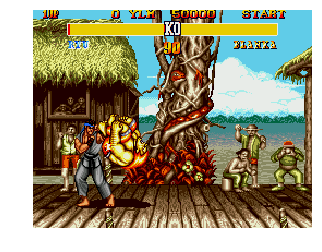

Total reward -8.0


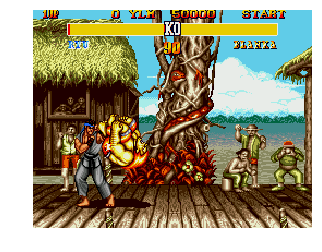

In [95]:
plt.figure(3)
plt.clf()

env.close()
saver = tf.train.Saver()
env = env = SF2Env(rom_path, 
                   'rvsb.state', 
                   scenario=scenario_name,
                   players=1,
                   use_restricted_actions=retro.Actions.DISCRETE)

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, model_path)
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        t = 0
        while True:
            t += 1
            # Reshape the state
            state = state.reshape((1, state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            a_list = [0]*env.action_space.n
            a_list[choice] = 1
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            
            plt.imshow(env.render(mode='rgb_array'))
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            
            total_rewards += reward

            if done:
                print ("Total reward", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            next_state = next_state.flatten()
            state = next_state
            
    env.close()

In [11]:
env.close()


In [98]:
memory.buffer[0]

(array([ 0.        ,  0.80851064,  0.80851064,  0.80851064,  0.80851064,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.        , -1.        , -1.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [96]:
len(memory.buffer)

171983

In [97]:
import sys
sys.getsizeof(memory)

56

In [76]:
env.close()